# 1. Project for Cuetessa, INC: Predicting Valence Score of Songs 


This project aimed to develop a Learning Model that predicts the valence score of songs utilizing features from the songs' spectograms. The ultimate goal of the project is to enhance the music listening experience for Cuetessa, Inc's users by accurately assigning songs to appropriate playlists based on their valence scores.

In this project, data on songs was obtained through the use of the Spotify for Developers API. The data source was derived from the ["Music artists popularity"](https://www.kaggle.com/datasets/pieca111/music-artists-popularity) dataset on Kaggle, where a random sample of 3,000 artists and their top 10 songs on Spotify were selected. From this selection, a random sample of 10,000 songs was taken and the following song features, listed below, were obtained through the Spotify for Developers API: 

- song_name
- song_id 
- song_preview_url
- artist_name
- artist_uri
- danceability
- energy 
- key 
- loudness
- mode
- speechiness
- acousticness
- instrumentalness
- liveness 
- valence 
- duration_ms
- time_signature

Subsequently, a 30-second audio preview of each of the 10,000 songs was saved from the Spotify for Developers API and stored as .wav files. These files were processed using the Librosa Library to extract the mean and variance from the Numpy arrays and first-order difference values for the following features, with the exception of tempo and spectral influx:

- tempo (beat per minute value only)
- spectral centroids
- spectral rolloffs 
- spectral contrast - 7 bands 
- mel frequency coefficients - 20 coefficients 
- zero crossing rate 
- chroma energy normalized statistics - 12 chromas
- root mean squared error 
- spectral influx (mean and variance of Numpy array only)
- onset rate 




In [ ]:
# libraries used for analysis
import pandas as pd 
!pip install spotipy
import spotipy 
import requests
from bs4 import BeautifulSoup
from spotipy.oauth2 import SpotifyClientCredentials
from google.colab import drive
import seaborn as sns
import librosa
import librosa.display
from sklearn.preprocessing import minmax_scale
import IPython.display as ipd
import wave 
import matplotlib.pyplot as plt
import numpy as np

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.8/237.8 KB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 3.7 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [ ]:
# Spotify API Info:
SPOTIPY_CLIENT_ID = ''
SPOTIPY_CLIENT_SECRET = ''

In [ ]:
auth_manager = SpotifyClientCredentials(client_id=SPOTIPY_CLIENT_ID, client_secret=SPOTIPY_CLIENT_SECRET)
sp = spotipy.Spotify(auth_manager=auth_manager)

In [ ]:
# mounting google drive to access data file
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# loading data for preprocessing
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/cuetessa_project/songs_spotify_data_22.csv')
data.head()

,song_name,song_id,song_preview_url,artist_name,artist_uri,danceability,energy,key,loudness,mode,...,time_signature,all_sp_centroids,all_rolloffs,all_spectral_costrast,all_mfcc,all_zrs,all_chromas,all_influx,all_onset_rate,all_rmse
0,She's Somebody's Daughter,7dQ9151STgBvjSxz8FM28m,https://p.scdn.co/mp3-preview/2776bf8f8e3c4ead...,Drew Baldridge,spotify:artist:08qaG5crPMPF7i0h2wORk5,0.613,0.876,6,-4.572,1,...,4,[2304.82508328 2150.15787444 2121.36999077 ......,[4801.90429688 4231.27441406 4091.30859375 ......,[[11.00178986 11.57217284 12.50334391 ... 15.9...,[[-86.40359 2.680859 20.62184 ... ...,[0.12939453 0.14746094 0.16992188 ... 0.121582...,[[0.23707601 0.23576571 0.23395916 ... 0.20191...,[0. 0. 0. ... 0.772848...,[ 3 8 21 34 48 56 61 68 74 ...,[0.23033306 0.23007211 0.26555508 ... 0.301231...
1,Cap Ferrat,5Rov4WsFB3ZWXlvAdIMDjf,https://p.scdn.co/mp3-preview/da759bc9711a1f5e...,Famy,spotify:artist:6pBeJe1VuufnPUFm2KI1oS,0.407,0.472,7,-7.375,1,...,3,[1384.26433575 1427.3216743 1525.37864264 ......,[2508.61816406 2627.05078125 2648.58398438 ......,[[21.07416886 18.53902086 24.52573305 ... 24.4...,[[-142.60866 -145.13448 -126.88814 ... ...,[0.04443359 0.06787109 0.08837891 ... 0.059082...,[[0.68075873 0.67574488 0.6696766 ... 0.15323...,[0. 0. 0. ... 0.6110046 1...,[ 4 19 34 49 63 93 108 123 138 ...,[0.0647774 0.07233007 0.08771111 ... 0.204516...
2,Clown,0EGVOnw876hry5JOK0ZaeV,https://p.scdn.co/mp3-preview/6a7535acec2d997f...,Emeli Sandé,spotify:artist:7sfgqEdoeBTjd8lQsPT3Cy,0.459,0.255,7,-8.118,1,...,4,[1667.37388737 1803.05537485 1931.00997871 ......,[4575.80566406 4984.93652344 5060.30273438 ......,[[14.95357193 9.00626436 14.31893433 ... 20.8...,[[-234.63135 -128.6944 -91.69956 .....,[0.12109375 0.13671875 0.15478516 ... 0.068359...,[[0.48528034 0.485159 0.48483999 ... 0.02314...,[0. 0. 0. ... 1.1384788 3...,[ 3 13 42 47 50 57 89 98 102 ...,[0.0863477 0.08759584 0.11496697 ... 0.210334...
3,Vampires,570aJug2ngcmKkXiwepoAP,https://p.scdn.co/mp3-preview/53925c115eba4baa...,Hot Hot Heat,spotify:artist:33LSz2nhC8pCPTb3pd5add,0.571,0.778,11,-4.117,1,...,4,[2167.77505018 2289.50416279 2261.26214147 ......,[4952.63671875 5221.80175781 5146.43554688 ......,[[19.76758765 12.91975376 26.34405328 ... 16.1...,[[ 2.1790751e+01 1.8015936e+01 8.1026649e+00...,[0.05322266 0.08105469 0.10693359 ... 0.092285...,[[0.21771573 0.21314965 0.20802776 ... 0.29099...,[0. 0. 0. ... 1.5754371 3...,[ 5 11 25 35 40 44 54 63 83 ...,[0.2957065 0.30459622 0.28711578 ... 0.361012...
4,Siempre en Mi Mente,5vmqRHDrMgdbw3CIvQycbj,https://p.scdn.co/mp3-preview/c277f3a460ea01c2...,Juan Gabriel,spotify:artist:2MRBDr0crHWE5JwPceFncq,0.394,0.452,0,-9.307,1,...,4,[2459.54051522 2415.60183435 2183.64830371 ......,[5146.43554688 4812.67089844 4274.34082031 ......,[[14.4143658 12.8544642 16.84987829 ... 12.5...,[[-3.6462635e+01 -4.2514179e+01 -5.1107346e+01...,[0.05810547 0.08398438 0.11572266 ... 0.120605...,[[0.54960567 0.55898231 0.56870316 ... 0.25083...,[0. 0. 0. ... 0.714174...,[ 9 26 38 44 53 63 72 80 97 ...,[0.14601319 0.14678419 0.1359868 ... 0.073952...


## 1.1 Data Preprocessing




### 1.1.1 Describing the data

The data files contained a total of 10,000 entries, each entry describes a song and its atributes, described in the following columns: 

- song_name: name of the song
- song_id :  uique ID for song in Spotify. 
- song_preview_url : link to 30 seconds preview of song on Spotify
- artist_name : name of the artist(s) of song
- artist_uri :  unique resource indicator of artist
- danceability : score describing  how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity.
- energy: score describing a perceptual measure of intensity and activity. 
- key: The estimated overall key of the track
- loudness : The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks.
- mode: Indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.
- speechiness: This detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value.
- acousticness: A confidence measure from 0.0 to 1.0 of whether the track is acoustic.
- instrumentalness: Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”.
- liveness: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live.
- valence: Describes the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).
- tempo: The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece, and derives directly from the average beat duration.
- duration_ms: The duration of the track in milliseconds.
- time_signature: An estimated overall time signature of a track. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure).
- all_sp_centroids: all spectral centroids calculated with Librosa library using the 30 second preview of the song from Spotify. 
- all_rolloffs: all spectral rolloffs calculated with Librosa library using the 30 second preview of the song from Spotify. 
- all_spectral_costrast: all spectral contrast calculated with Librosa library using the 30 second preview of the song from Spotify. 
- all_mfcc: all Mel-frequency cepstral coefficients calculated with Librosa library using the 30 second preview of the song from Spotify. 20 MFC coefficients in Numpy array.  
- all_zrs: all zero crossing rates calculated with Librosa library using the 30 second preview of the song from Spotify. 
- all_chromas: all chroma variant "Chroma Energy Normalized" (CENS) values calculated with Librosa library using the 30 second preview of the song from Spotify. List of 12 chromas in Numpy array. 
- all_influx: spectral flux onset strength envelope calculated with Librosa library using the 30 second preview of the song from Spotify.
- all_onset_rate: Peaks in an onset strength envelope calculated with Librosa library using the 30 second preview of the song from Spotify.
- all_rmse: root-mean-square (RMS) value for each frame calculated with Librosa library using the 30 second preview of the song from Spotify.


 Sources for definitions: 

1. *What Makes a Song Likeable?* 

link:  https://towardsdatascience.com/what-makes-a-song-likeable-dbfdb7abe404#:~:text=The%20Spotify%20Web%20API%20developer,beat%20strength%2C%20and%20overall%20regularity.

2. *Feature extraction*

link: https://librosa.org/doc/main/feature.html#spectral-features

### 1.1.2. Data types and missing values



In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   song_name              10000 non-null  object
 1   song_id                10000 non-null  object
 2   song_preview_url       10000 non-null  object
 3   artist_name            10000 non-null  object
 4   artist_uri             10000 non-null  object
 5   danceability           10000 non-null  object
 6   energy                 10000 non-null  object
 7   key                    10000 non-null  object
 8   loudness               10000 non-null  object
 9   mode                   10000 non-null  object
 10  speechiness            10000 non-null  object
 11  acousticness           10000 non-null  object
 12  instrumentalness       10000 non-null  object
 13  liveness               10000 non-null  object
 14  valence                10000 non-null  object
 15  tempo               

### 1.1.2.1 song_name column had a correct dtype in column and there were not 'not_available' or NaN values in the columns. Based on the documentation, 'not_available' was a value that was returned to this column if the song name was not available or could not get accessed through the Spotify API for developers. 

In [ ]:
# song name column
data.song_name.head(10)

0                            She's Somebody's Daughter
1                                           Cap Ferrat
2                                                Clown
3                                             Vampires
4                                  Siempre en Mi Mente
5       Haunted America Suite: 2. Ghosts of Gettysburg
6    Sacrifices (with EARTHGANG & J. Cole feat. Smi...
7                                          I'm Alright
8                                     Red River Valley
9                                              Redbone
Name: song_name, dtype: object

In [ ]:
data.query('song_name=="not_available"')

,song_name,song_id,song_preview_url,artist_name,artist_uri,danceability,energy,key,loudness,mode,...,time_signature,all_sp_centroids,all_rolloffs,all_spectral_costrast,all_mfcc,all_zrs,all_chromas,all_influx,all_onset_rate,all_rmse


#### 1.1.2.2 song_id column had a correct dtype in column and there were not 'not_available' or NaN values in the columns. Based on the documentation, 'not_available' was a value that was returned to this column if the song id was not available or could not get accessed through the Spotify API for developers. 

In [ ]:
# song_id column

#checking if song_id column has any 'not_avaible' values
print(data.query('song_id == "not_availble"'))
data.song_id.head(10)



Empty DataFrame
Columns: [song_name, song_id, song_preview_url, artist_name, artist_uri, danceability, energy, key, loudness, mode, speechiness, acousticness, instrumentalness, liveness, valence, tempo, duration_ms, time_signature, all_sp_centroids, all_rolloffs, all_spectral_costrast, all_mfcc, all_zrs, all_chromas, all_influx, all_onset_rate, all_rmse]
Index: []

[0 rows x 27 columns]


0    7dQ9151STgBvjSxz8FM28m
1    5Rov4WsFB3ZWXlvAdIMDjf
2    0EGVOnw876hry5JOK0ZaeV
3    570aJug2ngcmKkXiwepoAP
4    5vmqRHDrMgdbw3CIvQycbj
5    0l0nU8uWfF8a46njVHkjYW
6    7wTA0NKIm6T7nP2kaymU2a
7    1DuP6eYbgegal5FiydLdsB
8    1jhyGHXzgMvmIoyrcx3K2X
9    0WtDGnWL2KrMCk0mI1Gpwz
Name: song_id, dtype: object

#### 1.1.2.3 song_preview_url column had a correct dtype in column and there were not 'not_available' or NaN values in the columns. Based on the documentation, 'not_available' was a value that was returned to this column if the song preview url was not available or could not get accessed through the Spotify API for developers. 

In [ ]:
#song_preview_url column 

#checking if song_preview had any 'not_availble' values 
print(data.query('song_preview_url == "not_available"'))
data.song_preview_url.head(10)

Empty DataFrame
Columns: [song_name, song_id, song_preview_url, artist_name, artist_uri, danceability, energy, key, loudness, mode, speechiness, acousticness, instrumentalness, liveness, valence, tempo, duration_ms, time_signature, all_sp_centroids, all_rolloffs, all_spectral_costrast, all_mfcc, all_zrs, all_chromas, all_influx, all_onset_rate, all_rmse]
Index: []

[0 rows x 27 columns]


0    https://p.scdn.co/mp3-preview/2776bf8f8e3c4ead...
1    https://p.scdn.co/mp3-preview/da759bc9711a1f5e...
2    https://p.scdn.co/mp3-preview/6a7535acec2d997f...
3    https://p.scdn.co/mp3-preview/53925c115eba4baa...
4    https://p.scdn.co/mp3-preview/c277f3a460ea01c2...
5    https://p.scdn.co/mp3-preview/a549c7db7d482c2e...
6    https://p.scdn.co/mp3-preview/ad11da0b469a8722...
7    https://p.scdn.co/mp3-preview/2f8163d73ee7d63e...
8    https://p.scdn.co/mp3-preview/600364ff27c39b03...
9    https://p.scdn.co/mp3-preview/d1f5addfcf8cca7b...
Name: song_preview_url, dtype: object

#### 1.1.2.4 artist_name column had a correct dtype in column and there were not 'not_available' or NaN values in the columns. Based on the documentation, 'not_available' was a value that was returned to this column if the artist name was not available or could not get accessed through the Spotify API for developers. 

In [ ]:
# artist_name column 

#checking if artist_name had any 'not_availble' values 
print(data.query('artist_name == "not_available"'))
data.artist_name.head(10)

Empty DataFrame
Columns: [song_name, song_id, song_preview_url, artist_name, artist_uri, danceability, energy, key, loudness, mode, speechiness, acousticness, instrumentalness, liveness, valence, tempo, duration_ms, time_signature, all_sp_centroids, all_rolloffs, all_spectral_costrast, all_mfcc, all_zrs, all_chromas, all_influx, all_onset_rate, all_rmse]
Index: []

[0 rows x 27 columns]


0      Drew Baldridge
1                Famy
2         Emeli Sandé
3        Hot Hot Heat
4        Juan Gabriel
5         Jim Shearer
6               Dream
7          Kim Richey
8         Lloyd Green
9    Childish Gambino
Name: artist_name, dtype: object

#### 1.1.2.5 artist_uri column had a correct dtype in column and there were not 'not_available' or NaN values in the columns. Based on the documentation, 'not_available' was a value that was returned to this column if the artist uri was not available or could not get accessed through the Spotify API for developers. 

In [ ]:
# artist_uri column 

#checking if artist_uri had any 'not_availble' values 
print(data.query('artist_uri == "not_available"'))

data.artist_uri.head(10)

Empty DataFrame
Columns: [song_name, song_id, song_preview_url, artist_name, artist_uri, danceability, energy, key, loudness, mode, speechiness, acousticness, instrumentalness, liveness, valence, tempo, duration_ms, time_signature, all_sp_centroids, all_rolloffs, all_spectral_costrast, all_mfcc, all_zrs, all_chromas, all_influx, all_onset_rate, all_rmse]
Index: []

[0 rows x 27 columns]


0    spotify:artist:08qaG5crPMPF7i0h2wORk5
1    spotify:artist:6pBeJe1VuufnPUFm2KI1oS
2    spotify:artist:7sfgqEdoeBTjd8lQsPT3Cy
3    spotify:artist:33LSz2nhC8pCPTb3pd5add
4    spotify:artist:2MRBDr0crHWE5JwPceFncq
5    spotify:artist:6au3loxZSPq0FOHTXhRmhJ
6    spotify:artist:1iNqsUDUraNWrj00bqssQG
7    spotify:artist:4Rx72ewRjxlDGiO6wPHpxe
8    spotify:artist:7f8yc2rnAbX0v5imazWtFG
9    spotify:artist:73sIBHcqh3Z3NyqHKZ7FOL
Name: artist_uri, dtype: object

#### 1.1.2.6 danceability column had a incorrect dtype in column and was changed to float64. There were 5 'not_available' or NaN values in the column, which were dropped. Based on the documentation, 'not_available' was a value that was returned to this column if the danceability was not available or could not get accessed through the Spotify API for developers. 

In [ ]:
# danceability column 

#checking if danceability column had any 'not_availble' values 
print('Number of rows that cotain empty values for danceability: ', len(data.query('danceability == "not_available"')))

#deleting column in which danceability was not availble
data = data.query('danceability != "not_available"')
print('Number of rows that cotain empty values for danceability: ', len(data.query('danceability == "not_available"')))

#changing data type to float64 

data['danceability'] = data['danceability'].astype(float)

data.danceability.head(10)

Number of rows that cotain empty values for danceability:  5
Number of rows that cotain empty values for danceability:  0


<ipython-input-13-021255edfafb>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['danceability'] = data['danceability'].astype(float)


0    0.613
1    0.407
2    0.459
3    0.571
4    0.394
5    0.297
6    0.825
7    0.624
8    0.397
9    0.745
Name: danceability, dtype: float64

#### 1.1.2.7 energy column had a incorrect dtype in column and was changed to float64. There were not 'not_available' or NaN values in the column. Based on the documentation, 'not_available' was a value that was returned to this column if the energy was not available or could not get accessed through the Spotify API for developers. 

In [ ]:
# energy column

#checking if energy column had any 'not_available' values 
print(data.query('energy == "not_available"'))

#changing dtype to float
data['energy'] = data['energy'].astype('float')

data.energy.head(10)

Empty DataFrame
Columns: [song_name, song_id, song_preview_url, artist_name, artist_uri, danceability, energy, key, loudness, mode, speechiness, acousticness, instrumentalness, liveness, valence, tempo, duration_ms, time_signature, all_sp_centroids, all_rolloffs, all_spectral_costrast, all_mfcc, all_zrs, all_chromas, all_influx, all_onset_rate, all_rmse]
Index: []

[0 rows x 27 columns]


<ipython-input-14-b4dc7b6be69a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['energy'] = data['energy'].astype('float')


0    0.87600
1    0.47200
2    0.25500
3    0.77800
4    0.45200
5    0.00989
6    0.67200
7    0.47200
8    0.13000
9    0.35300
Name: energy, dtype: float64

#### 1.1.2.8 Key column had a incorrect dtype in column and was changed to float64. There were not 'not_available' or NaN values in the column. Based on the documentation, 'not_available' was a value that was returned to this column if the key was not available or could not get accessed through the Spotify API for developers. 

In [ ]:
# key column 

# checking if key column had 'not_avialable' values
data.query('key == "not_available"')

#changing column dtype to float
data['key'] = data['key'].astype(float)

data.key.head(10)

0     6.0
1     7.0
2     7.0
3    11.0
4     0.0
5     0.0
6     0.0
7     2.0
8     2.0
9     1.0
Name: key, dtype: float64

#### 1.1.2.9 Loudness column had a incorrect dtype in column and was changed to float64. There were not 'not_available' or NaN values in the column. Based on the documentation, 'not_available' was a value that was returned to this column if the loudness was not available or could not get accessed through the Spotify API for developers. 

In [ ]:
#loudness column

#checking if loudness column had any 'not_available' values
data.query('loudness == "not_available"')

#changing dtype of column to float 

data['loudness'] = data['loudness'].astype(float)

data.loudness.head(10)

0    -4.572
1    -7.375
2    -8.118
3    -4.117
4    -9.307
5   -29.239
6    -7.108
7    -6.844
8   -22.218
9   -10.614
Name: loudness, dtype: float64

#### 1.1.2.10 Mode column had a incorrect dtype in column and was changed to int64. There were not 'not_available' or NaN values in the column. Based on the documentation, 'not_available' was a value that was returned to this column if the mode was not available or could not get accessed through the Spotify API for developers. 

In [ ]:
# mode column 

#checking if mode column had any 'not_available' values 
data.query('mode == "not_available"') 

#changing column dtype to int64
data['mode'] = data['mode'].astype(int)

data['mode'].head(10)

0    1
1    1
2    1
3    1
4    1
5    1
6    1
7    1
8    1
9    1
Name: mode, dtype: int64

#### 1.1.2.11 Speechiness column had a incorrect dtype in column and was changed to float64. There were not 'not_available' or NaN values in the column. Based on the documentation, 'not_available' was a value that was returned to this column if the speechiness was not available or could not get accessed through the Spotify API for developers. 

In [ ]:
#speechiness column 

#checking if speechiness column had any 'not_available' values
data.query('speechiness == "not_available"')

#changing column dtype to float
data['speechiness'] = data['speechiness'].astype(float)
data.speechiness.head(10)

0    0.0298
1    0.0267
2    0.0383
3    0.0320
4    0.0261
5    0.0464
6    0.4180
7    0.0260
8    0.0435
9    0.0983
Name: speechiness, dtype: float64

#### 1.1.2.12 accousticness column had a incorrect dtype in column and was changed to float64. There were not 'not_available' or NaN values in the column. Based on the documentation, 'not_available' was a value that was returned to this column if the accousticness was not available or could not get accessed through the Spotify API for developers. 

In [ ]:
# acousticness column 

#checking if acousticness column had any 'not_available' values 
data.query('acousticness == "not_available"')

#changing column dtype to float 
data['acousticness'] = data['acousticness'].astype(float)

data.acousticness.head(10)

0    0.06860
1    0.00745
2    0.91600
3    0.02350
4    0.06210
5    0.99100
6    0.08580
7    0.15500
8    0.72600
9    0.17400
Name: acousticness, dtype: float64

#### 1.1.2.13 instrumentalness column had a incorrect dtype in column and was changed to float64. There were not 'not_available' or NaN values in the column. Based on the documentation, 'not_available' was a value that was returned to this column if the instrumentalness was not available or could not get accessed through the Spotify API for developers. 

In [ ]:
#data instrumentalness 

#checking if column had any 'not_available' values
data.query('instrumentalness == "not_available"')

#changing column dtype to float 
data['instrumentalness'] = data['instrumentalness'].astype(float)

data.instrumentalness.head(10)

0    0.000000
1    0.439000
2    0.000407
3    0.126000
4    0.000115
5    0.948000
6    0.000000
7    0.000061
8    0.576000
9    0.006620
Name: instrumentalness, dtype: float64

#### 1.1.2.14 liveness column had a incorrect dtype in column and was changed to float64. There were not 'not_available' or NaN values in the column. Based on the documentation, 'not_available' was a value that was returned to this column if the liveness was not available or could not get accessed through the Spotify API for developers. 

In [ ]:
# liveness column

#checking if column had any 'not_available' values 
data.query('liveness == "not_available"')

#changing column dtype to float
data['liveness'] = data['liveness'].astype(float)

data.liveness.head(10)

0    0.0940
1    0.1020
2    0.1130
3    0.0987
4    0.4710
5    0.0725
6    0.1230
7    0.1320
8    0.1210
9    0.1180
Name: liveness, dtype: float64

#### 1.1.2.15 valence column had a incorrect dtype in column and was changed to float64. There were not 'not_available' or NaN values in the column. Based on the documentation, 'not_available' was a value that was returned to this column if the valence was not available or could not get accessed through the Spotify API for developers. 

In [ ]:
#valence column 

#checking if column had any 'not_available' values 
data.query('valence == "not_available"')

#changing column dtype to float 
data['valence'] = data['valence'].astype(float)

data.valence.head(10)

0    0.4470
1    0.2480
2    0.2290
3    0.8020
4    0.5990
5    0.0958
6    0.2460
7    0.5130
8    0.3730
9    0.5980
Name: valence, dtype: float64

 #### 1.1.2.16 valence column had a incorrect dtype in column and was changed to float64. There were 255 'not_available' or NaN values in the column, which were dropped. Based on the documentation, 'not_available' was a value that was returned to this column if the tempo was not available or could not get accessed through the Spotify API for developers.

In [ ]:
#tempo column 
print('number of words with not_availabe values: ',len(data.query('tempo == "not_available"')))

# removing not_available values from column 
data = data.query('tempo != "not_available"')
print('number of words with not_availabe values: ',len(data.query('tempo == "not_available"')))

#changing column dtype to float 
data['tempo'] = data['tempo'].astype(float)

data.tempo.head(10)

number of words with not_availabe values:  255
number of words with not_availabe values:  0


<ipython-input-23-f25ebff7b7da>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['tempo'] = data['tempo'].astype(float)


0     99.384014
1    172.265625
2    129.199219
3    135.999178
4    143.554688
5    129.199219
6    143.554688
7    135.999178
8     99.384014
9    161.499023
Name: tempo, dtype: float64

#### 1.1.2.17 duration_ms column had a incorrect dtype in column and was changed to int64. There were not 'not_available' or NaN values in the column. Based on the documentation, 'not_available' was a value that was returned to this column if the duration in ms was not available or could not get accessed through the Spotify API for developers.

In [ ]:
#duration_ms column 

#checking if column had any "not_available" values 
data.query('duration_ms == "not_available"')

#changing column dtype to int64
data['duration_ms'] = data['duration_ms'].astype(int)

data.duration_ms.head(10)

<ipython-input-24-4cdeeb7f8ed7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['duration_ms'] = data['duration_ms'].astype(int)


0    176360
1    269655
2    221173
3    232720
4    205867
5    378747
6    382307
7    241133
8    162852
9    326933
Name: duration_ms, dtype: int64

#### 1.1.2.18 time_signature column had a incorrect dtype in column and was changed to int64. There were not 'not_available' or NaN values in the column. Based on the documentation, 'not_available' was a value that was returned to this column if the time signature was not available or could not get accessed through the Spotify API for developers.

In [ ]:
#time_signature column

#checking if column had any 'not_available' values
data.query('time_signature == "not_available"')

#changing column dtype to int64
data['time_signature'] = data['time_signature'].astype(int)

data.time_signature.head(10)

<ipython-input-25-dcbdf9727341>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['time_signature'] = data['time_signature'].astype(int)


0    4
1    3
2    4
3    4
4    4
5    4
6    4
7    4
8    4
9    4
Name: time_signature, dtype: int64

In [ ]:
#resetting index after dropping rows with 'not_available' values or NaN values
data.reset_index(inplace=True, drop=True)
data

,song_name,song_id,song_preview_url,artist_name,artist_uri,danceability,energy,key,loudness,mode,...,time_signature,all_sp_centroids,all_rolloffs,all_spectral_costrast,all_mfcc,all_zrs,all_chromas,all_influx,all_onset_rate,all_rmse
0,She's Somebody's Daughter,7dQ9151STgBvjSxz8FM28m,https://p.scdn.co/mp3-preview/2776bf8f8e3c4ead...,Drew Baldridge,spotify:artist:08qaG5crPMPF7i0h2wORk5,0.613,0.876,6.0,-4.572,1,...,4,[2304.82508328 2150.15787444 2121.36999077 ......,[4801.90429688 4231.27441406 4091.30859375 ......,[[11.00178986 11.57217284 12.50334391 ... 15.9...,[[-86.40359 2.680859 20.62184 ... ...,[0.12939453 0.14746094 0.16992188 ... 0.121582...,[[0.23707601 0.23576571 0.23395916 ... 0.20191...,[0. 0. 0. ... 0.772848...,[ 3 8 21 34 48 56 61 68 74 ...,[0.23033306 0.23007211 0.26555508 ... 0.301231...
1,Cap Ferrat,5Rov4WsFB3ZWXlvAdIMDjf,https://p.scdn.co/mp3-preview/da759bc9711a1f5e...,Famy,spotify:artist:6pBeJe1VuufnPUFm2KI1oS,0.407,0.472,7.0,-7.375,1,...,3,[1384.26433575 1427.3216743 1525.37864264 ......,[2508.61816406 2627.05078125 2648.58398438 ......,[[21.07416886 18.53902086 24.52573305 ... 24.4...,[[-142.60866 -145.13448 -126.88814 ... ...,[0.04443359 0.06787109 0.08837891 ... 0.059082...,[[0.68075873 0.67574488 0.6696766 ... 0.15323...,[0. 0. 0. ... 0.6110046 1...,[ 4 19 34 49 63 93 108 123 138 ...,[0.0647774 0.07233007 0.08771111 ... 0.204516...
2,Clown,0EGVOnw876hry5JOK0ZaeV,https://p.scdn.co/mp3-preview/6a7535acec2d997f...,Emeli Sandé,spotify:artist:7sfgqEdoeBTjd8lQsPT3Cy,0.459,0.255,7.0,-8.118,1,...,4,[1667.37388737 1803.05537485 1931.00997871 ......,[4575.80566406 4984.93652344 5060.30273438 ......,[[14.95357193 9.00626436 14.31893433 ... 20.8...,[[-234.63135 -128.6944 -91.69956 .....,[0.12109375 0.13671875 0.15478516 ... 0.068359...,[[0.48528034 0.485159 0.48483999 ... 0.02314...,[0. 0. 0. ... 1.1384788 3...,[ 3 13 42 47 50 57 89 98 102 ...,[0.0863477 0.08759584 0.11496697 ... 0.210334...
3,Vampires,570aJug2ngcmKkXiwepoAP,https://p.scdn.co/mp3-preview/53925c115eba4baa...,Hot Hot Heat,spotify:artist:33LSz2nhC8pCPTb3pd5add,0.571,0.778,11.0,-4.117,1,...,4,[2167.77505018 2289.50416279 2261.26214147 ......,[4952.63671875 5221.80175781 5146.43554688 ......,[[19.76758765 12.91975376 26.34405328 ... 16.1...,[[ 2.1790751e+01 1.8015936e+01 8.1026649e+00...,[0.05322266 0.08105469 0.10693359 ... 0.092285...,[[0.21771573 0.21314965 0.20802776 ... 0.29099...,[0. 0. 0. ... 1.5754371 3...,[ 5 11 25 35 40 44 54 63 83 ...,[0.2957065 0.30459622 0.28711578 ... 0.361012...
4,Siempre en Mi Mente,5vmqRHDrMgdbw3CIvQycbj,https://p.scdn.co/mp3-preview/c277f3a460ea01c2...,Juan Gabriel,spotify:artist:2MRBDr0crHWE5JwPceFncq,0.394,0.452,0.0,-9.307,1,...,4,[2459.54051522 2415.60183435 2183.64830371 ......,[5146.43554688 4812.67089844 4274.34082031 ......,[[14.4143658 12.8544642 16.84987829 ... 12.5...,[[-3.6462635e+01 -4.2514179e+01 -5.1107346e+01...,[0.05810547 0.08398438 0.11572266 ... 0.120605...,[[0.54960567 0.55898231 0.56870316 ... 0.25083...,[0. 0. 0. ... 0.714174...,[ 9 26 38 44 53 63 72 80 97 ...,[0.14601319 0.14678419 0.1359868 ... 0.073952...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9735,"All I Ask of You (from ""The Phantom of the Ope...",3XbuqATuVYo20LysQKShOW,https://p.scdn.co/mp3-preview/8228b38f59b95362...,Josh Groban,spotify:artist:6cXMpsP9x0SH4kFfMyVezF,0.223,0.268,1.0,-9.468,1,...,4,[2536.90515587 2539.80189939 2536.6272443 ......,[5157.20214844 5146.43554688 5146.43554688 ......,[[18.02058505 8.22514904 11.6157124 ... 17.9...,[[ -93.32251 -7.1102204 9.541124 .....,[0.13085938 0.15673828 0.18212891 ... 0.083984...,[[0.35476524 0.36104532 0.36640135 ... 0.27710...,[0. 0. 0. ... 0.982535...,[ 3 16 21 32 43 54 58 61 76 ...,[0.19996451 0.21303396 0.25292727 ... 0.134237...
9736,Unstoppable,516FuPYYQ0Oq40OlDQBPri,https://p.scdn.co/mp3-preview/274043b3a35f39d1...,The Calling,spotify:artist:5aMmmNxw4vgpc5XC6hK0zp,0.384,0.740,8.0,-6.125,0,...,4,[2672.81744363 2598.84492064 2568.58152693 

#### 1.1.2.18 The following columns: all_sp_centroids, all_rolloffs, all_spectral_costrast, all_mfcc, all_zrs, all_chromas, all_influx, all_onset_rate, and all_rmse were deleted because there was an error while saving numerical data in the columns. Therefore, the data was collected on spectral centroids, spectral rolloffs, spectral contrast, Mel Frequency Cepstral Coefficients, zero crossing rates, chroma energy normalized statistics, spectral influx, onset rates, and root mean square error values from .wav files of the songs. 

#### 1.1.2.18 spectral centroids columns 
For this section, we processed the .wav files for each of the songs and collected an np.array of the spectral centroids. The np.array was processed in a loop to create the following columns for data: 

- sc_mean : spectral centroids mean 
- sc_variance = spectral centroids variance
- sc_mean_fod = mean of first order difference of spectral centroids
- sc_var_fod = variance of first order difference of spectral centroids

In [ ]:
#creating new columns in data for spectral centroids

''' This section was saved as a comment to avoid saving DataFrame again, and avoid running 
this loop, which takes ~4.25 hours to run. 


sc_mean = []
sc_variance = []
sc_mean_fod = []
sc_var_fod = []

for i in range(len(data)):
  song_id = data['song_id'][i]
  file_path = '/content/drive/MyDrive/Colab Notebooks/cuetessa_project/songs_url_preview/' + song_id +'.wav'
  wave_x, sample_rate = librosa.load(file_path)
  all_centroids = librosa.feature.spectral_centroid(wave_x,sr=sample_rate)[0]
  
  mean = all_centroids.mean()
  var = np.var(all_centroids)
  fod = np.diff(all_centroids)
  mean_fod = fod.mean()
  var_fod = np.var(fod)

  sc_mean.append(mean)
  sc_variance.append(var)
  sc_mean_fod.append(mean_fod)
  sc_var_fod.append(var_fod)


#creating new column in data

data['sc_mean'] = sc_mean
data['sc_var'] = sc_variance
data['sc_mean_fod'] = sc_mean_fod 
data['sc_var_fod'] = sc_var_fod


drive.mount('/content/gdrive', force_remount = True)

path = 'gdrive/MyDrive/Colab Notebooks/cuetessa_project/'
data.to_csv(path+'songs_spotify_data_23.csv', index=None)

'''

" This section was saved as a comment to avoid saving DataFrame again, and avoid running \nthis loop, which takes ~4.25 hours to run. \n\n\nsc_mean = []\nsc_variance = []\nsc_mean_fod = []\nsc_var_fod = []\n\nfor i in range(len(data)):\n  song_id = data['song_id'][i]\n  file_path = '/content/drive/MyDrive/Colab Notebooks/cuetessa_project/songs_url_preview/' + song_id +'.wav'\n  wave_x, sample_rate = librosa.load(file_path)\n  all_centroids = librosa.feature.spectral_centroid(wave_x,sr=sample_rate)[0]\n  \n  mean = all_centroids.mean()\n  var = np.var(all_centroids)\n  fod = np.diff(all_centroids)\n  mean_fod = fod.mean()\n  var_fod = np.var(fod)\n\n  sc_mean.append(mean)\n  sc_variance.append(var)\n  sc_mean_fod.append(mean_fod)\n  sc_var_fod.append(var_fod)\n\n\n#creating new column in data\n\ndata['sc_mean'] = sc_mean\ndata['sc_var'] = sc_variance\ndata['sc_mean_fod'] = sc_mean_fod \ndata['sc_var_fod'] = sc_var_fod\n\n\ndrive.mount('/content/gdrive', force_remount = True)\n\npath = '

#### 1.1.2.19 spectral rolloffs columns 
For this section, we processed the .wav files for each of the songs and collected an np.array of the spectral rolloffs. The np.array was processed in a loop to create the following columns for data: 

- sr_mean : spectral rolloffs mean 
- sr_variance = spectral rolloffs variance
- sr_mean_fod = mean of first order difference of spectral rolloffs
- sr_var_fod = variance of first order difference of spectral rolloffs


In [ ]:
#creating new columns in data for spectral rolloffs


''' This section was saved as a comment to avoid saving DataFrame again, and avoid running 
this loop, which takes ~4.25 hours to run. 

sr_mean = []
sr_variance = []
sr_mean_fod = []
sr_var_fod = []

for i in range(len(data)):
  song_id = data['song_id'][i]
  file_path = '/content/drive/MyDrive/Colab Notebooks/cuetessa_project/songs_url_preview/' + song_id +'.wav'
  wave_x, sample_rate = librosa.load(file_path)
  all_rolloffs = librosa.feature.spectral_rolloff(wave_x,sr=sample_rate)[0]
  
  mean = all_rolloffs.mean()
  var = np.var(all_rolloffs)
  fod = np.diff(all_rolloffs)
  mean_fod = fod.mean()
  var_fod = np.var(fod)

  sr_mean.append(mean)
  sr_variance.append(var)
  sr_mean_fod.append(mean_fod)
  sr_var_fod.append(var_fod)


#creating new column in data

data['sr_mean'] = sr_mean
data['sr_var'] = sr_variance
data['sr_mean_fod'] = sr_mean_fod 
data['sr_var_fod'] = sr_var_fod


drive.mount('/content/gdrive', force_remount = True)

path = 'gdrive/MyDrive/Colab Notebooks/cuetessa_project/'
data.to_csv(path+'songs_spotify_data_24.csv', index=None)

'''

" This section was saved as a comment to avoid saving DataFrame again, and avoid running \nthis loop, which takes ~4.25 hours to run. \n\nsr_mean = []\nsr_variance = []\nsr_mean_fod = []\nsr_var_fod = []\n\nfor i in range(len(data)):\n  song_id = data['song_id'][i]\n  file_path = '/content/drive/MyDrive/Colab Notebooks/cuetessa_project/songs_url_preview/' + song_id +'.wav'\n  wave_x, sample_rate = librosa.load(file_path)\n  all_rolloffs = librosa.feature.spectral_rolloff(wave_x,sr=sample_rate)[0]\n  \n  mean = all_rolloffs.mean()\n  var = np.var(all_rolloffs)\n  fod = np.diff(all_rolloffs)\n  mean_fod = fod.mean()\n  var_fod = np.var(fod)\n\n  sr_mean.append(mean)\n  sr_variance.append(var)\n  sr_mean_fod.append(mean_fod)\n  sr_var_fod.append(var_fod)\n\n\n#creating new column in data\n\ndata['sr_mean'] = sr_mean\ndata['sr_var'] = sr_variance\ndata['sr_mean_fod'] = sr_mean_fod \ndata['sr_var_fod'] = sr_var_fod\n\n\ndrive.mount('/content/gdrive', force_remount = True)\n\npath = 'gdrive/

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/cuetessa_project/songs_spotify_data_24.csv')
data.head()

,song_name,song_id,song_preview_url,artist_name,artist_uri,danceability,energy,key,loudness,mode,...,all_onset_rate,all_rmse,sc_mean,sc_var,sc_mean_fod,sc_var_fod,sr_mean,sr_var,sr_mean_fod,sr_var_fod
0,She's Somebody's Daughter,7dQ9151STgBvjSxz8FM28m,https://p.scdn.co/mp3-preview/2776bf8f8e3c4ead...,Drew Baldridge,spotify:artist:08qaG5crPMPF7i0h2wORk5,0.613,0.876,6.0,-4.572,1,...,[ 3 8 21 34 48 56 61 68 74 ...,[0.23033306 0.23007211 0.26555508 ... 0.301231...,2544.412487,300240.032982,0.027768,88538.945346,5587.007883,1.394413e+06,0.758916,460294.141643
1,Cap Ferrat,5Rov4WsFB3ZWXlvAdIMDjf,https://p.scdn.co/mp3-preview/da759bc9711a1f5e...,Famy,spotify:artist:6pBeJe1VuufnPUFm2KI1oS,0.407,0.472,7.0,-7.375,1,...,[ 4 19 34 49 63 93 108 123 138 ...,[0.0647774 0.07233007 0.08771111 ... 0.204516...,1405.294915,321422.474391,0.038254,48280.662307,2970.388524,1.800449e+06,0.785152,363836.188122
2,Clown,0EGVOnw876hry5JOK0ZaeV,https://p.scdn.co/mp3-preview/6a7535acec2d997f...,Emeli Sandé,spotify:artist:7sfgqEdoeBTjd8lQsPT3Cy,0.459,0.255,7.0,-8.118,1,...,[ 3 13 42 47 50 57 89 98 102 ...,[0.0863477 0.08759584 0.11496697 ... 0.210334...,1686.145031,398564.069236,-0.205299,75973.716128,3386.262857,2.260525e+06,-1.300999,462788.216942
3,Vampires,570aJug2ngcmKkXiwepoAP,https://p.scdn.co/mp3-preview/53925c115eba4baa...,Hot Hot Heat,spotify:artist:33LSz2nhC8pCPTb3pd5add,0.571,0.778,11.0,-4.117,1,...,[ 5 11 25 35 40 44 54 63 83 ...,[0.2957065 0.30459622 0.28711578 ... 0.361012...,1919.920799,138650.789150,-0.664419,21012.967810,4137.463095,8.824723e+05,-1.595361,120191.624616
4,Siempre en Mi Mente,5vmqRHDrMgdbw3CIvQycbj,https://p.scdn.co/mp3-preview/c277f3a460ea01c2...,Juan Gabriel,spotify:artist:2MRBDr0crHWE5JwPceFncq,0.394,0.452,0.0,-9.307,1,...,[ 9 26 38 44 53 63 72 80 97 ...,[0.14601319 0.14678419 0.1359868 ... 0.073952...,2321.467848,351537.711048,-0.711712,47937.465227,4645.938806,9.677353e+05,-1.528540,169454.562223


#### 1.1.2.20 spectral contrast columns
For this section, we processed the .wav files for each of the songs and collected 7 np.arrays of the spectral contrasts. The np.arrays were processed in a loop to create the following columns for data: 

- scon_mean_# : spectral contrast mean 
- scon_variance_# = spectral contrast variance
- scon_mean_fod_# = mean of first order difference of spectral contrast
- sc_var_fod_# = variance of first order difference of spectral contrast

Note:  # indicates the (index number +1) of each of the np.arrays collected from .wav file using Librosa

In [ ]:
  #creating new columns in data for spectral contrasts

''' This section was saved as a comment to avoid saving DataFrame again, and avoid running 
this loop, which takes ~4.25 hours to run. 

scon_mean_1 = []
scon_mean_2 = []
scon_mean_3 = []
scon_mean_4 = []
scon_mean_5 = []
scon_mean_6 = []
scon_mean_7 = []

scon_variance_1 = []
scon_variance_2 = []
scon_variance_3 = []
scon_variance_4 = []
scon_variance_5 = []
scon_variance_6 = []
scon_variance_7 = []

scon_mean_fod_1 = []
scon_mean_fod_2 = []
scon_mean_fod_3 = []
scon_mean_fod_4 = []
scon_mean_fod_5 = []
scon_mean_fod_6 = []
scon_mean_fod_7 = []

scon_var_fod_1 = []
scon_var_fod_2 = []
scon_var_fod_3 = []
scon_var_fod_4 = []
scon_var_fod_5 = []
scon_var_fod_6 = []
scon_var_fod_7 = []

for i in range(len(data)):
    song_id = data['song_id'][i]
    file_path = '/content/drive/MyDrive/Colab Notebooks/cuetessa_project/songs_url_preview/' + song_id +'.wav'
    wave_x, sample_rate = librosa.load(file_path)
    all_contrasts = librosa.feature.spectral_contrast(wave_x,sr=sample_rate)
    

    mean_1 = all_contrasts[0].mean()
    var_1 = np.var(all_contrasts[0])
    fod_1 = np.diff(all_contrasts[0])
    mean_fod_1 = fod_1.mean()
    var_fod_1 = np.var(fod_1)

    mean_2 = all_contrasts[1].mean()
    var_2 = np.var(all_contrasts[1])
    fod_2 = np.diff(all_contrasts[1])
    mean_fod_2 = fod_2.mean()
    var_fod_2 = np.var(fod_2)
    
    mean_3 = all_contrasts[2].mean()
    var_3 = np.var(all_contrasts[2])
    fod_3 = np.diff(all_contrasts[2])
    mean_fod_3 = fod_3.mean()
    var_fod_3 = np.var(fod_3)

    mean_4 = all_contrasts[3].mean()
    var_4 = np.var(all_contrasts[3])
    fod_4 = np.diff(all_contrasts[3])
    mean_fod_4 = fod_4.mean()
    var_fod_4 = np.var(fod_4)

    mean_5 = all_contrasts[4].mean()
    var_5 = np.var(all_contrasts[4])
    fod_5 = np.diff(all_contrasts[4])
    mean_fod_5 = fod_5.mean()
    var_fod_5 = np.var(fod_5)

    mean_6 = all_contrasts[5].mean()
    var_6 = np.var(all_contrasts[5])
    fod_6 = np.diff(all_contrasts[5])
    mean_fod_6 = fod_6.mean()
    var_fod_6 = np.var(fod_6)

    mean_7 = all_contrasts[6].mean()
    var_7 = np.var(all_contrasts[6])
    fod_7 = np.diff(all_contrasts[6])
    mean_fod_7 = fod_7.mean()
    var_fod_7 = np.var(fod_7)

    scon_mean_1.append(mean_1)
    scon_mean_2.append(mean_2)
    scon_mean_3.append(mean_3)
    scon_mean_4.append(mean_4)
    scon_mean_5.append(mean_5)
    scon_mean_6.append(mean_6)
    scon_mean_7.append(mean_7)

    scon_variance_1.append(var_1)
    scon_variance_2.append(var_2)
    scon_variance_3.append(var_3)
    scon_variance_4.append(var_4)
    scon_variance_5.append(var_5)
    scon_variance_6.append(var_6)
    scon_variance_7.append(var_7)

    scon_mean_fod_1.append(mean_fod_1)
    scon_mean_fod_2.append(mean_fod_2)
    scon_mean_fod_3.append(mean_fod_3)
    scon_mean_fod_4.append(mean_fod_4)
    scon_mean_fod_5.append(mean_fod_5)
    scon_mean_fod_6.append(mean_fod_6)
    scon_mean_fod_7.append(mean_fod_7)

    scon_var_fod_1.append(var_fod_1)
    scon_var_fod_2.append(var_fod_2)
    scon_var_fod_3.append(var_fod_3)
    scon_var_fod_4.append(var_fod_4)
    scon_var_fod_5.append(var_fod_5)
    scon_var_fod_6.append(var_fod_6)
    scon_var_fod_7.append(var_fod_7)

#creating new columns in data

data['scon_mean_1'] = scon_mean_1
data['scon_mean_2'] = scon_mean_2
data['scon_mean_3'] = scon_mean_3
data['scon_mean_4'] = scon_mean_4
data['scon_mean_5'] = scon_mean_5
data['scon_mean_6'] = scon_mean_6
data['scon_mean_7'] = scon_mean_7

data['scon_variance_1'] = scon_variance_1
data['scon_variance_2'] = scon_variance_2
data['scon_variance_3'] = scon_variance_3
data['scon_variance_4'] = scon_variance_4
data['scon_variance_5'] = scon_variance_5
data['scon_variance_6'] = scon_variance_6
data['scon_variance_7'] = scon_variance_7

data['scon_mean_fod_1'] = scon_mean_fod_1
data['scon_mean_fod_2'] = scon_mean_fod_2
data['scon_mean_fod_3'] = scon_mean_fod_3
data['scon_mean_fod_4'] = scon_mean_fod_4
data['scon_mean_fod_5'] = scon_mean_fod_5
data['scon_mean_fod_6'] = scon_mean_fod_6
data['scon_mean_fod_7'] = scon_mean_fod_7

data['scon_var_fod_1'] = scon_var_fod_1
data['scon_var_fod_2'] = scon_var_fod_2
data['scon_var_fod_3'] = scon_var_fod_3
data['scon_var_fod_4'] = scon_var_fod_4
data['scon_var_fod_5'] = scon_var_fod_5
data['scon_var_fod_6'] = scon_var_fod_6
data['scon_var_fod_7'] = scon_var_fod_7


drive.mount('/content/gdrive', force_remount = True)

path = 'gdrive/MyDrive/Colab Notebooks/cuetessa_project/'
data.to_csv(path+'songs_spotify_data_25.csv', index=None)

'''

" This section was saved as a comment to avoid saving DataFrame again, and avoid running \nthis loop, which takes ~4.25 hours to run. \n\nscon_mean_1 = []\nscon_mean_2 = []\nscon_mean_3 = []\nscon_mean_4 = []\nscon_mean_5 = []\nscon_mean_6 = []\nscon_mean_7 = []\n\nscon_variance_1 = []\nscon_variance_2 = []\nscon_variance_3 = []\nscon_variance_4 = []\nscon_variance_5 = []\nscon_variance_6 = []\nscon_variance_7 = []\n\nscon_mean_fod_1 = []\nscon_mean_fod_2 = []\nscon_mean_fod_3 = []\nscon_mean_fod_4 = []\nscon_mean_fod_5 = []\nscon_mean_fod_6 = []\nscon_mean_fod_7 = []\n\nscon_var_fod_1 = []\nscon_var_fod_2 = []\nscon_var_fod_3 = []\nscon_var_fod_4 = []\nscon_var_fod_5 = []\nscon_var_fod_6 = []\nscon_var_fod_7 = []\n\nfor i in range(len(data)):\n  song_id = data['song_id'][i]\n  file_path = '/content/drive/MyDrive/Colab Notebooks/cuetessa_project/songs_url_preview/' + song_id +'.wav'\n  wave_x, sample_rate = librosa.load(file_path)\n  all_contrasts = librosa.feature.spectral_contrast(wa

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/cuetessa_project/songs_spotify_data_25.csv')
data.head()

,song_name,song_id,song_preview_url,artist_name,artist_uri,danceability,energy,key,loudness,mode,...,scon_mean_fod_5,scon_mean_fod_6,scon_mean_fod_7,scon_var_fod_1,scon_var_fod_2,scon_var_fod_3,scon_var_fod_4,scon_var_fod_5,scon_var_fod_6,scon_var_fod_7
0,She's Somebody's Daughter,7dQ9151STgBvjSxz8FM28m,https://p.scdn.co/mp3-preview/2776bf8f8e3c4ead...,Drew Baldridge,spotify:artist:08qaG5crPMPF7i0h2wORk5,0.613,0.876,6.0,-4.572,1,...,0.003217,-0.007345,-0.025156,31.972794,17.547030,17.611885,9.402930,6.814721,5.215907,8.176790
1,Cap Ferrat,5Rov4WsFB3ZWXlvAdIMDjf,https://p.scdn.co/mp3-preview/da759bc9711a1f5e...,Famy,spotify:artist:6pBeJe1VuufnPUFm2KI1oS,0.407,0.472,7.0,-7.375,1,...,-0.004203,-0.001554,-0.006813,33.460279,17.839001,17.622446,8.874939,6.157217,6.144583,5.234885
2,Clown,0EGVOnw876hry5JOK0ZaeV,https://p.scdn.co/mp3-preview/6a7535acec2d997f...,Emeli Sandé,spotify:artist:7sfgqEdoeBTjd8lQsPT3Cy,0.459,0.255,7.0,-8.118,1,...,-0.003195,-0.006669,-0.011525,29.242443,16.365924,16.518429,8.712774,7.372027,8.478704,5.957786
3,Vampires,570aJug2ngcmKkXiwepoAP,https://p.scdn.co/mp3-preview/53925c115eba4baa...,Hot Hot Heat,spotify:artist:33LSz2nhC8pCPTb3pd5add,0.571,0.778,11.0,-4.117,1,...,-0.004533,0.000054,-0.002535,33.371615,17.217625,16.280684,9.023251,6.051894,4.575123,6.176805
4,Siempre en Mi Mente,5vmqRHDrMgdbw3CIvQycbj,https://p.scdn.co/mp3-preview/c277f3a460ea01c2...,Juan Gabriel,spotify:artist:2MRBDr0crHWE5JwPceFncq,0.394,0.452,0.0,-9.307,1,...,0.000149,-0.000138,-0.000383,13.936810,15.941401,20.154588,8.173987,5.846259,6.424247,7.515834


#### 1.1.2.21 zero crossings columns
For this section, we processed the .wav files for each of the songs and collected an np.array of the zero crossings. The np.arrays were processed in a loop to create the following columns for data: 

- zrc_mean : zero crossing rate mean 
- zrc_variance = zero crossing rate variance
- zrc_mean_fod = mean of first order difference of zero crossing rate
- zrc_var_fod = variance of first order difference of zero crossing rate


In [ ]:
#creating new columns in data for zero crossings

''' This section was saved as a comment to avoid saving DataFrame again, and avoid running 
this loop, which takes ~4.25 hours to run. 


zrc_mean = []
zrc_variance = []
zrc_mean_fod = []
zrc_var_fod = []

for i in range(len(data)):
  song_id = data['song_id'][i]
  file_path = '/content/drive/MyDrive/Colab Notebooks/cuetessa_project/songs_url_preview/' + song_id +'.wav'
  wave_x, sample_rate = librosa.load(file_path)
  all_zeros = librosa.feature.zero_crossing_rate(wave_x,pad=False)[0]
  
  mean = all_zeros.mean()
  var = np.var(all_zeros)
  fod = np.diff(all_zeros)
  mean_fod = fod.mean()
  var_fod = np.var(fod)

  zrc_mean.append(mean)
  zrc_variance.append(var)
  zrc_mean_fod.append(mean_fod)
  zrc_var_fod.append(var_fod)


#creating new column in data

data['zrc_mean'] = zrc_mean
data['zrc_var'] = zrc_variance
data['zrc_mean_fod'] = zrc_mean_fod 
data['zrc_var_fod'] = zrc_var_fod


drive.mount('/content/gdrive', force_remount = True)

path = 'gdrive/MyDrive/Colab Notebooks/cuetessa_project/'
data.to_csv(path+'songs_spotify_data_26.csv', index=None)

data.head()

'''

" This section was saved as a comment to avoid saving DataFrame again, and avoid running \nthis loop, which takes ~4.25 hours to run. \n\n\nzrc_mean = []\nzrc_variance = []\nzrc_mean_fod = []\nzrc_var_fod = []\n\nfor i in range(len(data)):\n  song_id = data['song_id'][i]\n  file_path = '/content/drive/MyDrive/Colab Notebooks/cuetessa_project/songs_url_preview/' + song_id +'.wav'\n  wave_x, sample_rate = librosa.load(file_path)\n  all_zeros = librosa.feature.zero_crossing_rate(wave_x,pad=False)[0]\n  \n  mean = all_zeros.mean()\n  var = np.var(all_zeros)\n  fod = np.diff(all_zeros)\n  mean_fod = fod.mean()\n  var_fod = np.var(fod)\n\n  zrc_mean.append(mean)\n  zrc_variance.append(var)\n  zrc_mean_fod.append(mean_fod)\n  zrc_var_fod.append(var_fod)\n\n\n#creating new column in data\n\ndata['zrc_mean'] = zrc_mean\ndata['zrc_var'] = zrc_variance\ndata['zrc_mean_fod'] = zrc_mean_fod \ndata['zrc_var_fod'] = zrc_var_fod\n\n\ndrive.mount('/content/gdrive', force_remount = True)\n\npath = 'gdri

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/cuetessa_project/songs_spotify_data_26.csv')
data.head()

,song_name,song_id,song_preview_url,artist_name,artist_uri,danceability,energy,key,loudness,mode,...,mffc_var_fod_11,mffc_var_fod_12,mffc_var_fod_13,mffc_var_fod_14,mffc_var_fod_15,mffc_var_fod_16,mffc_var_fod_17,mffc_var_fod_18,mffc_var_fod_19,mffc_var_fod_20
0,She's Somebody's Daughter,7dQ9151STgBvjSxz8FM28m,https://p.scdn.co/mp3-preview/2776bf8f8e3c4ead...,Drew Baldridge,spotify:artist:08qaG5crPMPF7i0h2wORk5,0.613,0.876,6.0,-4.572,1,...,14.627830,13.803683,13.476166,13.371411,11.787770,12.647411,11.723575,11.458668,11.391069,12.040395
1,Cap Ferrat,5Rov4WsFB3ZWXlvAdIMDjf,https://p.scdn.co/mp3-preview/da759bc9711a1f5e...,Famy,spotify:artist:6pBeJe1VuufnPUFm2KI1oS,0.407,0.472,7.0,-7.375,1,...,13.540666,14.690585,12.186276,14.411323,12.652456,12.758173,11.774165,12.663544,12.322227,12.658820
2,Clown,0EGVOnw876hry5JOK0ZaeV,https://p.scdn.co/mp3-preview/6a7535acec2d997f...,Emeli Sandé,spotify:artist:7sfgqEdoeBTjd8lQsPT3Cy,0.459,0.255,7.0,-8.118,1,...,15.522524,16.266777,16.009302,16.086742,17.040276,15.210438,15.900174,16.928377,16.586819,18.139605
3,Vampires,570aJug2ngcmKkXiwepoAP,https://p.scdn.co/mp3-preview/53925c115eba4baa...,Hot Hot Heat,spotify:artist:33LSz2nhC8pCPTb3pd5add,0.571,0.778,11.0,-4.117,1,...,11.003171,10.629528,11.585519,10.347105,12.345940,9.871714,10.052469,11.580697,10.344605,12.397522
4,Siempre en Mi Mente,5vmqRHDrMgdbw3CIvQycbj,https://p.scdn.co/mp3-preview/c277f3a460ea01c2...,Juan Gabriel,spotify:artist:2MRBDr0crHWE5JwPceFncq,0.394,0.452,0.0,-9.307,1,...,13.124247,13.968497,13.647501,11.733191,12.652438,13.183024,12.269794,12.141170,13.088910,11.894035


#### 1.1.2.21 spectral influx columns
For this section, we processed the .wav files for each of the songs and collected an np.array of the spectral influx. The np.array were processed in a loop to create the following columns for data: 

- influx_mean : spectral influx mean 
- influx_variance = spectral influx variance


In [ ]:
#creating new columns in data for influx

''' This section was saved as a comment to avoid saving DataFrame again, and avoid running 
this loop, which takes ~4.25 hours to run. 


influx_mean = []
influx_variance = []


for i in range(len(data)):
  song_id = data['song_id'][i]
  file_path = '/content/drive/MyDrive/Colab Notebooks/cuetessa_project/songs_url_preview/' + song_id +'.wav'
  wave_x, sample_rate = librosa.load(file_path)
  all_influx = librosa.onset.onset_strength(wave_x, sr=sample_rate)
  
  mean = all_influx.mean()
  var = np.var(all_influx)

  influx_mean.append(mean)
  influx_variance.append(var)
  
#creating new column in data

data['influx_mean'] = influx_mean
data['influx_var'] = influx_variance


drive.mount('/content/gdrive', force_remount = True)

path = 'gdrive/MyDrive/Colab Notebooks/cuetessa_project/'
data.to_csv(path+'songs_spotify_data_27.csv', index=None)

data.head()

'''

" This section was saved as a comment to avoid saving DataFrame again, and avoid running \nthis loop, which takes ~4.25 hours to run. \n\n\ninflux_mean = []\ninflux_variance = []\n\n\nfor i in range(len(data)):\n  song_id = data['song_id'][i]\n  file_path = '/content/drive/MyDrive/Colab Notebooks/cuetessa_project/songs_url_preview/' + song_id +'.wav'\n  wave_x, sample_rate = librosa.load(file_path)\n  all_influx = librosa.onset.onset_strength(wave_x, sr=sample_rate)\n  \n  mean = all_influx.mean()\n  var = np.var(all_influx)\n\n  influx_mean.append(mean)\n  influx_variance.append(var)\n  \n#creating new column in data\n\ndata['influx_mean'] = influx_mean\ndata['influx_var'] = influx_variance\n\n\ndrive.mount('/content/gdrive', force_remount = True)\n\npath = 'gdrive/MyDrive/Colab Notebooks/cuetessa_project/'\ndata.to_csv(path+'songs_spotify_data_27.csv', index=None)\n\ndata.head()\n\n"

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/cuetessa_project/songs_spotify_data_27.csv')
data.head()

,song_name,song_id,song_preview_url,artist_name,artist_uri,danceability,energy,key,loudness,mode,...,scon_var_fod_4,scon_var_fod_5,scon_var_fod_6,scon_var_fod_7,zrc_mean,zrc_var,zrc_mean_fod,zrc_var_fod,influx_mean,influx_var
0,She's Somebody's Daughter,7dQ9151STgBvjSxz8FM28m,https://p.scdn.co/mp3-preview/2776bf8f8e3c4ead...,Drew Baldridge,spotify:artist:08qaG5crPMPF7i0h2wORk5,0.613,0.876,6.0,-4.572,1,...,9.402930,6.814721,5.215907,8.176790,0.113099,0.001787,-0.000051,0.000309,1.197445,0.902692
1,Cap Ferrat,5Rov4WsFB3ZWXlvAdIMDjf,https://p.scdn.co/mp3-preview/da759bc9711a1f5e...,Famy,spotify:artist:6pBeJe1VuufnPUFm2KI1oS,0.407,0.472,7.0,-7.375,1,...,8.874939,6.157217,6.144583,5.234885,0.058761,0.001271,-0.000003,0.000080,1.237421,2.797241
2,Clown,0EGVOnw876hry5JOK0ZaeV,https://p.scdn.co/mp3-preview/6a7535acec2d997f...,Emeli Sandé,spotify:artist:7sfgqEdoeBTjd8lQsPT3Cy,0.459,0.255,7.0,-8.118,1,...,8.712774,7.372027,8.478704,5.957786,0.086129,0.001694,-0.000059,0.000163,1.246938,0.604020
3,Vampires,570aJug2ngcmKkXiwepoAP,https://p.scdn.co/mp3-preview/53925c115eba4baa...,Hot Hot Heat,spotify:artist:33LSz2nhC8pCPTb3pd5add,0.571,0.778,11.0,-4.117,1,...,9.023251,6.051894,4.575123,6.176805,0.081582,0.000431,-0.000010,0.000063,1.095829,0.684802
4,Siempre en Mi Mente,5vmqRHDrMgdbw3CIvQycbj,https://p.scdn.co/mp3-preview/c277f3a460ea01c2...,Juan Gabriel,spotify:artist:2MRBDr0crHWE5JwPceFncq,0.394,0.452,0.0,-9.307,1,...,8.173987,5.846259,6.424247,7.515834,0.129004,0.003408,0.000019,0.000271,1.132625,0.583497


#### 1.1.2.22 Mel Frequency coefficient statistics columns
For this section, we processed the .wav files for each of the songs and collected 20 np.arrays of the Mel Frequency coefficient statistics. The np.arrays were processed in a loop to create the following columns for data: 

- mffc_mean_# : Mel Frequency coefficient statistics mean 
- mffc_variance_# = Mel Frequency coefficient statistics variance
- mffc_mean_fod_# = mean of first order difference of Mel Frequency coefficient statistics
- mfcc_var_fod_# = variance of first order difference of Mel Frequency coefficient statistics

Note:  # indicates the (index number +1) of each of the np.arrays collected from .wav file using Librosa

In [ ]:
#creating new columns in data for mff coefficients

''' This section was saved as a comment to avoid saving DataFrame again, and avoid running 
this loop, which takes ~4.25 hours to run. 


mffc_mean_1 = []
mffc_mean_2 = []
mffc_mean_3 = []
mffc_mean_4 = []
mffc_mean_5 = []
mffc_mean_6 = []
mffc_mean_7 = []
mffc_mean_8 = []
mffc_mean_9 = []
mffc_mean_10 = []
mffc_mean_11 = []
mffc_mean_12 = []
mffc_mean_13 = []
mffc_mean_14 = []
mffc_mean_15 = []
mffc_mean_16 = []
mffc_mean_17 = []
mffc_mean_18 = []
mffc_mean_19 = []
mffc_mean_20 = []

mffc_variance_1 = []
mffc_variance_2 = []
mffc_variance_3 = []
mffc_variance_4 = []
mffc_variance_5 = []
mffc_variance_6 = []
mffc_variance_7 = []
mffc_variance_8 = []
mffc_variance_9 = []
mffc_variance_10 = []
mffc_variance_11 = []
mffc_variance_12 = []
mffc_variance_13 = []
mffc_variance_14 = []
mffc_variance_15 = []
mffc_variance_16 = []
mffc_variance_17 = []
mffc_variance_18 = []
mffc_variance_19 = []
mffc_variance_20 = []

mffc_mean_fod_1 = []
mffc_mean_fod_2 = []
mffc_mean_fod_3 = []
mffc_mean_fod_4 = []
mffc_mean_fod_5 = []
mffc_mean_fod_6 = []
mffc_mean_fod_7 = []
mffc_mean_fod_8 = []
mffc_mean_fod_9 = []
mffc_mean_fod_10 = []
mffc_mean_fod_11 = []
mffc_mean_fod_12 = []
mffc_mean_fod_13 = []
mffc_mean_fod_14 = []
mffc_mean_fod_15 = []
mffc_mean_fod_16 = []
mffc_mean_fod_17 = []
mffc_mean_fod_18 = []
mffc_mean_fod_19 = []
mffc_mean_fod_20 = []

mffc_var_fod_1 = []
mffc_var_fod_2 = []
mffc_var_fod_3 = []
mffc_var_fod_4 = []
mffc_var_fod_5 = []
mffc_var_fod_6 = []
mffc_var_fod_7 = []
mffc_var_fod_8 = []
mffc_var_fod_9 = []
mffc_var_fod_10 = []
mffc_var_fod_11 = []
mffc_var_fod_12 = []
mffc_var_fod_13 = []
mffc_var_fod_14 = []
mffc_var_fod_15 = []
mffc_var_fod_16 = []
mffc_var_fod_17 = []
mffc_var_fod_18 = []
mffc_var_fod_19 = []
mffc_var_fod_20 = []

for i in range(len(data)):
  song_id = data['song_id'][i]
  file_path = '/content/drive/MyDrive/Colab Notebooks/cuetessa_project/songs_url_preview/' + song_id +'.wav'
  wave_x, sample_rate = librosa.load(file_path)
  all_mffcs = librosa.feature.mfcc(wave_x,sr=sample_rate)

  mean_1 = all_mffcs[0].mean()
  mean_2 = all_mffcs[1].mean()
  mean_3 = all_mffcs[2].mean()
  mean_4 = all_mffcs[3].mean()
  mean_5 = all_mffcs[4].mean()
  mean_6 = all_mffcs[5].mean()
  mean_7 = all_mffcs[6].mean()
  mean_8 = all_mffcs[7].mean()
  mean_9 = all_mffcs[8].mean()
  mean_10 = all_mffcs[9].mean()
  mean_11 = all_mffcs[10].mean()
  mean_12 = all_mffcs[11].mean()
  mean_13 = all_mffcs[12].mean()
  mean_14 = all_mffcs[13].mean()
  mean_15 = all_mffcs[14].mean()
  mean_16 = all_mffcs[15].mean()
  mean_17 = all_mffcs[16].mean()
  mean_18 = all_mffcs[17].mean()
  mean_19 = all_mffcs[18].mean()
  mean_20 = all_mffcs[19].mean()

  var_1 = np.var(all_mffcs[0])
  var_2 = np.var(all_mffcs[1])
  var_3 = np.var(all_mffcs[2])
  var_4 = np.var(all_mffcs[3])
  var_5 = np.var(all_mffcs[4])
  var_6 = np.var(all_mffcs[5])
  var_7 = np.var(all_mffcs[6])
  var_8 = np.var(all_mffcs[7])
  var_9 = np.var(all_mffcs[8])
  var_10 = np.var(all_mffcs[9])
  var_11 = np.var(all_mffcs[10])
  var_12 = np.var(all_mffcs[11])
  var_13 = np.var(all_mffcs[12])
  var_14 = np.var(all_mffcs[13])
  var_15 = np.var(all_mffcs[14])
  var_16 = np.var(all_mffcs[15])
  var_17 = np.var(all_mffcs[16])
  var_18 = np.var(all_mffcs[17])
  var_19 = np.var(all_mffcs[18])
  var_20 = np.var(all_mffcs[19])

  fod_1 = np.diff(all_mffcs[0])
  fod_2 = np.diff(all_mffcs[1])
  fod_3 = np.diff(all_mffcs[2])
  fod_4 = np.diff(all_mffcs[3])
  fod_5 = np.diff(all_mffcs[4])
  fod_6 = np.diff(all_mffcs[5])
  fod_7 = np.diff(all_mffcs[6])
  fod_8 = np.diff(all_mffcs[7])
  fod_9 = np.diff(all_mffcs[8])
  fod_10 = np.diff(all_mffcs[9])
  fod_11 = np.diff(all_mffcs[10])
  fod_12 = np.diff(all_mffcs[11])
  fod_13 = np.diff(all_mffcs[12])
  fod_14 = np.diff(all_mffcs[13])
  fod_15 = np.diff(all_mffcs[14])
  fod_16 = np.diff(all_mffcs[15])
  fod_17 = np.diff(all_mffcs[16])
  fod_18 = np.diff(all_mffcs[17])
  fod_19 = np.diff(all_mffcs[18])
  fod_20 = np.diff(all_mffcs[19])

  mean_fod_1 = fod_1.mean()
  mean_fod_2 = fod_2.mean()
  mean_fod_3 = fod_3.mean()
  mean_fod_4 = fod_4.mean()
  mean_fod_5 = fod_5.mean()
  mean_fod_6 = fod_6.mean()
  mean_fod_7 = fod_7.mean()
  mean_fod_8 = fod_8.mean()
  mean_fod_9 = fod_9.mean()
  mean_fod_10 = fod_10.mean()
  mean_fod_11 = fod_11.mean()
  mean_fod_12 = fod_12.mean()
  mean_fod_13 = fod_13.mean()
  mean_fod_14 = fod_14.mean()
  mean_fod_15 = fod_15.mean()
  mean_fod_16 = fod_16.mean()
  mean_fod_17 = fod_17.mean()
  mean_fod_18 = fod_18.mean()
  mean_fod_19 = fod_19.mean()
  mean_fod_20 = fod_20.mean()

  var_fod_1 = np.var(fod_1)
  var_fod_2 = np.var(fod_2)
  var_fod_3 = np.var(fod_3)
  var_fod_4 = np.var(fod_4)
  var_fod_5 = np.var(fod_5)
  var_fod_6 = np.var(fod_6)
  var_fod_7 = np.var(fod_7)
  var_fod_8 = np.var(fod_8)
  var_fod_9 = np.var(fod_9)
  var_fod_10 = np.var(fod_10)
  var_fod_11 = np.var(fod_11)
  var_fod_12 = np.var(fod_12)
  var_fod_13 = np.var(fod_13)
  var_fod_14 = np.var(fod_14)
  var_fod_15 = np.var(fod_15)
  var_fod_16 = np.var(fod_16)
  var_fod_17 = np.var(fod_17)
  var_fod_18 = np.var(fod_18)
  var_fod_19 = np.var(fod_19)
  var_fod_20 = np.var(fod_20)

  mffc_mean_1.append(mean_1)
  mffc_mean_2.append(mean_2)
  mffc_mean_3.append(mean_3)
  mffc_mean_4.append(mean_4)
  mffc_mean_5.append(mean_5)
  mffc_mean_6.append(mean_6)
  mffc_mean_7.append(mean_7)
  mffc_mean_8.append(mean_8)
  mffc_mean_9.append(mean_9)
  mffc_mean_10.append(mean_10)
  mffc_mean_11.append(mean_11)
  mffc_mean_12.append(mean_12)
  mffc_mean_13.append(mean_13)
  mffc_mean_14.append(mean_14)
  mffc_mean_15.append(mean_15)
  mffc_mean_16.append(mean_16)
  mffc_mean_17.append(mean_17)
  mffc_mean_18.append(mean_18)
  mffc_mean_19.append(mean_19)
  mffc_mean_20.append(mean_20)

  mffc_variance_1.append(var_1)
  mffc_variance_2.append(var_2)
  mffc_variance_3.append(var_3)
  mffc_variance_4.append(var_4)
  mffc_variance_5.append(var_5)
  mffc_variance_6.append(var_6)
  mffc_variance_7.append(var_7)
  mffc_variance_8.append(var_8)
  mffc_variance_9.append(var_9)
  mffc_variance_10.append(var_10)
  mffc_variance_11.append(var_11)
  mffc_variance_12.append(var_12)
  mffc_variance_13.append(var_13)
  mffc_variance_14.append(var_14)
  mffc_variance_15.append(var_15)
  mffc_variance_16.append(var_16)
  mffc_variance_17.append(var_17)
  mffc_variance_18.append(var_18)
  mffc_variance_19.append(var_19)
  mffc_variance_20.append(var_20)

  mffc_mean_fod_1.append(mean_fod_1)
  mffc_mean_fod_2.append(mean_fod_2)
  mffc_mean_fod_3.append(mean_fod_3)
  mffc_mean_fod_4.append(mean_fod_4)
  mffc_mean_fod_5.append(mean_fod_5)
  mffc_mean_fod_6.append(mean_fod_6)
  mffc_mean_fod_7.append(mean_fod_7)
  mffc_mean_fod_8.append(mean_fod_8)
  mffc_mean_fod_9.append(mean_fod_9)
  mffc_mean_fod_10.append(mean_fod_10)
  mffc_mean_fod_11.append(mean_fod_11)
  mffc_mean_fod_12.append(mean_fod_12)
  mffc_mean_fod_13.append(mean_fod_13)
  mffc_mean_fod_14.append(mean_fod_14)
  mffc_mean_fod_15.append(mean_fod_15)
  mffc_mean_fod_16.append(mean_fod_16)
  mffc_mean_fod_17.append(mean_fod_17)
  mffc_mean_fod_18.append(mean_fod_18)
  mffc_mean_fod_19.append(mean_fod_19)
  mffc_mean_fod_20.append(mean_fod_20)

  mffc_var_fod_1.append(var_fod_1)
  mffc_var_fod_2.append(var_fod_2)
  mffc_var_fod_3.append(var_fod_3)
  mffc_var_fod_4.append(var_fod_4)
  mffc_var_fod_5.append(var_fod_5)
  mffc_var_fod_6.append(var_fod_6)
  mffc_var_fod_7.append(var_fod_7)
  mffc_var_fod_8.append(var_fod_8)
  mffc_var_fod_9.append(var_fod_9)
  mffc_var_fod_10.append(var_fod_10)
  mffc_var_fod_11.append(var_fod_11)
  mffc_var_fod_12.append(var_fod_12)
  mffc_var_fod_13.append(var_fod_13)
  mffc_var_fod_14.append(var_fod_14)
  mffc_var_fod_15.append(var_fod_15)
  mffc_var_fod_16.append(var_fod_16)
  mffc_var_fod_17.append(var_fod_17)
  mffc_var_fod_18.append(var_fod_18)
  mffc_var_fod_19.append(var_fod_19)
  mffc_var_fod_20.append(var_fod_20)

#creating new column in data

data['mffc_mean_1'] = mffc_mean_1
data['mffc_mean_2'] = mffc_mean_2
data['mffc_mean_3'] = mffc_mean_3
data['mffc_mean_4'] = mffc_mean_4
data['mffc_mean_5'] = mffc_mean_5
data['mffc_mean_6'] = mffc_mean_6
data['mffc_mean_7'] = mffc_mean_7
data['mffc_mean_8'] = mffc_mean_8
data['mffc_mean_9'] = mffc_mean_9
data['mffc_mean_10'] = mffc_mean_10
data['mffc_mean_11'] = mffc_mean_11
data['mffc_mean_12'] = mffc_mean_12
data['mffc_mean_13'] = mffc_mean_13
data['mffc_mean_14'] = mffc_mean_14
data['mffc_mean_15'] = mffc_mean_15
data['mffc_mean_16'] = mffc_mean_16
data['mffc_mean_17'] = mffc_mean_17
data['mffc_mean_18'] = mffc_mean_18
data['mffc_mean_19'] = mffc_mean_19
data['mffc_mean_20'] = mffc_mean_20

data['mffc_variance_1'] = mffc_variance_1
data['mffc_variance_2'] = mffc_variance_2
data['mffc_variance_3'] = mffc_variance_3
data['mffc_variance_4'] = mffc_variance_4
data['mffc_variance_5'] = mffc_variance_5
data['mffc_variance_6'] = mffc_variance_6
data['mffc_variance_7'] = mffc_variance_7
data['mffc_variance_8'] = mffc_variance_8
data['mffc_variance_9'] = mffc_variance_9
data['mffc_variance_10'] = mffc_variance_10
data['mffc_variance_11'] = mffc_variance_11
data['mffc_variance_12'] = mffc_variance_12
data['mffc_variance_13'] = mffc_variance_13
data['mffc_variance_14'] = mffc_variance_14
data['mffc_variance_15'] = mffc_variance_15
data['mffc_variance_16'] = mffc_variance_16
data['mffc_variance_17'] = mffc_variance_17
data['mffc_variance_18'] = mffc_variance_18
data['mffc_variance_19'] = mffc_variance_19
data['mffc_variance_20'] = mffc_variance_20

data['mffc_mean_fod_1'] = mffc_mean_fod_1
data['mffc_mean_fod_2'] = mffc_mean_fod_2
data['mffc_mean_fod_3'] = mffc_mean_fod_3
data['mffc_mean_fod_4'] = mffc_mean_fod_4
data['mffc_mean_fod_5'] = mffc_mean_fod_5
data['mffc_mean_fod_6'] = mffc_mean_fod_6
data['mffc_mean_fod_7'] = mffc_mean_fod_7
data['mffc_mean_fod_8'] = mffc_mean_fod_8
data['mffc_mean_fod_9'] = mffc_mean_fod_9
data['mffc_mean_fod_10'] = mffc_mean_fod_10
data['mffc_mean_fod_11'] = mffc_mean_fod_11
data['mffc_mean_fod_12'] = mffc_mean_fod_12
data['mffc_mean_fod_13'] = mffc_mean_fod_13
data['mffc_mean_fod_14'] = mffc_mean_fod_14
data['mffc_mean_fod_15'] = mffc_mean_fod_15
data['mffc_mean_fod_16'] = mffc_mean_fod_16
data['mffc_mean_fod_17'] = mffc_mean_fod_17
data['mffc_mean_fod_18'] = mffc_mean_fod_18
data['mffc_mean_fod_19'] = mffc_mean_fod_19
data['mffc_mean_fod_20'] = mffc_mean_fod_20

data['mffc_var_fod_1'] = mffc_var_fod_1
data['mffc_var_fod_2'] = mffc_var_fod_2
data['mffc_var_fod_3'] = mffc_var_fod_3
data['mffc_var_fod_4'] = mffc_var_fod_4
data['mffc_var_fod_5'] = mffc_var_fod_5
data['mffc_var_fod_6'] = mffc_var_fod_6
data['mffc_var_fod_7'] = mffc_var_fod_7
data['mffc_var_fod_8'] = mffc_var_fod_8
data['mffc_var_fod_9'] = mffc_var_fod_9
data['mffc_var_fod_10'] = mffc_var_fod_10
data['mffc_var_fod_11'] = mffc_var_fod_11
data['mffc_var_fod_12'] = mffc_var_fod_12
data['mffc_var_fod_13'] = mffc_var_fod_13
data['mffc_var_fod_14'] = mffc_var_fod_14
data['mffc_var_fod_15'] = mffc_var_fod_15
data['mffc_var_fod_16'] = mffc_var_fod_16
data['mffc_var_fod_17'] = mffc_var_fod_17
data['mffc_var_fod_18'] = mffc_var_fod_18
data['mffc_var_fod_19'] = mffc_var_fod_19
data['mffc_var_fod_20'] = mffc_var_fod_20


drive.mount('/content/gdrive', force_remount = True)

path = 'gdrive/MyDrive/Colab Notebooks/cuetessa_project/'
data.to_csv(path+'songs_spotify_data_26.csv', index=None)

data.head()

'''

" This section was saved as a comment to avoid saving DataFrame again, and avoid running \nthis loop, which takes ~4.25 hours to run. \n\n\nmffc_mean_1 = []\nmffc_mean_2 = []\nmffc_mean_3 = []\nmffc_mean_4 = []\nmffc_mean_5 = []\nmffc_mean_6 = []\nmffc_mean_7 = []\nmffc_mean_8 = []\nmffc_mean_9 = []\nmffc_mean_10 = []\nmffc_mean_11 = []\nmffc_mean_12 = []\nmffc_mean_13 = []\nmffc_mean_14 = []\nmffc_mean_15 = []\nmffc_mean_16 = []\nmffc_mean_17 = []\nmffc_mean_18 = []\nmffc_mean_19 = []\nmffc_mean_20 = []\n\nmffc_variance_1 = []\nmffc_variance_2 = []\nmffc_variance_3 = []\nmffc_variance_4 = []\nmffc_variance_5 = []\nmffc_variance_6 = []\nmffc_variance_7 = []\nmffc_variance_8 = []\nmffc_variance_9 = []\nmffc_variance_10 = []\nmffc_variance_11 = []\nmffc_variance_12 = []\nmffc_variance_13 = []\nmffc_variance_14 = []\nmffc_variance_15 = []\nmffc_variance_16 = []\nmffc_variance_17 = []\nmffc_variance_18 = []\nmffc_variance_19 = []\nmffc_variance_20 = []\n\nmffc_mean_fod_1 = []\nmffc_mean_fo

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/cuetessa_project/songs_spotify_data_26.csv')
data.head()

,song_name,song_id,song_preview_url,artist_name,artist_uri,danceability,energy,key,loudness,mode,...,mffc_var_fod_11,mffc_var_fod_12,mffc_var_fod_13,mffc_var_fod_14,mffc_var_fod_15,mffc_var_fod_16,mffc_var_fod_17,mffc_var_fod_18,mffc_var_fod_19,mffc_var_fod_20
0,She's Somebody's Daughter,7dQ9151STgBvjSxz8FM28m,https://p.scdn.co/mp3-preview/2776bf8f8e3c4ead...,Drew Baldridge,spotify:artist:08qaG5crPMPF7i0h2wORk5,0.613,0.876,6.0,-4.572,1,...,14.627830,13.803683,13.476166,13.371411,11.787770,12.647411,11.723575,11.458668,11.391069,12.040395
1,Cap Ferrat,5Rov4WsFB3ZWXlvAdIMDjf,https://p.scdn.co/mp3-preview/da759bc9711a1f5e...,Famy,spotify:artist:6pBeJe1VuufnPUFm2KI1oS,0.407,0.472,7.0,-7.375,1,...,13.540666,14.690585,12.186276,14.411323,12.652456,12.758173,11.774165,12.663544,12.322227,12.658820
2,Clown,0EGVOnw876hry5JOK0ZaeV,https://p.scdn.co/mp3-preview/6a7535acec2d997f...,Emeli Sandé,spotify:artist:7sfgqEdoeBTjd8lQsPT3Cy,0.459,0.255,7.0,-8.118,1,...,15.522524,16.266777,16.009302,16.086742,17.040276,15.210438,15.900174,16.928377,16.586819,18.139605
3,Vampires,570aJug2ngcmKkXiwepoAP,https://p.scdn.co/mp3-preview/53925c115eba4baa...,Hot Hot Heat,spotify:artist:33LSz2nhC8pCPTb3pd5add,0.571,0.778,11.0,-4.117,1,...,11.003171,10.629528,11.585519,10.347105,12.345940,9.871714,10.052469,11.580697,10.344605,12.397522
4,Siempre en Mi Mente,5vmqRHDrMgdbw3CIvQycbj,https://p.scdn.co/mp3-preview/c277f3a460ea01c2...,Juan Gabriel,spotify:artist:2MRBDr0crHWE5JwPceFncq,0.394,0.452,0.0,-9.307,1,...,13.124247,13.968497,13.647501,11.733191,12.652438,13.183024,12.269794,12.141170,13.088910,11.894035


#### 1.1.2.23 RMSE columns
For this section, we processed the .wav files for each of the songs and collected an np.array of RMSE values. The np.arrays were processed in a loop to create the following columns for data: 

- rmse_mean : RMSE mean 
- rmse_variance = RMSE variance
- rmse_mean_fod = mean of first order difference of RMSE
- rmse_var_fod = variance of first order difference of RMSE


In [ ]:
#creating new columns in data for rmse

''' This section was saved as comment to avoid saving the DataFrame again, 
and prevent running the loop again, which takes ~.4.25 hours to run.


rmse_mean = []
rmse_variance = []
rmse_mean_fod = []
rmse_var_fod = []

for i in range(len(data)):
  song_id = data['song_id'][i]
  file_path = '/content/drive/MyDrive/Colab Notebooks/cuetessa_project/songs_url_preview/' + song_id +'.wav'
  wave_x, sample_rate = librosa.load(file_path)
  all_rmse = librosa.feature.rms(wave_x)[0]
  
  mean = all_rmse.mean()
  var = np.var(all_rmse)
  fod = np.diff(all_rmse)
  mean_fod = fod.mean()
  var_fod = np.var(fod)

  rmse_mean.append(mean)
  rmse_variance.append(var)
  rmse_mean_fod.append(mean_fod)
  rmse_var_fod.append(var_fod)


#creating new column in data

data['rmse_mean'] = rmse_mean
data['rmse_var'] = rmse_variance
data['rmse_mean_fod'] = rmse_mean_fod 
data['rmse_var_fod'] = rmse_var_fod


drive.mount('/content/gdrive', force_remount = True)

path = 'gdrive/MyDrive/Colab Notebooks/cuetessa_project/'
data.to_csv(path+'songs_spotify_data_28.csv', index=None)

'''

" This section was saved as comment to avoid saving the DataFrame again, \nand prevent running the loop again, which takes ~.4.25 hours to run.\n\n\nrmse_mean = []\nrmse_variance = []\nrmse_mean_fod = []\nrmse_var_fod = []\n\nfor i in range(len(data)):\n  song_id = data['song_id'][i]\n  file_path = '/content/drive/MyDrive/Colab Notebooks/cuetessa_project/songs_url_preview/' + song_id +'.wav'\n  wave_x, sample_rate = librosa.load(file_path)\n  all_rmse = librosa.feature.rms(wave_x)[0]\n  \n  mean = all_rmse.mean()\n  var = np.var(all_rmse)\n  fod = np.diff(all_rmse)\n  mean_fod = fod.mean()\n  var_fod = np.var(fod)\n\n  rmse_mean.append(mean)\n  rmse_variance.append(var)\n  rmse_mean_fod.append(mean_fod)\n  rmse_var_fod.append(var_fod)\n\n\n#creating new column in data\n\ndata['rmse_mean'] = rmse_mean\ndata['rmse_var'] = rmse_variance\ndata['rmse_mean_fod'] = rmse_mean_fod \ndata['rmse_var_fod'] = rmse_var_fod\n\n\ndrive.mount('/content/gdrive', force_remount = True)\n\npath = 'gdrive/M

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/cuetessa_project/songs_spotify_data_28.csv')
data.head()

,song_name,song_id,song_preview_url,artist_name,artist_uri,danceability,energy,key,loudness,mode,...,mffc_var_fod_15,mffc_var_fod_16,mffc_var_fod_17,mffc_var_fod_18,mffc_var_fod_19,mffc_var_fod_20,rmse_mean,rmse_var,rmse_mean_fod,rmse_var_fod
0,She's Somebody's Daughter,7dQ9151STgBvjSxz8FM28m,https://p.scdn.co/mp3-preview/2776bf8f8e3c4ead...,Drew Baldridge,spotify:artist:08qaG5crPMPF7i0h2wORk5,0.613,0.876,6.0,-4.572,1,...,11.787770,12.647411,11.723575,11.458668,11.391069,12.040395,0.309327,0.004774,0.000070,0.001054
1,Cap Ferrat,5Rov4WsFB3ZWXlvAdIMDjf,https://p.scdn.co/mp3-preview/da759bc9711a1f5e...,Famy,spotify:artist:6pBeJe1VuufnPUFm2KI1oS,0.407,0.472,7.0,-7.375,1,...,12.652456,12.758173,11.774165,12.663544,12.322227,12.658820,0.191386,0.007008,0.000104,0.000363
2,Clown,0EGVOnw876hry5JOK0ZaeV,https://p.scdn.co/mp3-preview/6a7535acec2d997f...,Emeli Sandé,spotify:artist:7sfgqEdoeBTjd8lQsPT3Cy,0.459,0.255,7.0,-8.118,1,...,17.040276,15.210438,15.900174,16.928377,16.586819,18.139605,0.165538,0.002483,0.000110,0.000167
3,Vampires,570aJug2ngcmKkXiwepoAP,https://p.scdn.co/mp3-preview/53925c115eba4baa...,Hot Hot Heat,spotify:artist:33LSz2nhC8pCPTb3pd5add,0.571,0.778,11.0,-4.117,1,...,12.345940,9.871714,10.052469,11.580697,10.344605,12.397522,0.314926,0.002213,0.000096,0.000581
4,Siempre en Mi Mente,5vmqRHDrMgdbw3CIvQycbj,https://p.scdn.co/mp3-preview/c277f3a460ea01c2...,Juan Gabriel,spotify:artist:2MRBDr0crHWE5JwPceFncq,0.394,0.452,0.0,-9.307,1,...,12.652438,13.183024,12.269794,12.141170,13.088910,11.894035,0.157042,0.001432,-0.000052,0.000100


#### 1.1.2.23 onset_rate columns
For this section, we processed the .wav files for each of the songs and collected an np.array of onset_rate values. The np.arrays were processed in a loop to create the following columns for data: 

- onset_mean : onset rate mean 
- onset_variance = onset rate variance
- onset_mean_fod = mean of first order difference of onset rate
- onset_var_fod = variance of first order difference of onset rate

In [ ]:
#creating new columns in data for onset_rate 


''' This section was saved as comment to avoid saving the DataFrame again, 
and prevent running the loop again, which takes ~.4.25 hours to run.


onset_mean = []
onset_variance = []
onset_mean_fod = []
onset_var_fod = []

for i in range(len(data)):
  song_id = data['song_id'][i]
  file_path = '/content/drive/MyDrive/Colab Notebooks/cuetessa_project/songs_url_preview/' + song_id +'.wav'
  wave_x, sample_rate = librosa.load(file_path)
  all_onset = librosa.onset.onset_detect(wave_x, sr=sample_rate)
  
  mean = all_onset.mean()
  var = np.var(all_onset)
  fod = np.diff(all_onset)
  mean_fod = fod.mean()
  var_fod = np.var(fod)

  onset_mean.append(mean)
  onset_variance.append(var)
  onset_mean_fod.append(mean_fod)
  onset_var_fod.append(var_fod)


#creating new column in data

data['onset_mean'] = onset_mean
data['onset_var'] = onset_variance
data['onset_mean_fod'] = onset_mean_fod 
data['onset_var_fod'] = onset_var_fod


drive.mount('/content/gdrive', force_remount = True)

path = 'gdrive/MyDrive/Colab Notebooks/cuetessa_project/'
data.to_csv(path+'songs_spotify_data_29.csv', index=None)

'''

" This section was saved as comment to avoid saving the DataFrame again, \nand prevent running the loop again, which takes ~.4.25 hours to run.\n\n\nonset_mean = []\nonset_variance = []\nonset_mean_fod = []\nonset_var_fod = []\n\nfor i in range(len(data)):\n  song_id = data['song_id'][i]\n  file_path = '/content/drive/MyDrive/Colab Notebooks/cuetessa_project/songs_url_preview/' + song_id +'.wav'\n  wave_x, sample_rate = librosa.load(file_path)\n  all_onset = librosa.onset.onset_detect(wave_x, sr=sample_rate)\n  \n  mean = all_onset.mean()\n  var = np.var(all_onset)\n  fod = np.diff(all_onset)\n  mean_fod = fod.mean()\n  var_fod = np.var(fod)\n\n  onset_mean.append(mean)\n  onset_variance.append(var)\n  onset_mean_fod.append(mean_fod)\n  onset_var_fod.append(var_fod)\n\n\n#creating new column in data\n\ndata['onset_mean'] = onset_mean\ndata['onset_var'] = onset_variance\ndata['onset_mean_fod'] = onset_mean_fod \ndata['onset_var_fod'] = onset_var_fod\n\n\ndrive.mount('/content/gdrive', f

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/cuetessa_project/songs_spotify_data_29.csv')
data.head()

,song_name,song_id,song_preview_url,artist_name,artist_uri,danceability,energy,key,loudness,mode,...,mffc_var_fod_19,mffc_var_fod_20,rmse_mean,rmse_var,rmse_mean_fod,rmse_var_fod,onset_mean,onset_var,onset_mean_fod,onset_var_fod
0,She's Somebody's Daughter,7dQ9151STgBvjSxz8FM28m,https://p.scdn.co/mp3-preview/2776bf8f8e3c4ead...,Drew Baldridge,spotify:artist:08qaG5crPMPF7i0h2wORk5,0.613,0.876,6.0,-4.572,1,...,11.391069,12.040395,0.309327,0.004774,0.000070,0.001054,660.037879,138437.006141,9.801527,15.899540
1,Cap Ferrat,5Rov4WsFB3ZWXlvAdIMDjf,https://p.scdn.co/mp3-preview/da759bc9711a1f5e...,Famy,spotify:artist:6pBeJe1VuufnPUFm2KI1oS,0.407,0.472,7.0,-7.375,1,...,12.322227,12.658820,0.191386,0.007008,0.000104,0.000363,591.724638,122561.938668,18.558824,129.070069
2,Clown,0EGVOnw876hry5JOK0ZaeV,https://p.scdn.co/mp3-preview/6a7535acec2d997f...,Emeli Sandé,spotify:artist:7sfgqEdoeBTjd8lQsPT3Cy,0.459,0.255,7.0,-8.118,1,...,16.586819,18.139605,0.165538,0.002483,0.000110,0.000167,612.500000,143266.781915,13.838710,311.812695
3,Vampires,570aJug2ngcmKkXiwepoAP,https://p.scdn.co/mp3-preview/53925c115eba4baa...,Hot Hot Heat,spotify:artist:33LSz2nhC8pCPTb3pd5add,0.571,0.778,11.0,-4.117,1,...,10.344605,12.397522,0.314926,0.002213,0.000096,0.000581,661.779528,147052.660053,10.182540,16.879378
4,Siempre en Mi Mente,5vmqRHDrMgdbw3CIvQycbj,https://p.scdn.co/mp3-preview/c277f3a460ea01c2...,Juan Gabriel,spotify:artist:2MRBDr0crHWE5JwPceFncq,0.394,0.452,0.0,-9.307,1,...,13.088910,11.894035,0.157042,0.001432,-0.000052,0.000100,610.277228,138118.992452,12.690000,43.133900


#### 1.1.2.24 Chroma Energy Normalized Statistics (CENS) columns
For this section, we processed the .wav files for each of the songs and collected 12 np.arrays of 12 CENS. The np.arrays were processed in a loop to create the following columns for data: 

- chroma_mean_# : CENS mean 
- chroma_variance_# = CENS variance
- chroma_mean_fod_# = mean of first order difference of CENS
- chroma_var_fod_# = variance of first order difference of CENS

Note: \# indicates the (index number + 1) of each of the np.arrays collected from .wav file using Librosa

In [ ]:
#creating new columns in data for Chroma ENS


''' This section was saved as comment to avoid saving the DataFrame again, 
and prevent running the loop again, which takes ~.4.25 hours to run.



chroma_mean_1 = []
chroma_mean_2 = []
chroma_mean_3 = []
chroma_mean_4 = []
chroma_mean_5 = []
chroma_mean_6 = []
chroma_mean_7 = []
chroma_mean_8 = []
chroma_mean_9 = []
chroma_mean_10 = []
chroma_mean_11 = []
chroma_mean_12 = []

chroma_variance_1 = []
chroma_variance_2 = []
chroma_variance_3 = []
chroma_variance_4 = []
chroma_variance_5 = []
chroma_variance_6 = []
chroma_variance_7 = []
chroma_variance_8 = []
chroma_variance_9 = []
chroma_variance_10 = []
chroma_variance_11 = []
chroma_variance_12 = []

chroma_mean_fod_1 = []
chroma_mean_fod_2 = []
chroma_mean_fod_3 = []
chroma_mean_fod_4 = []
chroma_mean_fod_5 = []
chroma_mean_fod_6 = []
chroma_mean_fod_7 = []
chroma_mean_fod_8 = []
chroma_mean_fod_9 = []
chroma_mean_fod_10 = []
chroma_mean_fod_11 = []
chroma_mean_fod_12 = []

chroma_var_fod_1 = []
chroma_var_fod_2 = []
chroma_var_fod_3 = []
chroma_var_fod_4 = []
chroma_var_fod_5 = []
chroma_var_fod_6 = []
chroma_var_fod_7 = []
chroma_var_fod_8 = []
chroma_var_fod_9 = []
chroma_var_fod_10 = []
chroma_var_fod_11 = []
chroma_var_fod_12 = []

for i in range(len(data)):
  song_id = data['song_id'][i]
  file_path = '/content/drive/MyDrive/Colab Notebooks/cuetessa_project/songs_url_preview/' + song_id +'.wav'
  wave_x, sample_rate = librosa.load(file_path)
  all_chromas = librosa.feature.chroma_cens(wave_x,sr=sample_rate, n_chroma=12)
  
  
  chroma_1_mean = all_chromas[0].mean()
  chroma_2_mean = all_chromas[1].mean()
  chroma_3_mean = all_chromas[2].mean()
  chroma_4_mean = all_chromas[3].mean()
  chroma_5_mean = all_chromas[4].mean()
  chroma_6_mean = all_chromas[5].mean()
  chroma_7_mean = all_chromas[6].mean()
  chroma_8_mean = all_chromas[7].mean()
  chroma_9_mean = all_chromas[8].mean()
  chroma_10_mean = all_chromas[9].mean()
  chroma_11_mean = all_chromas[10].mean()
  chroma_12_mean = all_chromas[11].mean()

  chroma_1_var = np.var(all_chromas[0])
  chroma_2_var = np.var(all_chromas[1])
  chroma_3_var = np.var(all_chromas[2])
  chroma_4_var = np.var(all_chromas[3])
  chroma_5_var = np.var(all_chromas[4])
  chroma_6_var = np.var(all_chromas[5])
  chroma_7_var = np.var(all_chromas[6])
  chroma_8_var = np.var(all_chromas[7])
  chroma_9_var = np.var(all_chromas[8])
  chroma_10_var = np.var(all_chromas[9])
  chroma_11_var = np.var(all_chromas[10])
  chroma_12_var = np.var(all_chromas[11])

  fod_1 = np.diff(all_chromas[0])
  fod_2 = np.diff(all_chromas[1])
  fod_3 = np.diff(all_chromas[2])
  fod_4 = np.diff(all_chromas[3])
  fod_5 = np.diff(all_chromas[4])
  fod_6 = np.diff(all_chromas[5])
  fod_7 = np.diff(all_chromas[6])
  fod_8 = np.diff(all_chromas[7])
  fod_9 = np.diff(all_chromas[8])
  fod_10 = np.diff(all_chromas[9])
  fod_11 = np.diff(all_chromas[10])
  fod_12 = np.diff(all_chromas[11])

  chroma_fod_mean_1 = fod_1.mean()
  chroma_fod_mean_2 = fod_2.mean()
  chroma_fod_mean_3 = fod_3.mean()
  chroma_fod_mean_4 = fod_4.mean()
  chroma_fod_mean_5 = fod_5.mean()
  chroma_fod_mean_6 = fod_6.mean()
  chroma_fod_mean_7 = fod_7.mean()
  chroma_fod_mean_8 = fod_8.mean()
  chroma_fod_mean_9 = fod_9.mean()
  chroma_fod_mean_10 = fod_10.mean()
  chroma_fod_mean_11 = fod_11.mean()
  chroma_fod_mean_12 = fod_12.mean()

  chroma_fod_var_1 = np.var(fod_1)
  chroma_fod_var_2 = np.var(fod_2)
  chroma_fod_var_3 = np.var(fod_3)
  chroma_fod_var_4 = np.var(fod_4)
  chroma_fod_var_5 = np.var(fod_5)
  chroma_fod_var_6 = np.var(fod_6)
  chroma_fod_var_7 = np.var(fod_7)
  chroma_fod_var_8 = np.var(fod_8)
  chroma_fod_var_9 = np.var(fod_9)
  chroma_fod_var_10 = np.var(fod_10)
  chroma_fod_var_11 = np.var(fod_11)
  chroma_fod_var_12 = np.var(fod_12)

  chroma_mean_1.append(chroma_1_mean)
  chroma_mean_2.append(chroma_2_mean)
  chroma_mean_3.append(chroma_3_mean)
  chroma_mean_4.append(chroma_4_mean)
  chroma_mean_5.append(chroma_5_mean)
  chroma_mean_6.append(chroma_6_mean)
  chroma_mean_7.append(chroma_7_mean)
  chroma_mean_8.append(chroma_8_mean)
  chroma_mean_9.append(chroma_9_mean)
  chroma_mean_10.append(chroma_10_mean)
  chroma_mean_11.append(chroma_11_mean)
  chroma_mean_12.append(chroma_12_mean)
  
  chroma_variance_1.append(chroma_1_var)
  chroma_variance_2.append(chroma_2_var)
  chroma_variance_3.append(chroma_3_var)
  chroma_variance_4.append(chroma_4_var)
  chroma_variance_5.append(chroma_5_var)
  chroma_variance_6.append(chroma_6_var)
  chroma_variance_7.append(chroma_7_var)
  chroma_variance_8.append(chroma_8_var)
  chroma_variance_9.append(chroma_9_var)
  chroma_variance_10.append(chroma_10_var)
  chroma_variance_11.append(chroma_11_var)
  chroma_variance_12.append(chroma_12_var)

  chroma_mean_fod_1.append(chroma_fod_mean_1)
  chroma_mean_fod_2.append(chroma_fod_mean_2)
  chroma_mean_fod_3.append(chroma_fod_mean_3)
  chroma_mean_fod_4.append(chroma_fod_mean_4)
  chroma_mean_fod_5.append(chroma_fod_mean_5)
  chroma_mean_fod_6.append(chroma_fod_mean_6)
  chroma_mean_fod_7.append(chroma_fod_mean_7)
  chroma_mean_fod_8.append(chroma_fod_mean_8)
  chroma_mean_fod_9.append(chroma_fod_mean_9)
  chroma_mean_fod_10.append(chroma_fod_mean_10)
  chroma_mean_fod_11.append(chroma_fod_mean_11)
  chroma_mean_fod_12.append(chroma_fod_mean_12)

  chroma_var_fod_1.append(chroma_fod_var_1)
  chroma_var_fod_2.append(chroma_fod_var_2)
  chroma_var_fod_3.append(chroma_fod_var_3)
  chroma_var_fod_4.append(chroma_fod_var_4)
  chroma_var_fod_5.append(chroma_fod_var_5)
  chroma_var_fod_6.append(chroma_fod_var_6)
  chroma_var_fod_7.append(chroma_fod_var_7)
  chroma_var_fod_8.append(chroma_fod_var_8)
  chroma_var_fod_9.append(chroma_fod_var_9)
  chroma_var_fod_10.append(chroma_fod_var_10)
  chroma_var_fod_11.append(chroma_fod_var_11)
  chroma_var_fod_12.append(chroma_fod_var_12)



#creating new column in data

data['chroma_mean_1'] = chroma_mean_1
data['chroma_mean_2'] = chroma_mean_2
data['chroma_mean_3'] = chroma_mean_3
data['chroma_mean_4'] = chroma_mean_4
data['chroma_mean_5'] = chroma_mean_5
data['chroma_mean_6'] = chroma_mean_6
data['chroma_mean_7'] = chroma_mean_7
data['chroma_mean_8'] = chroma_mean_8
data['chroma_mean_9'] = chroma_mean_9
data['chroma_mean_10'] = chroma_mean_10
data['chroma_mean_11'] = chroma_mean_11
data['chroma_mean_12'] = chroma_mean_12

data['chroma_variance_1'] = chroma_variance_1
data['chroma_variance_2'] = chroma_variance_2
data['chroma_variance_3'] = chroma_variance_3
data['chroma_variance_4'] = chroma_variance_4
data['chroma_variance_5'] = chroma_variance_5
data['chroma_variance_6'] = chroma_variance_6
data['chroma_variance_7'] = chroma_variance_7
data['chroma_variance_8'] = chroma_variance_8
data['chroma_variance_9'] = chroma_variance_9
data['chroma_variance_10'] = chroma_variance_10
data['chroma_variance_11'] = chroma_variance_11
data['chroma_variance_12'] = chroma_variance_12

data['chroma_mean_fod_1'] = chroma_mean_fod_1
data['chroma_mean_fod_2'] = chroma_mean_fod_2
data['chroma_mean_fod_3'] = chroma_mean_fod_3
data['chroma_mean_fod_4'] = chroma_mean_fod_4
data['chroma_mean_fod_5'] = chroma_mean_fod_5
data['chroma_mean_fod_6'] = chroma_mean_fod_6
data['chroma_mean_fod_7'] = chroma_mean_fod_7
data['chroma_mean_fod_8'] = chroma_mean_fod_8
data['chroma_mean_fod_9'] = chroma_mean_fod_9
data['chroma_mean_fod_10'] = chroma_mean_fod_10
data['chroma_mean_fod_11'] = chroma_mean_fod_11
data['chroma_mean_fod_12'] = chroma_mean_fod_12

data['chroma_var_fod_1'] = chroma_var_fod_1
data['chroma_var_fod_2'] = chroma_var_fod_2
data['chroma_var_fod_3'] = chroma_var_fod_3
data['chroma_var_fod_4'] = chroma_var_fod_4
data['chroma_var_fod_5'] = chroma_var_fod_5
data['chroma_var_fod_6'] = chroma_var_fod_6
data['chroma_var_fod_7'] = chroma_var_fod_7
data['chroma_var_fod_8'] = chroma_var_fod_8
data['chroma_var_fod_9'] = chroma_var_fod_9
data['chroma_var_fod_10'] = chroma_var_fod_10
data['chroma_var_fod_11'] = chroma_var_fod_11
data['chroma_var_fod_12'] = chroma_var_fod_12


drive.mount('/content/gdrive', force_remount = True)

path = 'gdrive/MyDrive/Colab Notebooks/cuetessa_project/'
data.to_csv(path+'songs_spotify_data_30.csv', index=None)

'''

" This section was saved as comment to avoid saving the DataFrame again, \nand prevent running the loop again, which takes ~.4.25 hours to run.\n\n\n\nchroma_mean_1 = []\nchroma_mean_2 = []\nchroma_mean_3 = []\nchroma_mean_4 = []\nchroma_mean_5 = []\nchroma_mean_6 = []\nchroma_mean_7 = []\nchroma_mean_8 = []\nchroma_mean_9 = []\nchroma_mean_10 = []\nchroma_mean_11 = []\nchroma_mean_12 = []\n\nchroma_variance_1 = []\nchroma_variance_2 = []\nchroma_variance_3 = []\nchroma_variance_4 = []\nchroma_variance_5 = []\nchroma_variance_6 = []\nchroma_variance_7 = []\nchroma_variance_8 = []\nchroma_variance_9 = []\nchroma_variance_10 = []\nchroma_variance_11 = []\nchroma_variance_12 = []\n\nchroma_mean_fod_1 = []\nchroma_mean_fod_2 = []\nchroma_mean_fod_3 = []\nchroma_mean_fod_4 = []\nchroma_mean_fod_5 = []\nchroma_mean_fod_6 = []\nchroma_mean_fod_7 = []\nchroma_mean_fod_8 = []\nchroma_mean_fod_9 = []\nchroma_mean_fod_10 = []\nchroma_mean_fod_11 = []\nchroma_mean_fod_12 = []\n\nchroma_var_fod_1 =

#### 1.1.2.25 Deleting columns 

In this section, the following column were dropped from data DataFrame:

all_sp_centroids, all_rolloffs, all_spectral_costrast, all_mfcc, all_zrs, all_chromas, all_influx, all_onset_rate, and all_rmse

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/cuetessa_project/songs_spotify_data_30.csv')

data = data.drop(['all_sp_centroids', 'all_rolloffs',
           'all_spectral_costrast', 'all_mfcc', 
           'all_zrs', 'all_chromas', 'all_influx',
           'all_onset_rate','all_rmse'], axis=1)
data = data.dropna()

data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 9739 entries, 0 to 9739
Columns: 196 entries, song_name to chroma_var_fod_12
dtypes: float64(188), int64(3), object(5)
memory usage: 14.6+ MB


## 1.2 Exploratory Data Analysis


### 1.2.1 Histogram and Violinplot of Valence Scores

In this section, we analyzed a histogram of the valence scores to observe the distribution of valence score in our dataset. From the histogram and descriptive statistics of the distribution, we observed that our the valence scores in our dataaset had a mean and median values of 0.528 and 0.530, respectively. The distrubution was negatively skewed, and had a standard deviation of 0.246. This distribution can also be observed in the kernel density distributed portrayed in the violinplot below.  

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


count    9739.000000
mean        0.528894
std         0.245675
min         0.000000
25%         0.331000
50%         0.530000
75%         0.726000
max         0.991000
Name: valence, dtype: float64

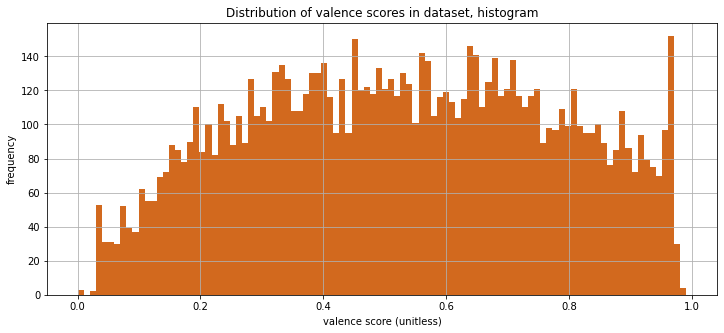

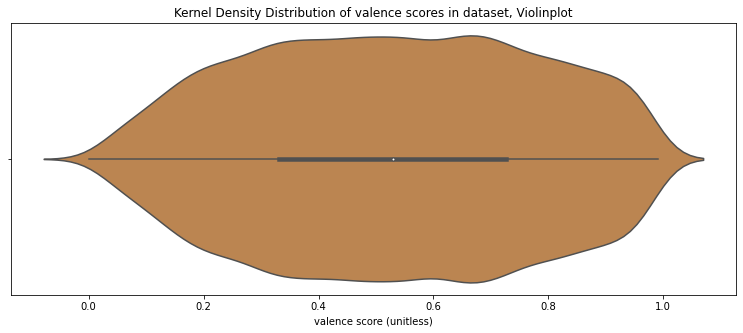

In [ ]:
#Distribution of songs' valence score (unitless)
data.hist(['valence'],bins=100, figsize=(12,5), color='chocolate')
plt.title('Distribution of valence scores in dataset, histogram')
plt.xlabel('valence score (unitless)')
plt.ylabel('frequency')
plt.plot()

plt.figure(figsize=(13,5))
sns.violinplot(data.valence, color='peru')
plt.title('Kernel Density Distribution of valence scores in dataset, Violinplot')
plt.xlabel('valence score (unitless)')
plt.plot()
data.valence.describe()

### 1.2.2 Scatter Matrix and correlation coefficients of Meta data

In this section we analyzed the correlation coefficients of Meta data vs. valence and illustrated the correlations in the scatter matrix below. From the scatter matrix and the correlation values table we observed the following: 

- danceability vs. valence: The correlation coefficient between danceability and valence was 0.467, and the relationship was a positive, linear and weak relationship. 

- energy vs. valence: The correlation coefficient between energy and valence was 0.351, and the relationship was a positive, linear and weaker relationship than danceability and valence relationship. 

- key vs. valence: The correlation coefficient between danceability and valence was 0.0393, and the relationship was positive, non-linear and weak relationsip. 

- loudness vs. valence: The correlation coefficient between loudness  and valence was 0.185, and the relationship was positive, linear, and weaker than the independent relationships of danceability and energy with valence, but stronger than the relationship of key and valence. 

- mode vs. valence: The correlation coefficient between mode and valence was -0.0167, and the relationship was negative, non-linear, and weak. 

- speechiness vs. valence: the correlation coefficient between speechiness and valence was 0.0368, and the relationship was a positive, linear, and weak. 

- acousticness vs. valence: The correlation coefficient between acousticness and valence was -0.191, and the relationship was negative, weak, and linear. 

- instrumentalness vs. valence: The correlation coefficient between instrumentalness and valence was -0.114, and the relationship was negative, linear, and weak. 

- liveness vs. valence: The correlation coefficient between liveness and valence was 0.0247, and the relationship was positive, linear, and weak. 



In [ ]:
meta_data = data[['valence', 'song_name', 'song_id', 'song_preview_url', 'artist_name', 'artist_uri',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness']]
print(meta_data.corr()) 

                   valence  danceability    energy       key  loudness  \
valence           1.000000      0.467038  0.350554  0.039308  0.185556   
danceability      0.467038      1.000000  0.127560  0.021555  0.142850   
energy            0.350554      0.127560  1.000000  0.027574  0.745165   
key               0.039308      0.021555  0.027574  1.000000  0.016827   
loudness          0.185556      0.142850  0.745165  0.016827  1.000000   
mode             -0.016703     -0.097510 -0.094342 -0.131094 -0.045101   
speechiness       0.036824      0.181954  0.114462  0.027243  0.032604   
acousticness     -0.191178     -0.206719 -0.701375 -0.027688 -0.540761   
instrumentalness -0.114938     -0.135818 -0.102325 -0.006435 -0.303008   
liveness          0.024756     -0.093232  0.165714 -0.010830  0.084339   

                      mode  speechiness  acousticness  instrumentalness  \
valence          -0.016703     0.036824     -0.191178         -0.114938   
danceability     -0.097510     0.18

[]

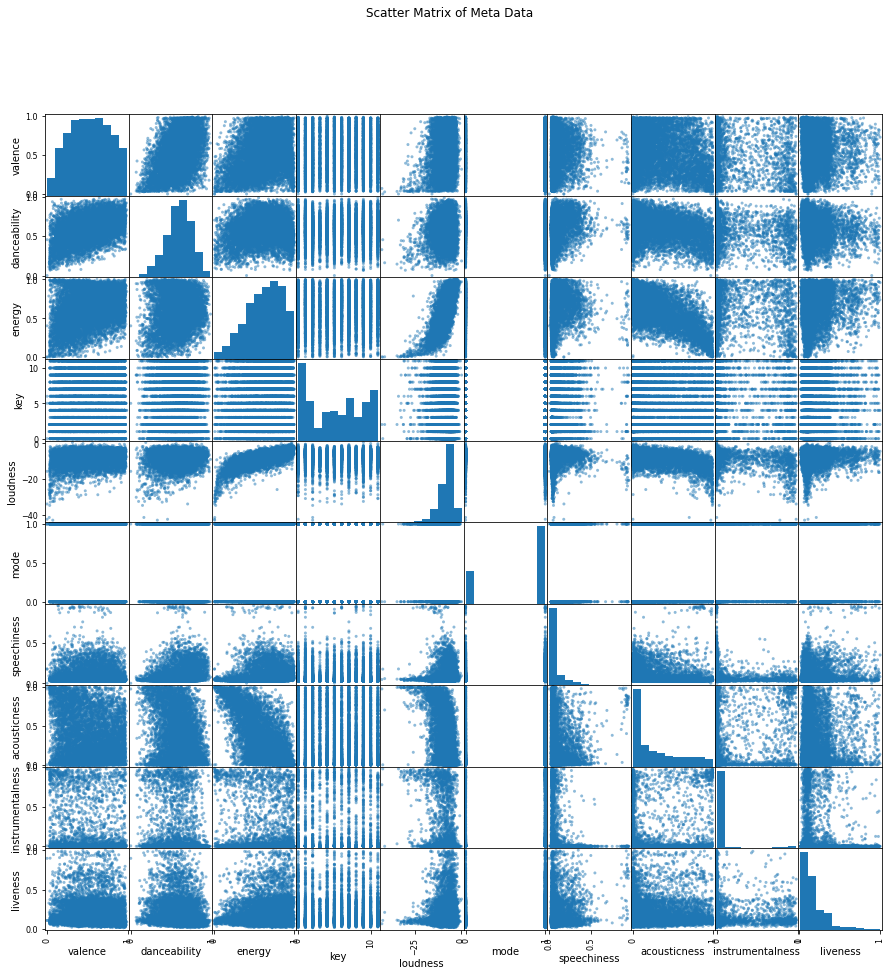

In [ ]:
#scatter plot of Meta Data
pd.plotting.scatter_matrix(meta_data,figsize=(15, 15))
plt.suptitle('Scatter Matrix of Meta Data')
plt.plot()

### 1.2.3 Top 10 Songs with Highest Valence Scores from Data


In [ ]:
from operator import index
top_10_v_index = list(data.valence.sort_values(ascending=False).head(10).index)

data[data.index.isin(top_10_v_index)][['song_name', 'song_id', 'artist_name', 'valence']]

,song_name,song_id,artist_name,valence
928,Pretty Little Baby,5KncckJB2N8tgih9MQ4rLN,Sexbomb Girls,0.986
2477,El Tucanazo,07Ag8vm1pW409NrhpPokFg,Los Tucanes de Tijuana,0.991
4872,Jingle Bells,4azDuDe8PjqFEFN1G842nM,Ray Price,0.980
6845,Rooftop Animals,7i9rnJfVxwd34i7v6q63sS,Shea Seger,0.979
6909,She Works Hard For The Money,3FlOciKDqFlTMPeC7t92Qy,Donna Summer,0.984
7167,Hot Hot Hot,4SvqOv6mufSZ5j0s5HFlBO,Latin Spice Band,0.977
8029,Las Edades,7rCcgP1xr0XOWWOiO0AjPW,Roberto Tapia,0.982
8840,Material Girl,22sLuJYcvZOSoLLRYev1s5,Madonna,0.978
9036,Mentirosa,5066HgfJfnRR0BKyS7pbgh,El Dasa,0.978
9375,El Águila Blanca,0crJsMs5FmnMHvQG1itkc0,Los Tucanes de Tijuana,0.977


### 1.2.3 Top 10 Songs with Lowest Valence Scores from Data

In [ ]:

top_low_10_v_index = list(data.valence.sort_values(ascending=True).head(10).index)

data[data.index.isin(top_low_10_v_index)][['song_name', 'song_id', 'artist_name', 'valence']]

,song_name,song_id,artist_name,valence
700,"Rigoletto / Act 3: ""La donna è mobile"" - Live",4mZlQk9Ha7WwJZUngARQeY,Luciano Pavarotti,0.0000
1654,searching for forgiveness,4zRHX4MKKVHI4dZajt9wfV,Anthony Andrews,0.0314
2306,5.17,7i8wAKUOcb9BWK50mFOOHU,Thom Yorke,0.0319
2764,Soothing Sea Breeze - 3D,5dHDv53vw1bP4yverJAMS7,B Coolin,0.0228
4130,Waves,6GFQjqMi2lm5NqkWipKBrv,Michael Moore,0.0324
5262,Interstellar No. 2,5Smqz9IQwRs2WfcNSvRWUs,Karlheinz Stockhausen,0.0000
6297,Stimmung: Model 1,579N7zju094gLfgMsflpFe,Karlheinz Stockhausen,0.0271
6500,Frihet,3c0hd9fVPI0UzqkI8zO5i7,AMS,0.0321
8310,Mélodies: I. L'invitation au voyage,7xJBX1E3UqXNpxNQH70FDx,Pascal Jourdan,0.0323
8522,Moraine,5Cqj6QVB1PCptFlVDRMTs6,Flavor Flav,0.0000


### 1.2.4 Pivot Table 1: Top 10 Artists with Highest Valence Scores, On Average

In [ ]:
pivot_1 = data.pivot_table(index='artist_name', values='valence', aggfunc=['mean', 'std', 'count'])
pivot_1.columns = ['mean', 'std', 'songs count']
pivot_1.sort_values('mean', ascending=False).head(10)

,mean,std,songs count
artist_name,,,
Robert Palmer,0.974500,0.000707,2
Sierra Hull,0.970000,NaN,1
Donna Summer,0.968333,0.013577,3
Grandpa Jones,0.965000,0.007071,2
Killer Mike,0.964000,NaN,1
P-Square,0.963000,NaN,1
Banda El Recodo,0.962500,0.002121,2
Jack Johnson,0.962000,NaN,1
Lionel Hampton,0.960000,NaN,1


### 1.2.5 Pivot table 2: Top 10 Artists with the Lowest Valence Score, On Average

In [ ]:
pivot_2 = data.pivot_table(index='artist_name', values='valence', aggfunc=['mean', 'std', 'count'])
pivot_2.columns = ['mean', 'std', 'songs count']
pivot_2.sort_values('mean', ascending=True).head(10)

,mean,std,songs count
artist_name,,,
B Coolin,0.02280,NaN,1
Pascal Jourdan,0.03535,0.002223,4
Everett Firth,0.03670,NaN,1
AMS,0.03772,0.004201,5
Chris Welch,0.03830,0.000265,3
Billy Montana,0.04350,NaN,1
Karlheinz Stockhausen,0.04710,0.051916,5
Wolfgang Muermann,0.05650,NaN,1
Berlin,0.05860,NaN,1


## 1.3 Model Training

In this section, we trained and validated the following models: 

| Model Number | Name of Model  | Description of Features Used in Model |
| --- | --- | --- |
| Model 0. | Linear Regression  | All Features |
|  Model 0.b   |   Linear Regression  |  Without Meta Features     |
|   Model 0.c  |  Linear Regression   |   Meta Features Only    |
|  Model 0.d   |  Linear Regresion   |  Normalized Features     |
|  Model 1   |   RandomForestRegressor  |  All Features     |
|  Model 1.b   | RandomForestRegressor    |   Without Meta Features    |
| Model 1.c    |   RandomForestRegresor  |  Meta Features Only     |
|  Model 1.d   | RandomForestRegressor    |  Normalized Features     |
|   Model 2  |   XGBoost Regressor  |   All Features    |
|  Model 2.b   |   XGBoost Regressor  |  Without Meta Features      |
| Model 2.c    |   XGBoost Regressor  |     Meta Features Only  |
|  Model 2.d   |  XGBoost Regressor   |  Normalized Features     |
|  Model 3   |   Support Vector Regressor  |   All Features    |
| Model 3.b    |  Support Vector Regressor   |   Without Meta Features    |
|  Model 3.c   |  Support Vector Regressor    |    Meta Featurest Only   |
|   Model 3.d  |  Support Vector Regressor   |    Normalized Features   |
|  Model 4.   |  K-Nearest Neighbors Regressor   |   All Features    |
|   Model 4.b  |  K-Nearest Neighbors Regressors   |  Without Meta Features     |
|   Model 4.c  |  K-Nearest Neighbors Regressor   |   Meta Features Only    |
|  Model 4.d   |  K-Nearest Neighbours Regressor   |  Normalized Features     |


We used RandomSearchCV to tune out models, and selected the best model, that had the smallest RMSE score with valdiations data, for testing with test data.






In [ ]:
#libraries used for training
from sklearn.linear_model import LinearRegression as lr
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler

### 1.3.1 Model 0: Linear Regression Model

In [ ]:
# splitting dataset into training, validation and testing datasets 
features_0 = data.drop(['song_name', 'song_id', 'song_preview_url', 'artist_name', 'artist_uri', 'valence'], axis=1)
target_0 = data['valence']

features_train_0, features_rest_0, target_train_0, target_rest_0 = train_test_split(features_0, target_0, test_size=0.40, random_state=12345)

features_valid_0, features_test_0, target_valid_0, target_test_0 = train_test_split(features_rest_0, target_rest_0, test_size=0.50, random_state=12345)

#printing dimensions of datasets 
print('features training', features_train_0.shape)
print('features validation', features_valid_0.shape)
print('features test', features_test_0.shape)
print()
print('target training', target_train_0.shape)
print('target validation', target_valid_0.shape)
print('target test', target_test_0.shape)

features training (5843, 190)
features validation (1948, 190)
features test (1948, 190)

target training (5843,)
target validation (1948,)
target test (1948,)


In [ ]:
model_0 = lr()
model_0.fit(features_train_0, target_train_0)
predicted_0 = model_0.predict(features_valid_0)


mse_0 = mean_squared_error(predicted_0, target_valid_0)
rmse_0 = math.sqrt(mse_0)
mae_0 = mean_absolute_error(predicted_0, target_valid_0)
print('mae_1 :', mae_0)
print('rmse_1 :', rmse_0)

mae_1 : 0.13033414152992082
rmse_1 : 0.16177413268006724


### 1.3.1b Model 0b: Linear Regression Model, without Meta Data

In [ ]:
# splitting dataset into training, validation and testing datasets 
features_0b = data.drop(['song_name', 'song_id', 'song_preview_url', 'artist_name', 'artist_uri',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence',
       'duration_ms', 'time_signature'], axis=1)

target_0b = data['valence']

features_train_0b, features_rest_0b, target_train_0b, target_rest_0b = train_test_split(features_0b, target_0b,
                                                                                        test_size=0.40, random_state=12345)

features_valid_0b, features_test_0b, target_valid_0b, target_test_0b = train_test_split(features_rest_0b, target_rest_0b, 
                                                                                        test_size=0.50, random_state=12345)

#printing dimensions of datasets 
print('features training', features_train_0b.shape)
print('features validation', features_valid_0b.shape)
print('features test', features_test_0b.shape)
print()
print('target training', target_train_0b.shape)
print('target validation', target_valid_0b.shape)
print('target test', target_test_0b.shape)

features training (5843, 179)
features validation (1948, 179)
features test (1948, 179)

target training (5843,)
target validation (1948,)
target test (1948,)


In [ ]:
model_0b = lr()
model_0b.fit(features_train_0b, target_train_0b)
predicted_0b = model_0b.predict(features_valid_0b)


mse_0b = mean_squared_error(predicted_0b, target_valid_0b)
rmse_0b = math.sqrt(mse_0b)
mae_0b = mean_absolute_error(predicted_0b, target_valid_0b)
print('mae_1 :', mae_0b)
print('rmse_1 :', rmse_0b)

mae_1 : 0.14667514429890635
rmse_1 : 0.18203281230819507


### 1.3.1c Model 1c: Linear Regression Model, Meta Data Only

In [ ]:
# splitting dataset into training, validation and testing datasets 
features_0c = data[['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness',
       'duration_ms', 'time_signature']]

target_0c = data['valence']

features_train_0c, features_rest_0c, target_train_0c, target_rest_0c = train_test_split(features_0c, target_0c,
                                                                                        test_size=0.40, random_state=12345)

features_valid_0c, features_test_0c, target_valid_0c, target_test_0c = train_test_split(features_rest_0c, target_rest_0c, 
                                                                                        test_size=0.50, random_state=12345)

#printing dimensions of datasets 
print('features training', features_train_0c.shape)
print('features validation', features_valid_0c.shape)
print('features test', features_test_0c.shape)
print()
print('target training', target_train_0c.shape)
print('target validation', target_valid_0c.shape)
print('target test', target_test_0c.shape)

features training (5843, 11)
features validation (1948, 11)
features test (1948, 11)

target training (5843,)
target validation (1948,)
target test (1948,)


In [ ]:
model_0c = lr()
model_0c.fit(features_train_0c, target_train_0c)
predicted_0c = model_0c.predict(features_valid_0c)


mse_0c = mean_squared_error(predicted_0c, target_valid_0c)
rmse_0c = math.sqrt(mse_0c)
mae_0c = mean_absolute_error(predicted_0c, target_valid_0c)
print('mae_1 :', mae_0c)
print('rmse_1 :', rmse_0c)

mae_1 : 0.15759839602870185
rmse_1 : 0.1924220318497026


### 1.3.1d Model 0d: Linear Regression Model, Nomalized Features

In [ ]:
# splitting dataset into training, validation and testing datasets 
features_0d = data.drop(['song_name', 'song_id', 'song_preview_url', 'artist_name', 'artist_uri', 'valence'], axis=1)
target_0d = data['valence']

scaler_0d = StandardScaler()
scaler_0d.fit(features_0d)

features_norm_0d = scaler_0d.transform(features_0d)

features_train_0d, features_rest_0d, target_train_0d, target_rest_0d = train_test_split(features_norm_0d, target_0d, test_size=0.40, random_state=12345)

features_valid_0d, features_test_0d, target_valid_0d, target_test_0d = train_test_split(features_rest_0d, target_rest_0d, test_size=0.50, random_state=12345)

#printing dimensions of datasets 
print('features training', features_train_0d.shape)
print('features validation', features_valid_0d.shape)
print('features test', features_test_0d.shape)
print()
print('target training', target_train_0d.shape)
print('target validation', target_valid_0d.shape)
print('target test', target_test_0d.shape)

features training (5843, 190)
features validation (1948, 190)
features test (1948, 190)

target training (5843,)
target validation (1948,)
target test (1948,)


In [ ]:
model_0d = lr()
model_0d.fit(features_train_0d, target_train_0d)
predicted_0d = model_0d.predict(features_valid_0d)


mse_0d = mean_squared_error(predicted_0d, target_valid_0d)
rmse_0d = math.sqrt(mse_0d)
mae_0d = mean_absolute_error(predicted_0d, target_valid_0d)
print('mae_1 :', mae_0d)
print('rmse_1 :', rmse_0d)

mae_1 : 0.13033414150417186
rmse_1 : 0.161774132675088


### 1.3.2 Model_1 RandomForestRegressor Model

In [ ]:
# splitting dataset into training, validation and testing datasets 
features_1 = data.drop(['song_name', 'song_id', 'song_preview_url', 'artist_name', 'artist_uri', 'valence'], axis=1)
target_1 = data['valence']

features_train_1, features_rest_1, target_train_1, target_rest_1 = train_test_split(features_1, target_1, 
                                                                                    test_size=0.40, random_state=12345)

features_valid_1, features_test_1, target_valid_1, target_test_1 = train_test_split(features_rest_1, target_rest_1,
                                                                                    test_size=0.50, random_state=12345)

#printing dimensions of datasets 
print('features training', features_train_1.shape)
print('features validation', features_valid_1.shape)
print('features test', features_test_1.shape)
print()
print('target training', target_train_1.shape)
print('target validation', target_valid_1.shape)
print('target test', target_test_1.shape)

features training (5843, 190)
features validation (1948, 190)
features test (1948, 190)

target training (5843,)
target validation (1948,)
target test (1948,)


In [ ]:
#using GridSearchCV for hyper parameter tuning 

params_1 = {'n_estimators': list(np.arange(58,108,1)), 
          'max_depth': list(range(4,20)),
          'min_samples_split' : list(range(1,15)),
          'min_samples_leaf' : list(np.arange(1,7,1))
          }

In [ ]:
model_1 = RandomForestRegressor(random_state=12345)
rscv_1 = RandomizedSearchCV(estimator=model_1, param_distributions = params_1, cv=5, verbose=2, scoring = 'neg_root_mean_squared_error')
rscv_1.fit(features_train_1, target_train_1)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=19, min_samples_leaf=3, min_samples_split=13, n_estimators=70; total time=  30.1s
[CV] END max_depth=19, min_samples_leaf=3, min_samples_split=13, n_estimators=70; total time=  30.8s
[CV] END max_depth=19, min_samples_leaf=3, min_samples_split=13, n_estimators=70; total time=  29.1s
[CV] END max_depth=19, min_samples_leaf=3, min_samples_split=13, n_estimators=70; total time=  29.1s
[CV] END max_depth=19, min_samples_leaf=3, min_samples_split=13, n_estimators=70; total time=  29.3s
[CV] END max_depth=19, min_samples_leaf=5, min_samples_split=6, n_estimators=69; total time=  28.8s
[CV] END max_depth=19, min_samples_leaf=5, min_samples_split=6, n_estimators=69; total time=  28.5s
[CV] END max_depth=19, min_samples_leaf=5, min_samples_split=6, n_estimators=69; total time=  27.9s
[CV] END max_depth=19, min_samples_leaf=5, min_samples_split=6, n_estimators=69; total time=  28.1s
[CV] END max_depth=19, min_samples

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py", line 450, in fit
    trees = Parallel(
  File "/usr/local/lib/python3.8/dist-packages/joblib/parallel.py", line 1085, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.8/dist-packages/joblib/parallel.py", l

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=12345),
                   param_distributions={'max_depth': [4, 5, 6, 7, 8, 9, 10, 11,
                                                      12, 13, 14, 15, 16, 17,
                                                      18, 19],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6],
                                        'min_samples_split': [1, 2, 3, 4, 5, 6,
                                                              7, 8, 9, 10, 11,
                                                              12, 13, 14],
                                        'n_estimators': [58, 59, 60, 61, 62, 63,
                                                         64, 65, 66, 67, 68, 69,
                                                         70, 71, 72, 73, 74, 75,
                                                         76, 77, 78, 79, 80, 81,
                                                         82, 83

In [ ]:
rscv_1.best_params_

{'n_estimators': 69,
 'min_samples_split': 6,
 'min_samples_leaf': 5,
 'max_depth': 19}

In [ ]:
model_1v = RandomForestRegressor(random_state=12345,
                                 n_estimators = rscv_1.best_params_['n_estimators'],
                                 min_samples_split = rscv_1.best_params_['min_samples_split'],
                                 min_samples_leaf = rscv_1.best_params_['min_samples_leaf'],
                                 max_depth = rscv_1.best_params_['max_depth'])

model_1v.fit(features_train_1, target_train_1)
predicted_1 = model_1v.predict(features_valid_1)
rmse_1 = math.sqrt(mean_squared_error(predicted_1, target_valid_1))
mae_1 = mean_absolute_error(predicted_1, target_valid_1)

print('mae_1 :', mae_1)
print('rmse_1 :', rmse_1)

mae_1 : 0.1331040783320198
rmse_1 : 0.16459507619315245


### 1.3.2b Model_1b RandomForestRegressor Model, Without Meta Data

In [ ]:
# splitting dataset into training, validation and testing datasets 
features_1b = data.drop(['song_name', 'song_id', 'song_preview_url', 'artist_name', 'artist_uri',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence',
       'duration_ms', 'time_signature'], axis=1)

target_1b = data['valence']

features_train_1b, features_rest_1b, target_train_1b, target_rest_1b = train_test_split(features_1b, target_1b,
                                                                                        test_size=0.40, random_state=12345)

features_valid_1b, features_test_1b, target_valid_1b, target_test_1b = train_test_split(features_rest_1b, target_rest_1b, 
                                                                                        test_size=0.50, random_state=12345)

#printing dimensions of datasets 
print('features training', features_train_1b.shape)
print('features validation', features_valid_1b.shape)
print('features test', features_test_1b.shape)
print()
print('target training', target_train_1b.shape)
print('target validation', target_valid_1b.shape)
print('target test', target_test_1b.shape)

features training (5843, 179)
features validation (1948, 179)
features test (1948, 179)

target training (5843,)
target validation (1948,)
target test (1948,)


In [ ]:
#using GridSearchCV for hyper parameter tuning 

params_1b = {'n_estimators': list(np.arange(58,108,1)), 
          'max_depth': list(range(4,20)),
          'min_samples_split' : list(range(1,15)),
          'min_samples_leaf' : list(np.arange(1,7,1))
          }

In [ ]:
model_1b = RandomForestRegressor(random_state=12345)
rscv_1b = RandomizedSearchCV(estimator=model_1b, param_distributions = params_1b, cv=5, verbose=2, scoring = 'neg_root_mean_squared_error')
rscv_1b.fit(features_train_1b, target_train_1b)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=16, min_samples_leaf=2, min_samples_split=2, n_estimators=73; total time=  32.5s
[CV] END max_depth=16, min_samples_leaf=2, min_samples_split=2, n_estimators=73; total time=  32.0s
[CV] END max_depth=16, min_samples_leaf=2, min_samples_split=2, n_estimators=73; total time=  31.8s
[CV] END max_depth=16, min_samples_leaf=2, min_samples_split=2, n_estimators=73; total time=  32.6s
[CV] END max_depth=16, min_samples_leaf=2, min_samples_split=2, n_estimators=73; total time=  32.3s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=11, n_estimators=63; total time=  14.2s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=11, n_estimators=63; total time=  14.2s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=11, n_estimators=63; total time=  14.1s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=11, n_estimators=63; total time=  14.1s
[CV] END max_depth=5, min_samples_leaf=

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py", line 450, in fit
    trees = Parallel(
  File "/usr/local/lib/python3.8/dist-packages/joblib/parallel.py", line 1085, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.8/dist-packages/joblib/parallel.py", lin

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=12345),
                   param_distributions={'max_depth': [4, 5, 6, 7, 8, 9, 10, 11,
                                                      12, 13, 14, 15, 16, 17,
                                                      18, 19],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6],
                                        'min_samples_split': [1, 2, 3, 4, 5, 6,
                                                              7, 8, 9, 10, 11,
                                                              12, 13, 14],
                                        'n_estimators': [58, 59, 60, 61, 62, 63,
                                                         64, 65, 66, 67, 68, 69,
                                                         70, 71, 72, 73, 74, 75,
                                                         76, 77, 78, 79, 80, 81,
                                                         82, 83

In [ ]:
rscv_1b.best_params_

{'n_estimators': 102,
 'min_samples_split': 4,
 'min_samples_leaf': 1,
 'max_depth': 17}

In [ ]:
model_1vb = RandomForestRegressor(random_state=12345,
                                 n_estimators = rscv_1b.best_params_['n_estimators'],
                                 min_samples_split = rscv_1b.best_params_['min_samples_split'],
                                 min_samples_leaf = rscv_1b.best_params_['min_samples_leaf'],
                                 max_depth = rscv_1b.best_params_['max_depth'])

model_1vb.fit(features_train_1b, target_train_1b)
predicted_1b = model_1vb.predict(features_valid_1b)
rmse_1b = math.sqrt(mean_squared_error(predicted_1b, target_valid_1b))
mae_1b = mean_absolute_error(predicted_1b, target_valid_1b)

print('mae_1b :', mae_1b)
print('rmse_1b :', rmse_1b)

mae_1b : 0.13939074705397864
rmse_1b : 0.1720164930687585


### 1.3.2c Model 1c Random Forest Regressor, Only Meta Data

In [ ]:
# splitting dataset into training, validation and testing datasets 
features_1c = data[['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness',
       'duration_ms', 'time_signature']]

target_1c = data['valence']

features_train_1c, features_rest_1c, target_train_1c, target_rest_1c = train_test_split(features_1c, target_1c,
                                                                                        test_size=0.40, random_state=12345)

features_valid_1c, features_test_1c, target_valid_1c, target_test_1c = train_test_split(features_rest_1c, target_rest_1c, 
                                                                                        test_size=0.50, random_state=12345)

#printing dimensions of datasets 
print('features training', features_train_1c.shape)
print('features validation', features_valid_1c.shape)
print('features test', features_test_1c.shape)
print()
print('target training', target_train_1c.shape)
print('target validation', target_valid_1c.shape)
print('target test', target_test_1c.shape)

features training (5843, 11)
features validation (1948, 11)
features test (1948, 11)

target training (5843,)
target validation (1948,)
target test (1948,)


In [ ]:
#using GridSearchCV for hyper parameter tuning 

params_1c = {'n_estimators': list(np.arange(58,108,1)), 
          'max_depth': list(range(4,20)),
          'min_samples_split' : list(range(1,15)),
          'min_samples_leaf' : list(np.arange(1,7,1))
          }

In [ ]:
model_1c = RandomForestRegressor(random_state=12345)
rscv_1c = RandomizedSearchCV(estimator=model_1c, param_distributions = params_1c, cv=5, verbose=2, scoring = 'neg_root_mean_squared_error')
rscv_1c.fit(features_train_1c, target_train_1c)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=18, min_samples_leaf=4, min_samples_split=9, n_estimators=81; total time=   1.6s
[CV] END max_depth=18, min_samples_leaf=4, min_samples_split=9, n_estimators=81; total time=   1.6s
[CV] END max_depth=18, min_samples_leaf=4, min_samples_split=9, n_estimators=81; total time=   1.6s
[CV] END max_depth=18, min_samples_leaf=4, min_samples_split=9, n_estimators=81; total time=   1.6s
[CV] END max_depth=18, min_samples_leaf=4, min_samples_split=9, n_estimators=81; total time=   1.6s
[CV] END max_depth=18, min_samples_leaf=2, min_samples_split=12, n_estimators=62; total time=   1.3s
[CV] END max_depth=18, min_samples_leaf=2, min_samples_split=12, n_estimators=62; total time=   1.3s
[CV] END max_depth=18, min_samples_leaf=2, min_samples_split=12, n_estimators=62; total time=   1.2s
[CV] END max_depth=18, min_samples_leaf=2, min_samples_split=12, n_estimators=62; total time=   1.2s
[CV] END max_depth=18, min_samples_

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py", line 450, in fit
    trees = Parallel(
  File "/usr/local/lib/python3.8/dist-packages/joblib/parallel.py", line 1085, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.8/dist-packages/joblib/parallel.py", l

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=12345),
                   param_distributions={'max_depth': [4, 5, 6, 7, 8, 9, 10, 11,
                                                      12, 13, 14, 15, 16, 17,
                                                      18, 19],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6],
                                        'min_samples_split': [1, 2, 3, 4, 5, 6,
                                                              7, 8, 9, 10, 11,
                                                              12, 13, 14],
                                        'n_estimators': [58, 59, 60, 61, 62, 63,
                                                         64, 65, 66, 67, 68, 69,
                                                         70, 71, 72, 73, 74, 75,
                                                         76, 77, 78, 79, 80, 81,
                                                         82, 83

In [ ]:
rscv_1c.best_params_

{'n_estimators': 101,
 'min_samples_split': 5,
 'min_samples_leaf': 6,
 'max_depth': 15}

In [ ]:
model_1vc = RandomForestRegressor(random_state=12345,
                                 n_estimators = rscv_1c.best_params_['n_estimators'],
                                 min_samples_split = rscv_1c.best_params_['min_samples_split'],
                                 min_samples_leaf = rscv_1c.best_params_['min_samples_leaf'],
                                 max_depth = rscv_1c.best_params_['max_depth'])

model_1vc.fit(features_train_1c, target_train_1c)
predicted_1c = model_1vc.predict(features_valid_1c)
rmse_1c = math.sqrt(mean_squared_error(predicted_1c, target_valid_1c))
mae_1c = mean_absolute_error(predicted_1c, target_valid_1c)

print('mae_1c :', mae_1c)
print('rmse_1c :', rmse_1c)

mae_1c : 0.14769701214726907
rmse_1c : 0.18152791359015835


### 1.3.2d Model 1d Random Forest Regressor, Normalized Features

In [ ]:
# splitting dataset into training, validation and testing datasets 
features_1d = data.drop(['song_name', 'song_id', 'song_preview_url', 'artist_name', 'artist_uri', 'valence'], axis=1)
target_1d = data['valence']

scaler_1d = StandardScaler()
scaler_1d.fit(features_1d)
features_norm_1d = scaler_1d.transform(features_1d)

features_train_1d, features_rest_1d, target_train_1d, target_rest_1d = train_test_split(features_norm_1d, target_1d, 
                                                                                        test_size=0.40, random_state=12345)

features_valid_1d, features_test_1d, target_valid_1d, target_test_1d = train_test_split(features_rest_1d, target_rest_1d,
                                                                                        test_size=0.50, random_state=12345)

#printing dimensions of datasets 
print('features training', features_train_1d.shape)
print('features validation', features_valid_1d.shape)
print('features test', features_test_1d.shape)
print()
print('target training', target_train_1d.shape)
print('target validation', target_valid_1d.shape)
print('target test', target_test_1d.shape)

features training (5843, 190)
features validation (1948, 190)
features test (1948, 190)

target training (5843,)
target validation (1948,)
target test (1948,)


In [ ]:
#using GridSearchCV for hyper parameter tuning 

params_1d = {'n_estimators': list(np.arange(58,108,1)), 
          'max_depth': list(range(4,20)),
          'min_samples_split' : list(range(1,15)),
          'min_samples_leaf' : list(np.arange(1,7,1))
          }

In [ ]:
model_1d = RandomForestRegressor(random_state=12345)
rscv_1d = RandomizedSearchCV(estimator=model_1d, param_distributions = params_1d, cv=5, verbose=2, scoring = 'neg_root_mean_squared_error')
rscv_1d.fit(features_train_1d, target_train_1d)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=14, min_samples_leaf=5, min_samples_split=1, n_estimators=102; total time=   0.0s
[CV] END max_depth=14, min_samples_leaf=5, min_samples_split=1, n_estimators=102; total time=   0.0s
[CV] END max_depth=14, min_samples_leaf=5, min_samples_split=1, n_estimators=102; total time=   0.0s
[CV] END max_depth=14, min_samples_leaf=5, min_samples_split=1, n_estimators=102; total time=   0.0s
[CV] END max_depth=14, min_samples_leaf=5, min_samples_split=1, n_estimators=102; total time=   0.0s
[CV] END max_depth=17, min_samples_leaf=5, min_samples_split=3, n_estimators=98; total time=  39.5s
[CV] END max_depth=17, min_samples_leaf=5, min_samples_split=3, n_estimators=98; total time=  39.2s
[CV] END max_depth=17, min_samples_leaf=5, min_samples_split=3, n_estimators=98; total time=  38.5s
[CV] END max_depth=17, min_samples_leaf=5, min_samples_split=3, n_estimators=98; total time=  38.7s
[CV] END max_depth=17, min_samples

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py", line 450, in fit
    trees = Parallel(
  File "/usr/local/lib/python3.8/dist-packages/joblib/parallel.py", line 1085, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.8/dist-packages/joblib/parallel.py", lin

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=12345),
                   param_distributions={'max_depth': [4, 5, 6, 7, 8, 9, 10, 11,
                                                      12, 13, 14, 15, 16, 17,
                                                      18, 19],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6],
                                        'min_samples_split': [1, 2, 3, 4, 5, 6,
                                                              7, 8, 9, 10, 11,
                                                              12, 13, 14],
                                        'n_estimators': [58, 59, 60, 61, 62, 63,
                                                         64, 65, 66, 67, 68, 69,
                                                         70, 71, 72, 73, 74, 75,
                                                         76, 77, 78, 79, 80, 81,
                                                         82, 83

In [ ]:
rscv_1d.best_params_

{'n_estimators': 98,
 'min_samples_split': 3,
 'min_samples_leaf': 5,
 'max_depth': 17}

In [ ]:
model_1vd = RandomForestRegressor(random_state=12345,
                                 n_estimators = rscv_1d.best_params_['n_estimators'],
                                 min_samples_split = rscv_1d.best_params_['min_samples_split'],
                                 min_samples_leaf = rscv_1d.best_params_['min_samples_leaf'],
                                 max_depth = rscv_1d.best_params_['max_depth'])

model_1vd.fit(features_train_1d, target_train_1d)
predicted_1d = model_1vd.predict(features_valid_1d)
rmse_1d = math.sqrt(mean_squared_error(predicted_1d, target_valid_1d))
mae_1d = mean_absolute_error(predicted_1d, target_valid_1d)

print('mae_1d :', mae_1d)
print('rmse_1d :', rmse_1d)

mae_1d : 0.1325653715839155
rmse_1d : 0.1639384515311493


### 1.3.3 Model_2 XGBoostRegressor Model

In [ ]:
# splitting dataset into training, validation and testing datasets 
features_2 = data.drop(['song_name', 'song_id', 'song_preview_url', 'artist_name', 'artist_uri', 'valence'], axis=1)
target_2 = data['valence']

features_train_2, features_rest_2, target_train_2, target_rest_2 = train_test_split(features_2, target_2, 
                                                                                    test_size=0.40, random_state=12345)

features_valid_2, features_test_2, target_valid_2, target_test_2 = train_test_split(features_rest_2, target_rest_2,
                                                                                    test_size=0.50, random_state=12345)

#printing dimensions of datasets 
print('features training', features_train_2.shape)
print('features validation', features_valid_2.shape)
print('features test', features_test_2.shape)
print()
print('target training', target_train_2.shape)
print('target validation', target_valid_2.shape)
print('target test', target_test_2.shape)

features training (5843, 190)
features validation (1948, 190)
features test (1948, 190)

target training (5843,)
target validation (1948,)
target test (1948,)


In [ ]:
#using RandomizedSearchCV for hyper parameter tuning 

params_2 = {'booster' : ['gbtree', 'gblinear'],
         'eta' : list(np.arange(0.01, 0.3, 0.01)),
         'max_depth': list(range(3,11)),
         'gamma': list(range(1,11)),
         'min_child_weight' : list(range(1,11))}

In [ ]:
model_2 = xgb.XGBRegressor(seed=12345)

rscv_2 = RandomizedSearchCV(estimator=model_2, param_distributions = params_2, cv=5, verbose=2, scoring = 'neg_root_mean_squared_error')
rscv_2.fit(features_train_2, target_train_2)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[16:34:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END booster=gbtree, eta=0.26, gamma=7, max_depth=10, min_child_weight=7; total time=  16.8s
[16:35:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END booster=gbtree, eta=0.26, gamma=7, max_depth=10, min_child_weight=7; total time=  16.3s
[16:35:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END booster=gbtree, eta=0.26, gamma=7, max_depth=10, min_child_weight=7; total time=  16.0s
[16:35:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END booster=gbtree, eta=0.26, gamma=7, max_depth=10, min_child_weight=7; total time=  15.9s
[16:35:48] WARNING: /workspace/src/objectiv

RandomizedSearchCV(cv=5, estimator=XGBRegressor(seed=12345),
                   param_distributions={'booster': ['gbtree', 'gblinear'],
                                        'eta': [0.01, 0.02, 0.03, 0.04, 0.05,
                                                0.060000000000000005,
                                                0.06999999999999999, 0.08, 0.09,
                                                0.09999999999999999, 0.11, 0.12,
                                                0.13, 0.14, 0.15000000000000002,
                                                0.16, 0.17, 0.18000000000000002,
                                                0.19, 0.2, 0.21000000000000002,
                                                0.22, 0.23, 0.24000000000000002,
                                                0.25, 0.26, 0.27, 0.28,
                                                0.29000000000000004],
                                        'gamma': [1, 2, 3, 4, 5, 6, 7, 8, 9,
            

In [ ]:
rscv_2.best_params_

{'min_child_weight': 9,
 'max_depth': 10,
 'gamma': 2,
 'eta': 0.15000000000000002,
 'booster': 'gbtree'}

In [ ]:
model_2v = xgb.XGBRegressor(seed=12345,
                            booster = rscv_2.best_params_['booster'],
                            eta = rscv_2.best_params_['eta'],
                            max_depth = rscv_2.best_params_['max_depth'],
                            gamma = rscv_2.best_params_['gamma'],
                            min_child_weight = rscv_2.best_params_['min_child_weight'])

model_2v.fit(features_train_2, target_train_2)
predicted_2 = model_2v.predict(features_valid_2)
rmse_2 = math.sqrt(mean_squared_error(predicted_2, target_valid_2))
mae_2 = mean_absolute_error(predicted_2, target_valid_2)

print('mae_2 :', mae_2)
print('rmse_2 :', rmse_2)

[16:42:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
mae_2 : 0.13952473152141553
rmse_2 : 0.17047525957383458


### 1.3.3b Model 2b XGBoostRegressor Model, Without Meta Data

In [ ]:
# splitting dataset into training, validation and testing datasets 
features_2b = data.drop(['song_name', 'song_id', 'song_preview_url', 'artist_name', 'artist_uri',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence',
       'duration_ms', 'time_signature'], axis=1)

target_2b = data['valence']

features_train_2b, features_rest_2b, target_train_2b, target_rest_2b = train_test_split(features_2b, target_2b,
                                                                                        test_size=0.40, random_state=12345)

features_valid_2b, features_test_2b, target_valid_2b, target_test_2b = train_test_split(features_rest_2b, target_rest_2b, 
                                                                                        test_size=0.50, random_state=12345)

#printing dimensions of datasets 
print('features training', features_train_2b.shape)
print('features validation', features_valid_2b.shape)
print('features test', features_test_2b.shape)
print()
print('target training', target_train_2b.shape)
print('target validation', target_valid_2b.shape)
print('target test', target_test_2b.shape)

features training (5843, 179)
features validation (1948, 179)
features test (1948, 179)

target training (5843,)
target validation (1948,)
target test (1948,)


In [ ]:
#using RandomizedSearchCV for hyper parameter tuning 

params_2b = {'booster' : ['gbtree', 'gblinear'],
         'eta' : list(np.arange(0.01, 0.3, 0.01)),
         'max_depth': list(range(3,11)),
         'gamma': list(range(1,11)),
         'min_child_weight' : list(range(1,11))}

In [ ]:
model_2b = xgb.XGBRegressor(seed=12345)

rscv_2b = RandomizedSearchCV(estimator=model_2b, param_distributions = params_2b, cv=5, verbose=2, scoring = 'neg_root_mean_squared_error')
rscv_2b.fit(features_train_2b, target_train_2b)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[16:42:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END booster=gbtree, eta=0.19, gamma=7, max_depth=4, min_child_weight=2; total time=   5.3s
[16:42:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END booster=gbtree, eta=0.19, gamma=7, max_depth=4, min_child_weight=2; total time=   5.8s
[16:42:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END booster=gbtree, eta=0.19, gamma=7, max_depth=4, min_child_weight=2; total time=   5.3s
[16:42:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END booster=gbtree, eta=0.19, gamma=7, max_depth=4, min_child_weight=2; total time=   5.6s
[16:43:04] WARNING: /workspace/src/objective/re

RandomizedSearchCV(cv=5, estimator=XGBRegressor(seed=12345),
                   param_distributions={'booster': ['gbtree', 'gblinear'],
                                        'eta': [0.01, 0.02, 0.03, 0.04, 0.05,
                                                0.060000000000000005,
                                                0.06999999999999999, 0.08, 0.09,
                                                0.09999999999999999, 0.11, 0.12,
                                                0.13, 0.14, 0.15000000000000002,
                                                0.16, 0.17, 0.18000000000000002,
                                                0.19, 0.2, 0.21000000000000002,
                                                0.22, 0.23, 0.24000000000000002,
                                                0.25, 0.26, 0.27, 0.28,
                                                0.29000000000000004],
                                        'gamma': [1, 2, 3, 4, 5, 6, 7, 8, 9,
            

In [ ]:
rscv_2b.best_params_

{'min_child_weight': 1,
 'max_depth': 4,
 'gamma': 1,
 'eta': 0.18000000000000002,
 'booster': 'gbtree'}

In [ ]:
model_2vb = xgb.XGBRegressor(seed=12345,
                            booster = rscv_2b.best_params_['booster'],
                            eta = rscv_2b.best_params_['eta'],
                            max_depth = rscv_2b.best_params_['max_depth'],
                            gamma = rscv_2b.best_params_['gamma'],
                            min_child_weight = rscv_2b.best_params_['min_child_weight'])

model_2vb.fit(features_train_2b, target_train_2b)
predicted_2b = model_2vb.predict(features_valid_2b)
rmse_2b = math.sqrt(mean_squared_error(predicted_2b, target_valid_2b))
mae_2b = mean_absolute_error(predicted_2b, target_valid_2b)

print('mae_2b :', mae_2b)
print('rmse_2b :', rmse_2b)

[16:45:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
mae_2b : 0.14109808681723518
rmse_2b : 0.17412317970977995


### 1.3.3c Model 2c XGBoostRegressor Model, Meta Data Only

In [ ]:
# splitting dataset into training, validation and testing datasets 
features_2c = data[['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness',
       'duration_ms', 'time_signature']]

target_2c = data['valence']

features_train_2c, features_rest_2c, target_train_2c, target_rest_2c = train_test_split(features_2c, target_2c,
                                                                                        test_size=0.40, random_state=12345)

features_valid_2c, features_test_2c, target_valid_2c, target_test_2c = train_test_split(features_rest_2c, target_rest_2c, 
                                                                                        test_size=0.50, random_state=12345)

#printing dimensions of datasets 
print('features training', features_train_2c.shape)
print('features validation', features_valid_2c.shape)
print('features test', features_test_2c.shape)
print()
print('target training', target_train_2c.shape)
print('target validation', target_valid_2c.shape)
print('target test', target_test_2c.shape)

features training (5843, 11)
features validation (1948, 11)
features test (1948, 11)

target training (5843,)
target validation (1948,)
target test (1948,)


In [ ]:
#using RandomizedSearchCV for hyper parameter tuning 

params_2c = {'booster' : ['gbtree', 'gblinear'],
         'eta' : list(np.arange(0.01, 0.3, 0.01)),
         'max_depth': list(range(3,11)),
         'gamma': list(range(1,11)),
         'min_child_weight' : list(range(1,11))}

In [ ]:
model_2c = xgb.XGBRegressor(seed=12345)

rscv_2c = RandomizedSearchCV(estimator=model_2c, param_distributions = params_2c, cv=5, verbose=2, scoring = 'neg_root_mean_squared_error')
rscv_2c.fit(features_train_2c, target_train_2c)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[16:45:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END booster=gbtree, eta=0.02, gamma=4, max_depth=6, min_child_weight=7; total time=   0.6s
[16:45:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END booster=gbtree, eta=0.02, gamma=4, max_depth=6, min_child_weight=7; total time=   0.6s
[16:45:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END booster=gbtree, eta=0.02, gamma=4, max_depth=6, min_child_weight=7; total time=   0.6s
[16:45:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END booster=gbtree, eta=0.02, gamma=4, max_depth=6, min_child_weight=7; total time=   0.6s
[16:45:14] WARNING: /workspace/src/objective/re

RandomizedSearchCV(cv=5, estimator=XGBRegressor(seed=12345),
                   param_distributions={'booster': ['gbtree', 'gblinear'],
                                        'eta': [0.01, 0.02, 0.03, 0.04, 0.05,
                                                0.060000000000000005,
                                                0.06999999999999999, 0.08, 0.09,
                                                0.09999999999999999, 0.11, 0.12,
                                                0.13, 0.14, 0.15000000000000002,
                                                0.16, 0.17, 0.18000000000000002,
                                                0.19, 0.2, 0.21000000000000002,
                                                0.22, 0.23, 0.24000000000000002,
                                                0.25, 0.26, 0.27, 0.28,
                                                0.29000000000000004],
                                        'gamma': [1, 2, 3, 4, 5, 6, 7, 8, 9,
            

In [ ]:
rscv_2c.best_params_

In [ ]:
model_2vc = xgb.XGBRegressor(seed=12345,
                            booster = rscv_2c.best_params_['booster'],
                            eta = rscv_2c.best_params_['eta'],
                            max_depth = rscv_2c.best_params_['max_depth'],
                            gamma = rscv_2c.best_params_['gamma'],
                            min_child_weight = rscv_2c.best_params_['min_child_weight'])

model_2vc.fit(features_train_2c, target_train_2c)
predicted_2c = model_2vc.predict(features_valid_2c)
rmse_2c = math.sqrt(mean_squared_error(predicted_2c, target_valid_2c))
mae_2c = mean_absolute_error(predicted_2c, target_valid_2c)

print('mae_2c :', mae_2c)
print('rmse_2c :', rmse_2c)

### 1.3.3d Model 2d  XGBoostRegressor Model, Normalized Features

In [ ]:
# splitting dataset into training, validation and testing datasets 
features_2d = data.drop(['song_name', 'song_id', 'song_preview_url', 'artist_name', 'artist_uri', 'valence'], axis=1)
target_2d = data['valence']

scaler_2d = StandardScaler()
scaler_2d.fit(features_2d)
features_norm_2d = scaler_2d.transform(features_2d)

features_train_2d, features_rest_2d, target_train_2d, target_rest_2d = train_test_split(features_norm_2d, target_2d, 
                                                                                        test_size=0.40, random_state=12345)

features_valid_2d, features_test_2d, target_valid_2d, target_test_2d = train_test_split(features_rest_2d, target_rest_2d,
                                                                                        test_size=0.50, random_state=12345)

#printing dimensions of datasets 
print('features training', features_train_2d.shape)
print('features validation', features_valid_2d.shape)
print('features test', features_test_2d.shape)
print()
print('target training', target_train_2d.shape)
print('target validation', target_valid_2d.shape)
print('target test', target_test_2d.shape)

In [ ]:
#using RandomizedSearchCV for hyper parameter tuning 

params_2d = {'booster' : ['gbtree', 'gblinear'],
         'eta' : list(np.arange(0.01, 0.3, 0.01)),
         'max_depth': list(range(3,11)),
         'gamma': list(range(1,11)),
         'min_child_weight' : list(range(1,11))}

In [ ]:
model_2d = xgb.XGBRegressor(seed=12345)

rscv_2d = RandomizedSearchCV(estimator=model_2d, param_distributions = params_2d, cv=5, verbose=2, scoring = 'neg_root_mean_squared_error')
rscv_2d.fit(features_train_2d, target_train_2d)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[16:45:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END booster=gbtree, eta=0.03, gamma=3, max_depth=9, min_child_weight=9; total time=  14.0s
[16:45:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END booster=gbtree, eta=0.03, gamma=3, max_depth=9, min_child_weight=9; total time=  14.7s
[16:46:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END booster=gbtree, eta=0.03, gamma=3, max_depth=9, min_child_weight=9; total time=  14.7s
[16:46:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END booster=gbtree, eta=0.03, gamma=3, max_depth=9, min_child_weight=9; total time=  14.0s
[16:46:32] WARNING: /workspace/src/objective/re

RandomizedSearchCV(cv=5, estimator=XGBRegressor(seed=12345),
                   param_distributions={'booster': ['gbtree', 'gblinear'],
                                        'eta': [0.01, 0.02, 0.03, 0.04, 0.05,
                                                0.060000000000000005,
                                                0.06999999999999999, 0.08, 0.09,
                                                0.09999999999999999, 0.11, 0.12,
                                                0.13, 0.14, 0.15000000000000002,
                                                0.16, 0.17, 0.18000000000000002,
                                                0.19, 0.2, 0.21000000000000002,
                                                0.22, 0.23, 0.24000000000000002,
                                                0.25, 0.26, 0.27, 0.28,
                                                0.29000000000000004],
                                        'gamma': [1, 2, 3, 4, 5, 6, 7, 8, 9,
            

In [ ]:
rscv_2d.best_params_

{'min_child_weight': 10,
 'max_depth': 3,
 'gamma': 1,
 'eta': 0.15000000000000002,
 'booster': 'gbtree'}

In [ ]:
model_2vd = xgb.XGBRegressor(seed=12345,
                            booster = rscv_2d.best_params_['booster'],
                            eta = rscv_2d.best_params_['eta'],
                            max_depth = rscv_2d.best_params_['max_depth'],
                            gamma = rscv_2d.best_params_['gamma'],
                            min_child_weight = rscv_2d.best_params_['min_child_weight'])

model_2vd.fit(features_train_2d, target_train_2d)
predicted_2d = model_2vd.predict(features_valid_2d)
rmse_2d = math.sqrt(mean_squared_error(predicted_2d, target_valid_2d))
mae_2d = mean_absolute_error(predicted_2d, target_valid_2d)

print('mae_2d :', mae_2d)
print('rmse_2d :', rmse_2d)

[16:49:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
mae_2d : 0.13323017151355745
rmse_2d : 0.16466036869837442


### 1.3.4 Model_3 Support Vector Regressor

In [ ]:
# splitting dataset into training, validation and testing datasets 
features_3 = data.drop(['song_name', 'song_id', 'song_preview_url', 'artist_name', 'artist_uri', 'valence'], axis=1)
target_3 = data['valence']

features_train_3, features_rest_3, target_train_3, target_rest_3 = train_test_split(features_3, target_3, 
                                                                                    test_size=0.40, random_state=12345)

features_valid_3, features_test_3, target_valid_3, target_test_3 = train_test_split(features_rest_3, target_rest_3,
                                                                                    test_size=0.50, random_state=12345)

#printing dimensions of datasets 
print('features training', features_train_3.shape)
print('features validation', features_valid_3.shape)
print('features test', features_test_3.shape)
print()
print('target training', target_train_3.shape)
print('target validation', target_valid_3.shape)
print('target test', target_test_3.shape)

features training (5843, 190)
features validation (1948, 190)
features test (1948, 190)

target training (5843,)
target validation (1948,)
target test (1948,)


In [ ]:
#using RandomizedSearchCV for hyper parameter tuning 

params_3 = {'kernel' : ['rbf'],
            'gamma' : list(np.arange(0.001, 10.1, 0.1)),
            'C' : list(np.arange(0.1, 100.1, 0.1)),
            'epsilon' : list(np.arange(0.1, 0.5, 0.1))}

params_3['gamma'].append('scale')
params_3['gamma'].append('auto')


In [ ]:
model_3 = SVR()

rscv_3 = RandomizedSearchCV(estimator=model_3, param_distributions = params_3, cv=5, verbose=2, scoring = 'neg_root_mean_squared_error')
rscv_3.fit(features_train_3, target_train_3)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END C=45.50000000000001, epsilon=0.30000000000000004, gamma=7.801000000000001, kernel=rbf; total time=   0.9s
[CV] END C=45.50000000000001, epsilon=0.30000000000000004, gamma=7.801000000000001, kernel=rbf; total time=   0.8s
[CV] END C=45.50000000000001, epsilon=0.30000000000000004, gamma=7.801000000000001, kernel=rbf; total time=   0.9s
[CV] END C=45.50000000000001, epsilon=0.30000000000000004, gamma=7.801000000000001, kernel=rbf; total time=   0.9s
[CV] END C=45.50000000000001, epsilon=0.30000000000000004, gamma=7.801000000000001, kernel=rbf; total time=   0.9s
[CV] END .......C=73.6, epsilon=0.4, gamma=9.601, kernel=rbf; total time=   0.3s
[CV] END .......C=73.6, epsilon=0.4, gamma=9.601, kernel=rbf; total time=   0.3s
[CV] END .......C=73.6, epsilon=0.4, gamma=9.601, kernel=rbf; total time=   0.3s
[CV] END .......C=73.6, epsilon=0.4, gamma=9.601, kernel=rbf; total time=   0.3s
[CV] END .......C=73.6, epsilon=0.4, gam

RandomizedSearchCV(cv=5, estimator=SVR(),
                   param_distributions={'C': [0.1, 0.2, 0.30000000000000004,
                                              0.4, 0.5, 0.6, 0.7000000000000001,
                                              0.8, 0.9, 1.0, 1.1,
                                              1.2000000000000002,
                                              1.3000000000000003,
                                              1.4000000000000001,
                                              1.5000000000000002, 1.6,
                                              1.7000000000000002,
                                              1.8000000000000003,
                                              1.9000000000000001, 2.0, 2.1, 2.2,
                                              2.3000000000000003,
                                              2.4000000000000004,
                                              2.5000000000000004, 2.6...
                                               

In [ ]:
rscv_3.best_params_

{'kernel': 'rbf', 'gamma': 7.401000000000001, 'epsilon': 0.2, 'C': 6.9}

In [ ]:
model_3v = SVR(kernel = rscv_3.best_params_['kernel'],
               gamma = rscv_3.best_params_['gamma'],
               epsilon = rscv_3.best_params_['epsilon'],
               C = rscv_3.best_params_['C'])

model_3v.fit(features_train_3, target_train_3)
predicted_3 = model_3v.predict(features_valid_3)
rmse_3 = math.sqrt(mean_squared_error(predicted_3, target_valid_3))
mae_3 = mean_absolute_error(predicted_3, target_valid_3)

print('mae_3 :', mae_3)
print('rmse_3 :', rmse_3)

mae_3 : 0.20975650780244162
rmse_3 : 0.24643871311463128


### 1.3.4b Model 3b Support Vector Regressor Model, Without Meta Data

In [ ]:
# splitting dataset into training, validation and testing datasets 
features_3b = data.drop(['song_name', 'song_id', 'song_preview_url', 'artist_name', 'artist_uri',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence',
       'duration_ms', 'time_signature'], axis=1)

target_3b = data['valence']

features_train_3b, features_rest_3b, target_train_3b, target_rest_3b = train_test_split(features_3b, target_3b,
                                                                                        test_size=0.40, random_state=12345)

features_valid_3b, features_test_3b, target_valid_3b, target_test_3b = train_test_split(features_rest_3b, target_rest_3b, 
                                                                                        test_size=0.50, random_state=12345)

#printing dimensions of datasets 
print('features training', features_train_3b.shape)
print('features validation', features_valid_3b.shape)
print('features test', features_test_3b.shape)
print()
print('target training', target_train_3b.shape)
print('target validation', target_valid_3b.shape)
print('target test', target_test_3b.shape)

features training (5843, 179)
features validation (1948, 179)
features test (1948, 179)

target training (5843,)
target validation (1948,)
target test (1948,)


In [ ]:
#using RandomizedSearchCV for hyper parameter tuning 

params_3b = {'kernel' : ['rbf'],
            'gamma' : list(np.arange(0.001, 10.1, 0.1)),
            'C' : list(np.arange(0.1, 100.1, 0.1)),
            'epsilon' : list(np.arange(0.1, 0.5, 0.1))}

params_3b['gamma'].append('scale')
params_3b['gamma'].append('auto')


In [ ]:
model_3b = SVR()

rscv_3b = RandomizedSearchCV(estimator=model_3b, param_distributions = params_3b, cv=5, verbose=2, scoring = 'neg_root_mean_squared_error')
rscv_3b.fit(features_train_3b, target_train_3b)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END C=21.800000000000004, epsilon=0.4, gamma=7.501, kernel=rbf; total time=   0.3s
[CV] END C=21.800000000000004, epsilon=0.4, gamma=7.501, kernel=rbf; total time=   0.3s
[CV] END C=21.800000000000004, epsilon=0.4, gamma=7.501, kernel=rbf; total time=   0.3s
[CV] END C=21.800000000000004, epsilon=0.4, gamma=7.501, kernel=rbf; total time=   0.3s
[CV] END C=21.800000000000004, epsilon=0.4, gamma=7.501, kernel=rbf; total time=   0.3s
[CV] END .......C=70.5, epsilon=0.2, gamma=8.001, kernel=rbf; total time=   1.4s
[CV] END .......C=70.5, epsilon=0.2, gamma=8.001, kernel=rbf; total time=   1.3s
[CV] END .......C=70.5, epsilon=0.2, gamma=8.001, kernel=rbf; total time=   1.3s
[CV] END .......C=70.5, epsilon=0.2, gamma=8.001, kernel=rbf; total time=   1.3s
[CV] END .......C=70.5, epsilon=0.2, gamma=8.001, kernel=rbf; total time=   1.3s
[CV] END C=39.50000000000001, epsilon=0.2, gamma=6.801000000000001, kernel=rbf; total time=   

RandomizedSearchCV(cv=5, estimator=SVR(),
                   param_distributions={'C': [0.1, 0.2, 0.30000000000000004,
                                              0.4, 0.5, 0.6, 0.7000000000000001,
                                              0.8, 0.9, 1.0, 1.1,
                                              1.2000000000000002,
                                              1.3000000000000003,
                                              1.4000000000000001,
                                              1.5000000000000002, 1.6,
                                              1.7000000000000002,
                                              1.8000000000000003,
                                              1.9000000000000001, 2.0, 2.1, 2.2,
                                              2.3000000000000003,
                                              2.4000000000000004,
                                              2.5000000000000004, 2.6...
                                               

In [ ]:
rscv_3b.best_params_

{'kernel': 'rbf', 'gamma': 8.001, 'epsilon': 0.2, 'C': 70.5}

In [ ]:
model_3vb = SVR(kernel = rscv_3b.best_params_['kernel'],
               gamma = rscv_3b.best_params_['gamma'],
               epsilon = rscv_3b.best_params_['epsilon'],
               C = rscv_3b.best_params_['C'])

model_3vb.fit(features_train_3b, target_train_3b)
predicted_3b = model_3vb.predict(features_valid_3b)
rmse_3b = math.sqrt(mean_squared_error(predicted_3b, target_valid_3b))
mae_3b = mean_absolute_error(predicted_3b, target_valid_3b)

print('mae_3b :', mae_3b)
print('rmse_3b :', rmse_3b)

mae_3b : 0.20975650780244162
rmse_3b : 0.24643871311463128


### 1.3.4c Model 3c Support Vector Regressor, Meta Data Only

In [ ]:
# splitting dataset into training, validation and testing datasets 
features_3c = data[['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness',
       'duration_ms', 'time_signature']]

target_3c = data['valence']

features_train_3c, features_rest_3c, target_train_3c, target_rest_3c = train_test_split(features_3c, target_3c,
                                                                                        test_size=0.40, random_state=12345)

features_valid_3c, features_test_3c, target_valid_3c, target_test_3c = train_test_split(features_rest_3c, target_rest_3c, 
                                                                                        test_size=0.50, random_state=12345)

#printing dimensions of datasets 
print('features training', features_train_3c.shape)
print('features validation', features_valid_3c.shape)
print('features test', features_test_3c.shape)
print()
print('target training', target_train_3c.shape)
print('target validation', target_valid_3c.shape)
print('target test', target_test_3c.shape)

features training (5843, 11)
features validation (1948, 11)
features test (1948, 11)

target training (5843,)
target validation (1948,)
target test (1948,)


In [ ]:
#using RandomizedSearchCV for hyper parameter tuning 

params_3c = {'kernel' : ['rbf'],
            'gamma' : list(np.arange(0.001, 10.1, 0.1)),
            'C' : list(np.arange(0.1, 100.1, 0.1)),
            'epsilon' : list(np.arange(0.1, 0.5, 0.1))}

params_3c['gamma'].append('scale')
params_3c['gamma'].append('auto')

In [ ]:
model_3c = SVR()

rscv_3c = RandomizedSearchCV(estimator=model_3c, param_distributions = params_3c, cv=5, verbose=2, scoring = 'neg_root_mean_squared_error')
rscv_3c.fit(features_train_3c, target_train_3c)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END C=65.6, epsilon=0.30000000000000004, gamma=8.701, kernel=rbf; total time=   0.5s
[CV] END C=65.6, epsilon=0.30000000000000004, gamma=8.701, kernel=rbf; total time=   0.5s
[CV] END C=65.6, epsilon=0.30000000000000004, gamma=8.701, kernel=rbf; total time=   0.5s
[CV] END C=65.6, epsilon=0.30000000000000004, gamma=8.701, kernel=rbf; total time=   0.5s
[CV] END C=65.6, epsilon=0.30000000000000004, gamma=8.701, kernel=rbf; total time=   0.5s
[CV] END C=9.9, epsilon=0.30000000000000004, gamma=6.7010000000000005, kernel=rbf; total time=   0.5s
[CV] END C=9.9, epsilon=0.30000000000000004, gamma=6.7010000000000005, kernel=rbf; total time=   0.5s
[CV] END C=9.9, epsilon=0.30000000000000004, gamma=6.7010000000000005, kernel=rbf; total time=   0.5s
[CV] END C=9.9, epsilon=0.30000000000000004, gamma=6.7010000000000005, kernel=rbf; total time=   0.5s
[CV] END C=9.9, epsilon=0.30000000000000004, gamma=6.7010000000000005, kernel=rbf

RandomizedSearchCV(cv=5, estimator=SVR(),
                   param_distributions={'C': [0.1, 0.2, 0.30000000000000004,
                                              0.4, 0.5, 0.6, 0.7000000000000001,
                                              0.8, 0.9, 1.0, 1.1,
                                              1.2000000000000002,
                                              1.3000000000000003,
                                              1.4000000000000001,
                                              1.5000000000000002, 1.6,
                                              1.7000000000000002,
                                              1.8000000000000003,
                                              1.9000000000000001, 2.0, 2.1, 2.2,
                                              2.3000000000000003,
                                              2.4000000000000004,
                                              2.5000000000000004, 2.6...
                                               

In [ ]:
rscv_3c.best_params_

{'kernel': 'rbf', 'gamma': 3.701, 'epsilon': 0.1, 'C': 55.7}

In [ ]:
model_3vc = SVR(kernel = rscv_3c.best_params_['kernel'],
               gamma = rscv_3c.best_params_['gamma'],
               epsilon = rscv_3c.best_params_['epsilon'],
               C = rscv_3c.best_params_['C'])

model_3vc.fit(features_train_3c, target_train_3c)
predicted_3c = model_3vc.predict(features_valid_3c)
rmse_3c = math.sqrt(mean_squared_error(predicted_3c, target_valid_3c))
mae_3c = mean_absolute_error(predicted_3c, target_valid_3c)

print('mae_3c :', mae_3c)
print('rmse_3c :', rmse_3c)

mae_3c : 0.20959385729698923
rmse_3c : 0.24630450060395953


### 1.3.4d Model 3d Support Vector Regressor, Normalized Features

In [ ]:
# splitting dataset into training, validation and testing datasets 
features_3d = data.drop(['song_name', 'song_id', 'song_preview_url', 'artist_name', 'artist_uri', 'valence'], axis=1)
target_3d = data['valence']

scaler_3d = StandardScaler()
scaler_3d.fit(features_3d)
features_norm_3d = scaler_3d.transform(features_3d)

features_train_3d, features_rest_3d, target_train_3d, target_rest_3d = train_test_split(features_norm_3d, target_3d, 
                                                                                        test_size=0.40, random_state=12345)

features_valid_3d, features_test_3d, target_valid_3d, target_test_3d = train_test_split(features_rest_3d, target_rest_3d,
                                                                                        test_size=0.50, random_state=12345)

#printing dimensions of datasets 
print('features training', features_train_3d.shape)
print('features validation', features_valid_3d.shape)
print('features test', features_test_3d.shape)
print()
print('target training', target_train_3d.shape)
print('target validation', target_valid_3d.shape)
print('target test', target_test_3d.shape)

features training (5843, 190)
features validation (1948, 190)
features test (1948, 190)

target training (5843,)
target validation (1948,)
target test (1948,)


In [ ]:
#using RandomizedSearchCV for hyper parameter tuning 

params_3d = {'kernel' : ['rbf'],
            'gamma' : list(np.arange(0.001, 10.1, 0.1)),
            'C' : list(np.arange(0.1, 100.1, 0.1)),
            'epsilon' : list(np.arange(0.1, 0.5, 0.1))}

params_3d['gamma'].append('scale')
params_3d['gamma'].append('auto')

In [ ]:
model_3d = SVR()

rscv_3d = RandomizedSearchCV(estimator=model_3d, param_distributions = params_3d, cv=5, verbose=2, scoring = 'neg_root_mean_squared_error')
rscv_3d.fit(features_train_3d, target_train_3d)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END C=21.900000000000002, epsilon=0.30000000000000004, gamma=6.7010000000000005, kernel=rbf; total time=   0.8s
[CV] END C=21.900000000000002, epsilon=0.30000000000000004, gamma=6.7010000000000005, kernel=rbf; total time=   0.8s
[CV] END C=21.900000000000002, epsilon=0.30000000000000004, gamma=6.7010000000000005, kernel=rbf; total time=   0.8s
[CV] END C=21.900000000000002, epsilon=0.30000000000000004, gamma=6.7010000000000005, kernel=rbf; total time=   0.8s
[CV] END C=21.900000000000002, epsilon=0.30000000000000004, gamma=6.7010000000000005, kernel=rbf; total time=   0.8s
[CV] END C=36.1, epsilon=0.1, gamma=6.601000000000001, kernel=rbf; total time=   2.2s
[CV] END C=36.1, epsilon=0.1, gamma=6.601000000000001, kernel=rbf; total time=   2.3s
[CV] END C=36.1, epsilon=0.1, gamma=6.601000000000001, kernel=rbf; total time=   2.3s
[CV] END C=36.1, epsilon=0.1, gamma=6.601000000000001, kernel=rbf; total time=   2.3s
[CV] END C

RandomizedSearchCV(cv=5, estimator=SVR(),
                   param_distributions={'C': [0.1, 0.2, 0.30000000000000004,
                                              0.4, 0.5, 0.6, 0.7000000000000001,
                                              0.8, 0.9, 1.0, 1.1,
                                              1.2000000000000002,
                                              1.3000000000000003,
                                              1.4000000000000001,
                                              1.5000000000000002, 1.6,
                                              1.7000000000000002,
                                              1.8000000000000003,
                                              1.9000000000000001, 2.0, 2.1, 2.2,
                                              2.3000000000000003,
                                              2.4000000000000004,
                                              2.5000000000000004, 2.6...
                                               

In [ ]:
rscv_3d.best_params_

{'kernel': 'rbf', 'gamma': 'auto', 'epsilon': 0.2, 'C': 44.900000000000006}

In [ ]:
model_3vd = SVR(kernel = rscv_3d.best_params_['kernel'],
               gamma = rscv_3d.best_params_['gamma'],
               epsilon = rscv_3d.best_params_['epsilon'],
               C = rscv_3d.best_params_['C'])

model_3vd.fit(features_train_3d, target_train_3d)
predicted_3d = model_3vd.predict(features_valid_3d)
rmse_3d = math.sqrt(mean_squared_error(predicted_3d, target_valid_3d))
mae_3d = mean_absolute_error(predicted_3d, target_valid_3d)

print('mae_3d :', mae_3d)
print('rmse_3d :', rmse_3d)

mae_3d : 0.13109247751426276
rmse_3d : 0.1597063891329753


### 1.3.5 Model_4 K-Nearest Neighbors

In [ ]:
# splitting dataset into training, validation and testing datasets 
features_4 = data.drop(['song_name', 'song_id', 'song_preview_url', 'artist_name', 'artist_uri', 'valence'], axis=1)
target_4 = data['valence']

features_train_4, features_rest_4, target_train_4, target_rest_4 = train_test_split(features_4, target_4, 
                                                                                    test_size=0.40, random_state=12345)

features_valid_4, features_test_4, target_valid_4, target_test_4 = train_test_split(features_rest_4, target_rest_4,
                                                                                    test_size=0.50, random_state=12345)

#printing dimensions of datasets 
print('features training', features_train_4.shape)
print('features validation', features_valid_4.shape)
print('features test', features_test_4.shape)
print()
print('target training', target_train_4.shape)
print('target validation', target_valid_4.shape)
print('target test', target_test_4.shape)

features training (5843, 190)
features validation (1948, 190)
features test (1948, 190)

target training (5843,)
target validation (1948,)
target test (1948,)


In [ ]:
#using RandomizedSearchCV for hyper parameter tuning 

params_4 = {'n_neighbors' : list(range(1,50)),
            'weights' : ['uniform', 'distance'],
            'p' : [1,2],
            'metric' : ['l1','l2']}


In [ ]:
model_4 = KNeighborsRegressor()

rscv_4 = RandomizedSearchCV(estimator=model_4, param_distributions = params_4, cv=6, verbose=2, scoring = 'neg_root_mean_squared_error')
rscv_4.fit(features_train_4, target_train_4)

Fitting 6 folds for each of 10 candidates, totalling 60 fits
[CV] END ....metric=l1, n_neighbors=23, p=2, weights=uniform; total time=   1.2s
[CV] END ....metric=l1, n_neighbors=23, p=2, weights=uniform; total time=   1.1s
[CV] END ....metric=l1, n_neighbors=23, p=2, weights=uniform; total time=   2.0s
[CV] END ....metric=l1, n_neighbors=23, p=2, weights=uniform; total time=   0.8s
[CV] END ....metric=l1, n_neighbors=23, p=2, weights=uniform; total time=   1.4s
[CV] END ....metric=l1, n_neighbors=23, p=2, weights=uniform; total time=   1.0s
[CV] END ...metric=l2, n_neighbors=27, p=2, weights=distance; total time=   0.2s
[CV] END ...metric=l2, n_neighbors=27, p=2, weights=distance; total time=   0.2s
[CV] END ...metric=l2, n_neighbors=27, p=2, weights=distance; total time=   0.2s
[CV] END ...metric=l2, n_neighbors=27, p=2, weights=distance; total time=   0.2s
[CV] END ...metric=l2, n_neighbors=27, p=2, weights=distance; total time=   0.2s
[CV] END ...metric=l2, n_neighbors=27, p=2, weig

RandomizedSearchCV(cv=6, estimator=KNeighborsRegressor(),
                   param_distributions={'metric': ['l1', 'l2'],
                                        'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8,
                                                        9, 10, 11, 12, 13, 14,
                                                        15, 16, 17, 18, 19, 20,
                                                        21, 22, 23, 24, 25, 26,
                                                        27, 28, 29, 30, ...],
                                        'p': [1, 2],
                                        'weights': ['uniform', 'distance']},
                   scoring='neg_root_mean_squared_error', verbose=2)

In [ ]:
rscv_4.best_params_

{'weights': 'distance', 'p': 2, 'n_neighbors': 36, 'metric': 'l1'}

In [ ]:
model_4v = KNeighborsRegressor(weights = rscv_4.best_params_['weights'],
                               p= rscv_4.best_params_['p'],
                               n_neighbors= rscv_4.best_params_['n_neighbors'],
                               metric = rscv_4.best_params_['metric'])

model_4v.fit(features_train_4, target_train_4)
predicted_4 = model_4v.predict(features_valid_4)
rmse_4 = math.sqrt(mean_squared_error(predicted_4, target_valid_4))
mae_4 = mean_absolute_error(predicted_4, target_valid_4)

print('mae_4 :', mae_4)
print('rmse_4 :', rmse_4)

mae_4 : 0.18580970697895552
rmse_4 : 0.2222591188936753


### 1.3.5b Model 4b K-Nearest Neighbor, Without Meta Data

In [ ]:
# splitting dataset into training, validation and testing datasets 
features_4b = data.drop(['song_name', 'song_id', 'song_preview_url', 'artist_name', 'artist_uri',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence',
       'duration_ms', 'time_signature'], axis=1)

target_4b = data['valence']

features_train_4b, features_rest_4b, target_train_4b, target_rest_4b = train_test_split(features_4b, target_4b,
                                                                                        test_size=0.40, random_state=12345)

features_valid_4b, features_test_4b, target_valid_4b, target_test_4b = train_test_split(features_rest_4b, target_rest_4b, 
                                                                                        test_size=0.50, random_state=12345)

#printing dimensions of datasets 
print('features training', features_train_4b.shape)
print('features validation', features_valid_4b.shape)
print('features test', features_test_4b.shape)
print()
print('target training', target_train_4b.shape)
print('target validation', target_valid_4b.shape)
print('target test', target_test_4b.shape)

features training (5843, 179)
features validation (1948, 179)
features test (1948, 179)

target training (5843,)
target validation (1948,)
target test (1948,)


In [ ]:
#using RandomizedSearchCV for hyper parameter tuning 

params_4b = {'n_neighbors' : list(range(1,50)),
            'weights' : ['uniform', 'distance'],
            'p' : [1,2],
            'metric' : ['l1','l2']}

In [ ]:
model_4b = KNeighborsRegressor()

rscv_4b = RandomizedSearchCV(estimator=model_4b, param_distributions = params_4b, cv=6, verbose=2, scoring = 'neg_root_mean_squared_error')
rscv_4b.fit(features_train_4b, target_train_4b)

Fitting 6 folds for each of 10 candidates, totalling 60 fits
[CV] END ...metric=l2, n_neighbors=28, p=1, weights=distance; total time=   0.2s
[CV] END ...metric=l2, n_neighbors=28, p=1, weights=distance; total time=   0.2s
[CV] END ...metric=l2, n_neighbors=28, p=1, weights=distance; total time=   0.2s
[CV] END ...metric=l2, n_neighbors=28, p=1, weights=distance; total time=   0.2s
[CV] END ...metric=l2, n_neighbors=28, p=1, weights=distance; total time=   0.2s
[CV] END ...metric=l2, n_neighbors=28, p=1, weights=distance; total time=   0.2s
[CV] END ....metric=l1, n_neighbors=34, p=1, weights=uniform; total time=   1.5s
[CV] END ....metric=l1, n_neighbors=34, p=1, weights=uniform; total time=   0.7s
[CV] END ....metric=l1, n_neighbors=34, p=1, weights=uniform; total time=   0.8s
[CV] END ....metric=l1, n_neighbors=34, p=1, weights=uniform; total time=   0.7s
[CV] END ....metric=l1, n_neighbors=34, p=1, weights=uniform; total time=   1.7s
[CV] END ....metric=l1, n_neighbors=34, p=1, wei

RandomizedSearchCV(cv=6, estimator=KNeighborsRegressor(),
                   param_distributions={'metric': ['l1', 'l2'],
                                        'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8,
                                                        9, 10, 11, 12, 13, 14,
                                                        15, 16, 17, 18, 19, 20,
                                                        21, 22, 23, 24, 25, 26,
                                                        27, 28, 29, 30, ...],
                                        'p': [1, 2],
                                        'weights': ['uniform', 'distance']},
                   scoring='neg_root_mean_squared_error', verbose=2)

In [ ]:
rscv_4b.best_params_

{'weights': 'uniform', 'p': 1, 'n_neighbors': 34, 'metric': 'l1'}

In [ ]:
model_4vb = KNeighborsRegressor(weights = rscv_4b.best_params_['weights'],
                               p= rscv_4b.best_params_['p'],
                               n_neighbors= rscv_4b.best_params_['n_neighbors'],
                               metric = rscv_4b.best_params_['metric'])

model_4vb.fit(features_train_4b, target_train_4b)
predicted_4b = model_4vb.predict(features_valid_4b)
rmse_4b = math.sqrt(mean_squared_error(predicted_4b, target_valid_4b))
mae_4b = mean_absolute_error(predicted_4b, target_valid_4b)

print('mae_4b :', mae_4b)
print('rmse_4b :', rmse_4b)

mae_4b : 0.18919253835004227
rmse_4b : 0.22579044184546074


### 1.3.5c Model 4c K-Nearest Neightbors, Meta Data Only

In [ ]:
# splitting dataset into training, validation and testing datasets 
features_4c = data[['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness',
       'duration_ms', 'time_signature']]

target_4c = data['valence']

features_train_4c, features_rest_4c, target_train_4c, target_rest_4c = train_test_split(features_4c, target_4c,
                                                                                        test_size=0.40, random_state=12345)

features_valid_4c, features_test_4c, target_valid_4c, target_test_4c = train_test_split(features_rest_4c, target_rest_4c, 
                                                                                        test_size=0.50, random_state=12345)

#printing dimensions of datasets 
print('features training', features_train_4c.shape)
print('features validation', features_valid_4c.shape)
print('features test', features_test_4c.shape)
print()
print('target training', target_train_4c.shape)
print('target validation', target_valid_4c.shape)
print('target test', target_test_4c.shape)

features training (5843, 11)
features validation (1948, 11)
features test (1948, 11)

target training (5843,)
target validation (1948,)
target test (1948,)


In [ ]:
#using RandomizedSearchCV for hyper parameter tuning 

params_4c = {'n_neighbors' : list(range(1,50)),
            'weights' : ['uniform', 'distance'],
            'p' : [1,2],
            'metric' : ['l1','l2']}

In [ ]:
model_4c = KNeighborsRegressor()

rscv_4c = RandomizedSearchCV(estimator=model_4c, param_distributions = params_4c, cv=6, verbose=2, scoring = 'neg_root_mean_squared_error')
rscv_4c.fit(features_train_4c, target_train_4c)

Fitting 6 folds for each of 10 candidates, totalling 60 fits
[CV] END ...metric=l1, n_neighbors=33, p=1, weights=distance; total time=   0.0s
[CV] END ...metric=l1, n_neighbors=33, p=1, weights=distance; total time=   0.0s
[CV] END ...metric=l1, n_neighbors=33, p=1, weights=distance; total time=   0.0s
[CV] END ...metric=l1, n_neighbors=33, p=1, weights=distance; total time=   0.0s
[CV] END ...metric=l1, n_neighbors=33, p=1, weights=distance; total time=   0.0s
[CV] END ...metric=l1, n_neighbors=33, p=1, weights=distance; total time=   0.0s
[CV] END ....metric=l2, n_neighbors=25, p=1, weights=uniform; total time=   0.0s
[CV] END ....metric=l2, n_neighbors=25, p=1, weights=uniform; total time=   0.0s
[CV] END ....metric=l2, n_neighbors=25, p=1, weights=uniform; total time=   0.0s
[CV] END ....metric=l2, n_neighbors=25, p=1, weights=uniform; total time=   0.0s
[CV] END ....metric=l2, n_neighbors=25, p=1, weights=uniform; total time=   0.0s
[CV] END ....metric=l2, n_neighbors=25, p=1, wei

RandomizedSearchCV(cv=6, estimator=KNeighborsRegressor(),
                   param_distributions={'metric': ['l1', 'l2'],
                                        'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8,
                                                        9, 10, 11, 12, 13, 14,
                                                        15, 16, 17, 18, 19, 20,
                                                        21, 22, 23, 24, 25, 26,
                                                        27, 28, 29, 30, ...],
                                        'p': [1, 2],
                                        'weights': ['uniform', 'distance']},
                   scoring='neg_root_mean_squared_error', verbose=2)

In [ ]:
rscv_4c.best_params_

{'weights': 'uniform', 'p': 1, 'n_neighbors': 42, 'metric': 'l2'}

In [ ]:
model_4vc = KNeighborsRegressor(weights = rscv_4c.best_params_['weights'],
                               p= rscv_4c.best_params_['p'],
                               n_neighbors= rscv_4c.best_params_['n_neighbors'],
                               metric = rscv_4c.best_params_['metric'])

model_4vc.fit(features_train_4c, target_train_4c)
predicted_4c = model_4vc.predict(features_valid_4c)
rmse_4c = math.sqrt(mean_squared_error(predicted_4c, target_valid_4c))
mae_4c = mean_absolute_error(predicted_4c, target_valid_4c)

print('mae_4c :', mae_4c)
print('rmse_4c :', rmse_4c)

mae_4c : 0.2067798071281901
rmse_4c : 0.24493493465782804


### 1.3.5d Model 4d K-Nearest Neighbors, Normalized Features

In [ ]:
# splitting dataset into training, validation and testing datasets 
features_4d = data.drop(['song_name', 'song_id', 'song_preview_url', 'artist_name', 'artist_uri', 'valence'], axis=1)
target_4d = data['valence']

scaler_4d = StandardScaler()
scaler_4d.fit(features_4d)
features_norm_4d = scaler_4d.transform(features_4d)

features_train_4d, features_rest_4d, target_train_4d, target_rest_4d = train_test_split(features_norm_4d, target_4d, 
                                                                                        test_size=0.40, random_state=12345)

features_valid_4d, features_test_4d, target_valid_4d, target_test_4d = train_test_split(features_rest_4d, target_rest_4d,
                                                                                        test_size=0.50, random_state=12345)

#printing dimensions of datasets 
print('features training', features_train_4d.shape)
print('features validation', features_valid_4d.shape)
print('features test', features_test_4d.shape)
print()
print('target training', target_train_4d.shape)
print('target validation', target_valid_4d.shape)
print('target test', target_test_4d.shape)

features training (5843, 190)
features validation (1948, 190)
features test (1948, 190)

target training (5843,)
target validation (1948,)
target test (1948,)


In [ ]:
#using RandomizedSearchCV for hyper parameter tuning 

params_4d = {'n_neighbors' : list(range(1,50)),
            'weights' : ['uniform', 'distance'],
            'p' : [1,2],
            'metric' : ['l1','l2']}

In [ ]:
model_4d = KNeighborsRegressor()

rscv_4d = RandomizedSearchCV(estimator=model_4d, param_distributions = params_4d, cv=6, verbose=2, scoring = 'neg_root_mean_squared_error')
rscv_4d.fit(features_train_4d, target_train_4d)

Fitting 6 folds for each of 10 candidates, totalling 60 fits
[CV] END ....metric=l2, n_neighbors=10, p=2, weights=uniform; total time=   0.2s
[CV] END ....metric=l2, n_neighbors=10, p=2, weights=uniform; total time=   0.2s
[CV] END ....metric=l2, n_neighbors=10, p=2, weights=uniform; total time=   0.2s
[CV] END ....metric=l2, n_neighbors=10, p=2, weights=uniform; total time=   0.2s
[CV] END ....metric=l2, n_neighbors=10, p=2, weights=uniform; total time=   0.2s
[CV] END ....metric=l2, n_neighbors=10, p=2, weights=uniform; total time=   0.1s
[CV] END ...metric=l1, n_neighbors=31, p=1, weights=distance; total time=   0.5s
[CV] END ...metric=l1, n_neighbors=31, p=1, weights=distance; total time=   0.5s
[CV] END ...metric=l1, n_neighbors=31, p=1, weights=distance; total time=   0.5s
[CV] END ...metric=l1, n_neighbors=31, p=1, weights=distance; total time=   0.5s
[CV] END ...metric=l1, n_neighbors=31, p=1, weights=distance; total time=   0.5s
[CV] END ...metric=l1, n_neighbors=31, p=1, weig

RandomizedSearchCV(cv=6, estimator=KNeighborsRegressor(),
                   param_distributions={'metric': ['l1', 'l2'],
                                        'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8,
                                                        9, 10, 11, 12, 13, 14,
                                                        15, 16, 17, 18, 19, 20,
                                                        21, 22, 23, 24, 25, 26,
                                                        27, 28, 29, 30, ...],
                                        'p': [1, 2],
                                        'weights': ['uniform', 'distance']},
                   scoring='neg_root_mean_squared_error', verbose=2)

In [ ]:
rscv_4d.best_params_

{'weights': 'uniform', 'p': 1, 'n_neighbors': 25, 'metric': 'l1'}

In [ ]:
model_4vd = KNeighborsRegressor(weights = rscv_4d.best_params_['weights'],
                               p= rscv_4d.best_params_['p'],
                               n_neighbors= rscv_4d.best_params_['n_neighbors'],
                               metric = rscv_4d.best_params_['metric'])

model_4vd.fit(features_train_4d, target_train_4d)
predicted_4d = model_4vd.predict(features_valid_4d)
rmse_4d = math.sqrt(mean_squared_error(predicted_4d, target_valid_4d))
mae_4d = mean_absolute_error(predicted_4d, target_valid_4d)

print('mae_4d :', mae_4d)
print('rmse_4d :', rmse_4d)

mae_4d : 0.1561620657084189
rmse_4d : 0.19020646867733562


### 1.3.6 Selecting Best Model for Testing


In [ ]:
# printing results with validation data to select best model for testing

val_results = { 'model_description' : ['linear regression, all data', 'Linear regression, without meta data',
                                      'linear regression, meta data only', 'linear regression, normalized data',
                                      'random forest regression, all data', 'random forest regression, without meta data',
                                      'random forest regressor, meta data only', 'random forest regressor, normalized data',
                                      'XGBoost regressor, all data', 'XGBoost regressor, without meta data',
                                      'XGBoost regressor, meta data only', 'XGBoost regressor, normalized data', 
                                      'support vector regressor, all data', 'support vector regressor, without meta data',
                                      'support vector regressor, meta data only', 'support vector regressor, normalized data',
                                      'k-nearest neighbors, all data', 'k-nearest neighbors, without meta data',
                                      'k-nearest neighbors, meta data only', 'k-nearest neighbors, normalized data'],
               
              'model': [model_0, model_0b, model_0c, model_0d, model_1v, model_1vb, model_1vc, model_1vd,
                         model_2v, model_2vb, model_2vc, model_2vd, model_3v, model_3vb, model_3vc, model_3vd,
                         model_4v, model_4vb, model_4vc, model_4vd],
               
               'rmse' : [rmse_0, rmse_0b, rmse_0c, rmse_0d, rmse_1, rmse_1b, rmse_1c, rmse_1d, rmse_2, rmse_2b, rmse_2c, rmse_2d,
                         rmse_3, rmse_3b, rmse_3c, rmse_3d, rmse_4, rmse_4b, rmse_4c, rmse_4d],
               
               'mae'  : [mae_0, mae_0b, mae_0c, mae_0d, mae_1, mae_1b, mae_1c, mae_1d, mae_2, mae_2b, mae_2c, mae_2d,
                         mae_3, mae_3b, mae_3c, mae_3d, mae_4, mae_4b, mae_4c, mae_4d]}

v_results = pd.DataFrame.from_dict(val_results,orient='index').transpose()
v_results


,model_description,model,rmse,mae
0,"linear regression, all data",LinearRegression(),0.161774,0.130334
1,"Linear regression, without meta data",LinearRegression(),0.182033,0.146675
2,"linear regression, meta data only",LinearRegression(),0.192422,0.157598
3,"linear regression, normalized data",LinearRegression(),0.161774,0.130334
4,"random forest regression, all data","(DecisionTreeRegressor(max_depth=19, max_featu...",0.164595,0.133104
5,"random forest regression, without meta data","(DecisionTreeRegressor(max_depth=17, max_featu...",0.172016,0.139391
6,"random forest regressor, meta data only","(DecisionTreeRegressor(max_depth=15, max_featu...",0.181528,0.147697
7,"random forest regressor, normalized data","(DecisionTreeRegressor(max_depth=17, max_featu...",0.163938,0.132565
8,"XGBoost regressor, all data","XGBRegressor(eta=0.15000000000000002, gamma=2,...",0.170475,0.139525
9,"XGBoost regressor, without meta data","XGBRegressor(eta=0.18000000000000002, gamma=1,...",0.174123,0.141098


In [ ]:
# selecting model with smalled rmse 
v_results.query('rmse == rmse.min()')

,model_description,model,rmse,mae
15,"support vector regressor, normalized data","SVR(C=44.900000000000006, epsilon=0.2, gamma='...",0.159706,0.131092


In [ ]:
#testing data
predicted_test = model_3vd.predict(features_test_4d)
rmse_test = math.sqrt(mean_squared_error(predicted_test, target_test_4d))
mae_test = mean_absolute_error(predicted_test, target_test_4d)

rmse_test

0.16151416984747585

### 1.4 Conclusion 

For this project, out goal was to create a Machine Learning model that would predict the valence score of songs, based on the following features, also referred as meta data acquired from Spotify for developers API, listed below: 
- danceability
- energy 
- key 
- loudness
- mode
- speechiness
- acousticness
- instrumentalness
- liveness 
- valence 
- duration_ms
- time_signature

as well as the features, listed below,  which preprocessed using the Librosa library and incldude: mean and variance from the Numpy arrays and first-order difference values for the following features, with the exception of tempo and spectral influx:

- tempo (beat per minute value only)
- spectral centroids
- spectral rolloffs 
- spectral contrast - 7 bands 
- mel frequency coefficients - 20 coefficients 
- zero crossing rate 
- chroma energy normalized statistics - 12 chromas
- root mean squared error 
- spectral influx (mean and variance of Numpy array only)
- onset rate 

Once the dataset was preprocessed and ready to be used for training and validation, we tried the following variations of models which are listed below: 

| Model Number | Name of Model  | Description of Features Used in Model |
| --- | --- | --- |
| Model 0. | Linear Regression  | All Features |
|  Model 0.b   |   Linear Regression  |  Without Meta Features     |
|   Model 0.c  |  Linear Regression   |   Meta Features Only    |
|  Model 0.d   |  Linear Regresion   |  Normalized Features     |
|  Model 1   |   RandomForestRegressor  |  All Features     |
|  Model 1.b   | RandomForestRegressor    |   Without Meta Features    |
| Model 1.c    |   RandomForestRegresor  |  Meta Features Only     |
|  Model 1.d   | RandomForestRegressor    |  Normalized Features     |
|   Model 2  |   XGBoost Regressor  |   All Features    |
|  Model 2.b   |   XGBoost Regressor  |  Without Meta Features      |
| Model 2.c    |   XGBoost Regressor  |     Meta Features Only  |
|  Model 2.d   |  XGBoost Regressor   |  Normalized Features     |
|  Model 3   |   Support Vector Regressor  |   All Features    |
| Model 3.b    |  Support Vector Regressor   |   Without Meta Features    |
|  Model 3.c   |  Support Vector Regressor    |    Meta Featurest Only   |
|   Model 3.d  |  Support Vector Regressor   |    Normalized Features   |
|  Model 4.   |  K-Nearest Neighbors Regressor   |   All Features    |
|   Model 4.b  |  K-Nearest Neighbors Regressors   |  Without Meta Features     |
|   Model 4.c  |  K-Nearest Neighbors Regressor   |   Meta Features Only    |
|  Model 4.d   |  K-Nearest Neighbours Regressor   |  Normalized Features     |


After training and validation, the models' performance is summarized in the tabe below: 

|model_description| 	model | 	rmse | 	mae| 
|----|------------|--------|------|
|0	linear regression, all data	|LinearRegression()	|0.161774|	0.130334| 
|1	Linear regression, without meta data	|LinearRegression()	|0.182033	|0.146675|
|2	linear regression, meta data only|	LinearRegression()|	0.192422|	0.157598|
|3	linear regression, normalized data|	LinearRegression()|	0.161774|	0.130334|
|4	random forest regression, all data|	(DecisionTreeRegressor(max_depth=19, max_featu...|	0.164595|	0.133104|
|5	random forest regression, without meta data	|(DecisionTreeRegressor(max_depth=17, max_featu...|	0.172016|	0.139391|
|6	random forest regressor, meta data only|	(DecisionTreeRegressor(max_depth=15, max_featu...	|0.181528|	0.147697|
|7	random forest regressor, normalized data|	(DecisionTreeRegressor(max_depth=17, max_featu...	|0.163938|	0.132565|
|8	XGBoost regressor, all data	XGBRegressor(eta=0.15000000000000002, gamma=2,...|	0.170475|	0.139525|
|9	XGBoost regressor, without meta data|	XGBRegressor(eta=0.18000000000000002, gamma=1,...|	0.174123|	0.141098|
|10	XGBoost regressor, meta data only|	XGBRegressor(eta=0.05, gamma=2, max_depth=6, m...	|0.194801	|0.162444|
|11	XGBoost regressor, normalized data|	XGBRegressor(eta=0.15000000000000002, gamma=1,...	|0.16466|	0.13323|
|12	support vector regressor, all data|	SVR(C=6.9, epsilon=0.2, gamma=7.401000000000001)|	0.246439|	0.209757|
|13	support vector regressor, without meta data|	SVR(C=70.5, epsilon=0.2, gamma=8.001)	|0.246439	|0.209757|
|14	support vector regressor, meta data only|	SVR(C=55.7, gamma=3.701)	|0.246305|	0.209594|
|15	support vector regressor, normalized data|	SVR(C=44.900000000000006, epsilon=0.2, gamma='...	|0.159706|	0.131092|
|16	k-nearest neighbors, all data	|KNeighborsRegressor(metric='l1', n_neighbors=3...|	0.222259|	0.18581|
|17	k-nearest neighbors, without meta data|	KNeighborsRegressor(metric='l1', n_neighbors=3...|	0.22579	|0.189193|
|18	k-nearest neighbors, meta data only	|KNeighborsRegressor(metric='l2', n_neighbors=4...|	0.244935|	0.20678|
|19	k-nearest neighbors, normalized data	|KNeighborsRegressor(metric='l1', n_neighbors=2...|	0.190206|	0.156162|

The best model that we selected was based on the following criteria: 

- the model had the smallest RMSE score
- the model performed better than a simple regression model (model 0), as the linear regression model was used as a sanity check. 

The selected model is listed below: 

|model_description	|model	|rmse	|mae|
|----|---|---|---|
| support vector regressor, normalized data|	SVR(C=44.900000000000006, epsilon=0.2, gamma='...|	0.159706| 	0.131092| 

and the model RMSE score with test data was 0.1615. 

Based on our analysis, we determined that our top-performing model, the Support Vector Regressor trained on normalized data, would not be effective for predicting the valence scores of songs. On average, we expected the predicted valence of new songs to deviate from their true valence score by 0.1615 points. We later consulted the Spotify for Developers API documentation and learned that Spotify predicts the valence scores of songs using just 3 seconds of audio, which could account for the high RMSE values we observed in our models.

[]

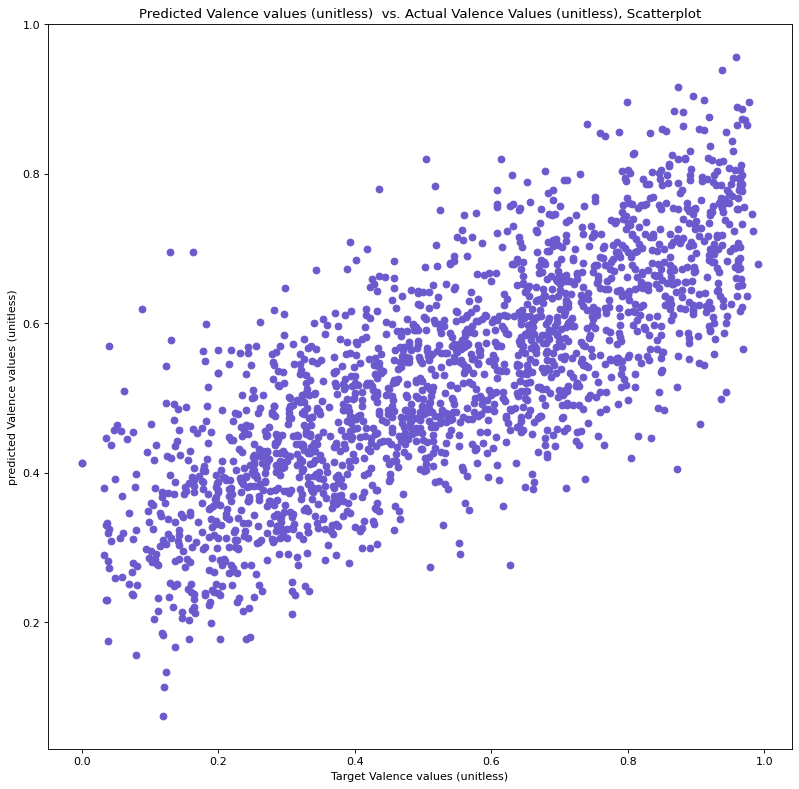

In [ ]:
plt.figure(figsize=(12, 12), dpi=80)
plt.scatter(target_test_4d, predicted_test, color='slateblue')
plt.xlabel('Target Valence values (unitless)')
plt.ylabel('predicted Valence values (unitless)')
plt.title('Predicted Valence values (unitless)  vs. Actual Valence Values (unitless), Scatterplot')
plt.plot()